In [13]:
import random
import csv
import time, array
import numpy as np
import pandas as pd
import autograd.numpy as anp

from math import sin, cos, pi, exp, e, sqrt, factorial
from operator import mul
from functools import reduce

import pymop
from deap import base, creator, tools, algorithms, benchmarks 
from deap.benchmarks.tools import diversity, convergence, hypervolume

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [14]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [15]:
def measure_time(x):
    execution_time = time.time() - start_time 
#     print(execution_time)
    return execution_time

In [4]:
# def nsga_ii(toolbox, seed, stats=None, verbose=False):
#     pop = toolbox.population(n=toolbox.pop_size)
#     pop = toolbox.select(pop, len(pop))
#     random.seed(seed)
#     return algorithms.eaMuPlusLambda(pop, 
#                                      toolbox, 
#                                      mu=toolbox.pop_size, 
#                                      lambda_=toolbox.pop_size, 
#                                      cxpb=toolbox.cross_prob,
#                                      mutpb=toolbox.mut_prob,
#                                      ngen=toolbox.max_gen,
#                                      stats=stats, 
#                                      verbose=verbose)

In [16]:
def nsga_ii(toolbox, seed, stats=None, verbose=False):
    random.seed(seed)
    pop = toolbox.population(n=toolbox.pop_size)
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    for gen in range(1, NGEN):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2],offspring[1::2]):
            if random.random() <= toolbox.cross_prob:
                toolbox.map(ind1, ind2)
                
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            
            del ind1.fitness.values, ind2.fitness.values
        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
               
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        pop = toolbox.select(pop+offspring,toolbox.pop_size)
    
    return pop, logbook

In [17]:
def nsga_iii(toolbox,seed,stats,logbook,NGEN,MU,CXPB,MUTPB,verbose=False):
    random.seed(seed)
    pop = toolbox.population(n=MU)
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#   fitnesses = toolbox.map(toolbox.evaluate, pop)        
#     for ind, fit in zip(pop, fitnesses):
#         ind.fitness.values = fit
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)
        
        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
    
    return pop, logbook

In [18]:
def dtlz1(individual, obj=3):
    g = 100 * (len(individual[obj - 1:]) + sum((xi - 0.5)**2 - cos(20 * pi * (xi - 0.5)) for xi in individual[obj - 1:]))
    f = [0.5 * reduce(mul, individual[:obj - 1], 1) * (1 + g)]
    f.extend(0.5 * reduce(mul, individual[:m], 1) * (1 - individual[m]) * (1 + g) for m in reversed(range(obj - 1)))
    
    return f

In [19]:
def dtlz2(individual, obj=4):
    xc = individual[:obj - 1]
    xm = individual[obj - 1:]
    g = sum((xi - 0.5)**2 for xi in xm)
    f = [(1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc), 1.0)]
    f.extend((1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc[:m]), 1) * sin(0.5 * xc[m] * pi) for m in range(obj - 2, -1, -1))

    return f

In [20]:
def dtlz3(individual, obj=6):
    xc = individual[:obj - 1]
    xm = individual[obj - 1:]
    g = 100 * (len(xm) + sum((xi - 0.5)**2 - cos(20 * pi * (xi - 0.5)) for xi in xm))
    f = [(1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc), 1.0)]
    f.extend((1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc[:m]), 1) * sin(0.5 * xc[m] * pi) for m in range(obj - 2, -1, -1))
    
    return f

In [21]:
def dtlz7(ind, n_objs=3):
    gval = 1 + 9.0 / len(ind[n_objs - 1:]) * sum([a for a in ind[n_objs - 1:]])
    fit = [x for x in ind[:n_objs - 1]]
    fit.append((1 + gval) * (n_objs - sum([a / (1.0 + gval) * (1 + sin(3 * pi * a)) for a in ind[:n_objs - 1]])))
    
    return fit

In [22]:
NOBJ = 3
NDIM = 4
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 92

In [23]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz1) #Fitness Function

    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"

    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_dtlz1_92_500_3_4-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_dtlz1_92_500_3_4-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


Iteration 1
gen	evals	Tiempo   
1  	     	0.0253215
2  	     	0.0632982
3  	     	0.0931075
4  	     	0.103246 
5  	     	0.122916 
6  	     	0.1333   
7  	     	0.15448  
8  	     	0.173232 
9  	     	0.190395 
10 	     	0.211087 
11 	     	0.229604 
12 	     	0.244777 
13 	     	0.260661 
14 	     	0.283612 
15 	     	0.303236 
16 	     	0.324395 
17 	     	0.344509 
18 	     	0.363297 
19 	     	0.383516 
20 	     	0.400961 
21 	     	0.418212 
22 	     	0.434386 
23 	     	0.454144 
24 	     	0.474391 
25 	     	0.50341  
26 	     	0.551256 
27 	     	0.59609  
28 	     	0.649817 
29 	     	0.696088 
30 	     	0.734408 
31 	     	0.77795  
32 	     	0.803108 
33 	     	0.823933 
34 	     	0.859371 
35 	     	0.887597 
36 	     	0.917571 
37 	     	0.937371 
38 	     	0.961384 
39 	     	0.981105 
40 	     	0.999776 
41 	     	1.02748  
42 	     	1.05997  
43 	     	1.08727  
44 	     	1.11353  
45 	     	1.13425  
46 	     	1.15397  
47 	     	1.18945  
48 	     	1.20911  
49 	    

410	     	9.63794  
411	     	9.66746  
412	     	9.72813  
413	     	9.78571  
414	     	9.84001  
415	     	9.86893  
416	     	9.89693  
417	     	9.92764  
418	     	9.9453   
419	     	9.97236  
420	     	9.99356  
421	     	10.0157  
422	     	10.0381  
423	     	10.0632  
424	     	10.0824  
425	     	10.1033  
426	     	10.1233  
427	     	10.1453  
428	     	10.1643  
429	     	10.1931  
430	     	10.2144  
431	     	10.2341  
432	     	10.2619  
433	     	10.2813  
434	     	10.304   
435	     	10.3224  
436	     	10.346   
437	     	10.3674  
438	     	10.3934  
439	     	10.4135  
440	     	10.4342  
441	     	10.453   
442	     	10.4722  
443	     	10.5196  
444	     	10.5822  
445	     	10.6325  
446	     	10.6903  
447	     	10.7511  
448	     	10.803   
449	     	10.8395  
450	     	10.8683  
451	     	10.9042  
452	     	10.9341  
453	     	10.9632  
454	     	10.9842  
455	     	11.0079  
456	     	11.0241  
457	     	11.0452  
458	     	11.0709  
459	     	11.0962  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 2
gen	evals	Tiempo   
1  	     	0.0215523
2  	     	0.0564575
3  	     	0.0849648
4  	     	0.107722 
5  	     	0.124819 
6  	     	0.142561 
7  	     	0.155745 
8  	     	0.174418 
9  	     	0.184613 
10 	     	0.204747 
11 	     	0.218683 
12 	     	0.234016 
13 	     	0.255662 
14 	     	0.273708 
15 	     	0.292465 
16 	     	0.307736 
17 	     	0.324055 
18 	     	0.337539 
19 	     	0.349794 
20 	     	0.366246 
21 	     	0.384619 
22 	     	0.403619 
23 	     	0.423872 
24 	     	0.448573 
25 	     	0.474622 
26 	     	0.506533 
27 	     	0.524624 
28 	     	0.544965 
29 	     	0.564644 
30 	     	0.584886 
31 	     	0.606803 
32 	     	0.649725 
33 	     	0.699531 
34 	     	0.724878 
35 	     	0.752478 
36 	     	0.784964 
37 	     	0.813929 
38 	     	0.837505 
39 	     	0.859681 
40 	     	0.88356  
41 	     	0.904348 
42 	     	0.931976 
43 	     	0.979103 
44 	     	1.04558  
45 	     	1.06444  
46 	     	1.08896  
47 	     	1.10848  
48 	     	1.12784  
49 	    

415	     	10.1599  
416	     	10.2167  
417	     	10.2699  
418	     	10.3194  
419	     	10.3554  
420	     	10.3825  
421	     	10.4097  
422	     	10.443   
423	     	10.465   
424	     	10.4937  
425	     	10.5092  
426	     	10.5267  
427	     	10.5486  
428	     	10.584   
429	     	10.6329  
430	     	10.7063  
431	     	10.766   
432	     	10.8093  
433	     	10.8555  
434	     	10.8947  
435	     	10.9439  
436	     	10.9808  
437	     	11.033   
438	     	11.0826  
439	     	11.1247  
440	     	11.1564  
441	     	11.1997  
442	     	11.234   
443	     	11.274   
444	     	11.3315  
445	     	11.3645  
446	     	11.3931  
447	     	11.422   
448	     	11.4455  
449	     	11.4689  
450	     	11.4892  
451	     	11.5124  
452	     	11.5284  
453	     	11.5449  
454	     	11.5646  
455	     	11.5924  
456	     	11.6127  
457	     	11.6323  
458	     	11.6588  
459	     	11.6885  
460	     	11.7052  
461	     	11.7285  
462	     	11.7551  
463	     	11.7737  
464	     	11.7954  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.215517 
8  	     	0.242549 
9  	     	0.25555  
10 	     	0.267948 
11 	     	0.288113 
12 	     	0.308855 
13 	     	0.329558 
14 	     	0.35853  
15 	     	0.379804 
16 	     	0.398509 
17 	     	0.417853 
18 	     	0.43339  
19 	     	0.451769 
20 	     	0.467969 
21 	     	0.491691 
22 	     	0.507366 
23 	     	0.526638 
24 	     	0.543161 
25 	     	0.562573 
26 	     	0.585246 
27 	     	0.625464 
28 	     	0.669506 
29 	     	0.712555 
30 	     	0.759454 
31 	     	0.808626 
32 	     	0.851795 
33 	     	0.890289 
34 	     	0.916622 
35 	     	0.931592 
36 	     	0.957721 
37 	     	0.973073 
38 	     	0.994339 
39 	     	1.0128   
40 	     	1.02929  
41 	     	1.04706  
42 	     	1.0669   
43 	     	1.08653  
44 	     	1.1068   
45 	     	1.12537  
46 	     	1.14298  
47 	     	1.16764  
48 	     	1.18975  
49 	     	1.2085   
50 	     	1.22858  
51 	     	1.24789  
52 	     	1.26504  
53 	     	1.28276  
54 	     	1.30665  
55 	     	1.32784  
56 	     	1.34699  


424	     	10.458   
425	     	10.4788  
426	     	10.4986  
427	     	10.5227  
428	     	10.5388  
429	     	10.5621  
430	     	10.5827  
431	     	10.6075  
432	     	10.6278  
433	     	10.6474  
434	     	10.6717  
435	     	10.69    
436	     	10.7119  
437	     	10.7319  
438	     	10.7485  
439	     	10.7737  
440	     	10.7905  
441	     	10.8156  
442	     	10.8468  
443	     	10.8684  
444	     	10.8973  
445	     	10.9187  
446	     	10.9447  
447	     	10.9678  
448	     	10.9906  
449	     	11.0085  
450	     	11.0275  
451	     	11.0478  
452	     	11.0727  
453	     	11.0904  
454	     	11.116   
455	     	11.141   
456	     	11.1586  
457	     	11.1778  
458	     	11.1987  
459	     	11.2163  
460	     	11.2366  
461	     	11.2574  
462	     	11.2759  
463	     	11.2914  
464	     	11.308   
465	     	11.3278  
466	     	11.3527  
467	     	11.369   
468	     	11.3894  
469	     	11.4084  
470	     	11.4275  
471	     	11.4566  
472	     	11.4809  
473	     	11.5092  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.0638661
4  	     	0.0857992
5  	     	0.102202 
6  	     	0.122434 
7  	     	0.139042 
8  	     	0.15618  
9  	     	0.175094 
10 	     	0.194132 
11 	     	0.211714 
12 	     	0.222211 
13 	     	0.236261 
14 	     	0.251046 
15 	     	0.271189 
16 	     	0.290169 
17 	     	0.306327 
18 	     	0.32593  
19 	     	0.352326 
20 	     	0.371058 
21 	     	0.39017  
22 	     	0.411173 
23 	     	0.429439 
24 	     	0.450008 
25 	     	0.470388 
26 	     	0.490029 
27 	     	0.514473 
28 	     	0.540185 
29 	     	0.561332 
30 	     	0.581433 
31 	     	0.599201 
32 	     	0.618603 
33 	     	0.641315 
34 	     	0.668568 
35 	     	0.690172 
36 	     	0.708073 
37 	     	0.731496 
38 	     	0.751203 
39 	     	0.770914 
40 	     	0.795358 
41 	     	0.816001 
42 	     	0.835556 
43 	     	0.851705 
44 	     	0.877436 
45 	     	0.897127 
46 	     	0.920097 
47 	     	0.94919  
48 	     	0.968216 
49 	     	0.986372 
50 	     	1.01097  
51 	     	1.03122  
52 	     	1.05024  


422	     	9.23989  
423	     	9.27038  
424	     	9.29113  
425	     	9.31348  
426	     	9.33814  
427	     	9.36398  
428	     	9.39144  
429	     	9.41605  
430	     	9.4381   
431	     	9.45923  
432	     	9.48098  
433	     	9.51182  
434	     	9.53316  
435	     	9.55145  
436	     	9.58197  
437	     	9.60669  
438	     	9.63043  
439	     	9.65195  
440	     	9.67137  
441	     	9.6949   
442	     	9.71648  
443	     	9.73754  
444	     	9.75634  
445	     	9.77809  
446	     	9.79695  
447	     	9.82416  
448	     	9.84923  
449	     	9.87133  
450	     	9.89107  
451	     	9.91546  
452	     	9.93631  
453	     	9.96291  
454	     	9.98634  
455	     	10.009   
456	     	10.029   
457	     	10.0502  
458	     	10.0709  
459	     	10.0957  
460	     	10.1189  
461	     	10.1404  
462	     	10.1628  
463	     	10.1823  
464	     	10.2092  
465	     	10.2346  
466	     	10.2521  
467	     	10.275   
468	     	10.297   
469	     	10.316   
470	     	10.3403  
471	     	10.364   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


12 	     	0.234559 
13 	     	0.256072 
14 	     	0.270515 
15 	     	0.287546 
16 	     	0.304483 
17 	     	0.323641 
18 	     	0.339864 
19 	     	0.360665 
20 	     	0.37994  
21 	     	0.4013   
22 	     	0.421745 
23 	     	0.440456 
24 	     	0.462084 
25 	     	0.486497 
26 	     	0.503947 
27 	     	0.5235   
28 	     	0.547249 
29 	     	0.564581 
30 	     	0.58475  
31 	     	0.610612 
32 	     	0.634277 
33 	     	0.650605 
34 	     	0.676587 
35 	     	0.698738 
36 	     	0.71573  
37 	     	0.735898 
38 	     	0.754998 
39 	     	0.770584 
40 	     	0.795116 
41 	     	0.812546 
42 	     	0.830914 
43 	     	0.855839 
44 	     	0.877428 
45 	     	0.897621 
46 	     	0.918519 
47 	     	0.93876  
48 	     	0.960566 
49 	     	0.980783 
50 	     	0.998406 
51 	     	1.02079  
52 	     	1.04422  
53 	     	1.06232  
54 	     	1.07811  
55 	     	1.09863  
56 	     	1.11667  
57 	     	1.13459  
58 	     	1.16057  
59 	     	1.17988  
60 	     	1.19933  
61 	     	1.22126  


433	     	9.41963  
434	     	9.44956  
435	     	9.47098  
436	     	9.49275  
437	     	9.51333  
438	     	9.53572  
439	     	9.56172  
440	     	9.57976  
441	     	9.60935  
442	     	9.62809  
443	     	9.65103  
444	     	9.67092  
445	     	9.69506  
446	     	9.71088  
447	     	9.73456  
448	     	9.75312  
449	     	9.77984  
450	     	9.79943  
451	     	9.82075  
452	     	9.84274  
453	     	9.86134  
454	     	9.87954  
455	     	9.90076  
456	     	9.92511  
457	     	9.94406  
458	     	9.96733  
459	     	9.98751  
460	     	10.0054  
461	     	10.0307  
462	     	10.0506  
463	     	10.0796  
464	     	10.1006  
465	     	10.1247  
466	     	10.1447  
467	     	10.1664  
468	     	10.1839  
469	     	10.2098  
470	     	10.2289  
471	     	10.2437  
472	     	10.265   
473	     	10.2973  
474	     	10.3332  
475	     	10.3549  
476	     	10.3787  
477	     	10.3994  
478	     	10.4231  
479	     	10.4442  
480	     	10.4614  
481	     	10.4858  
482	     	10.5095  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


12 	     	0.21941  
13 	     	0.24135  
14 	     	0.258871 
15 	     	0.273599 
16 	     	0.287183 
17 	     	0.301598 
18 	     	0.323882 
19 	     	0.343726 
20 	     	0.359081 
21 	     	0.381043 
22 	     	0.398034 
23 	     	0.412627 
24 	     	0.431695 
25 	     	0.451679 
26 	     	0.476102 
27 	     	0.492168 
28 	     	0.512913 
29 	     	0.531219 
30 	     	0.555568 
31 	     	0.574565 
32 	     	0.601651 
33 	     	0.626593 
34 	     	0.651667 
35 	     	0.676975 
36 	     	0.697358 
37 	     	0.723888 
38 	     	0.742301 
39 	     	0.767195 
40 	     	0.790833 
41 	     	0.813462 
42 	     	0.832843 
43 	     	0.857826 
44 	     	0.877875 
45 	     	0.898323 
46 	     	0.91813  
47 	     	0.940943 
48 	     	0.957506 
49 	     	0.982184 
50 	     	0.997996 
51 	     	1.02544  
52 	     	1.04892  
53 	     	1.06728  
54 	     	1.09538  
55 	     	1.11745  
56 	     	1.1412   
57 	     	1.15919  
58 	     	1.17784  
59 	     	1.19986  
60 	     	1.22385  
61 	     	1.24238  


436	     	9.49715  
437	     	9.51844  
438	     	9.54113  
439	     	9.56469  
440	     	9.58219  
441	     	9.60785  
442	     	9.63359  
443	     	9.65747  
444	     	9.67745  
445	     	9.7001   
446	     	9.72412  
447	     	9.74135  
448	     	9.76526  
449	     	9.78217  
450	     	9.8072   
451	     	9.83243  
452	     	9.85349  
453	     	9.87522  
454	     	9.89814  
455	     	9.91848  
456	     	9.94119  
457	     	9.96478  
458	     	9.98736  
459	     	10.0113  
460	     	10.0323  
461	     	10.0552  
462	     	10.0783  
463	     	10.1023  
464	     	10.1261  
465	     	10.1462  
466	     	10.1651  
467	     	10.1863  
468	     	10.2074  
469	     	10.2295  
470	     	10.2512  
471	     	10.2731  
472	     	10.2983  
473	     	10.3252  
474	     	10.347   
475	     	10.3734  
476	     	10.3981  
477	     	10.4184  
478	     	10.4402  
479	     	10.4619  
480	     	10.4782  
481	     	10.4995  
482	     	10.5231  
483	     	10.5413  
484	     	10.5652  
485	     	10.5875  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.198568  
11 	     	0.216289  
12 	     	0.230345  
13 	     	0.248241  
14 	     	0.267433  
15 	     	0.278743  
16 	     	0.298272  
17 	     	0.315505  
18 	     	0.338974  
19 	     	0.358749  
20 	     	0.378295  
21 	     	0.396602  
22 	     	0.417304  
23 	     	0.442877  
24 	     	0.469523  
25 	     	0.490825  
26 	     	0.509421  
27 	     	0.533762  
28 	     	0.552558  
29 	     	0.572434  
30 	     	0.596395  
31 	     	0.613911  
32 	     	0.641787  
33 	     	0.664539  
34 	     	0.693764  
35 	     	0.713717  
36 	     	0.738819  
37 	     	0.766251  
38 	     	0.787769  
39 	     	0.809478  
40 	     	0.829653  
41 	     	0.847443  
42 	     	0.872422  
43 	     	0.889727  
44 	     	0.908749  
45 	     	0.929284  
46 	     	0.949872  
47 	     	0.972352  
48 	     	0.996189  
49 	     	1.02311   
50 	     	1.03908   
51 	     	1.06255   
52 	     	1.08846   
53 	     	1.10967   
54 	     	1.1321    
55 	     	1.15685   
56 	     	1.1775    
57 	     	1.2

406	     	9.32517   
407	     	9.3462    
408	     	9.36578   
409	     	9.38269   
410	     	9.41111   
411	     	9.4342    
412	     	9.46213   
413	     	9.48821   
414	     	9.51015   
415	     	9.53074   
416	     	9.55679   
417	     	9.5795    
418	     	9.60246   
419	     	9.62619   
420	     	9.64612   
421	     	9.67028   
422	     	9.69625   
423	     	9.71622   
424	     	9.74023   
425	     	9.76518   
426	     	9.78719   
427	     	9.80917   
428	     	9.82846   
429	     	9.8477    
430	     	9.86641   
431	     	9.88622   
432	     	9.90616   
433	     	9.92715   
434	     	9.94818   
435	     	9.97221   
436	     	9.99422   
437	     	10.0124   
438	     	10.0412   
439	     	10.0652   
440	     	10.0912   
441	     	10.1178   
442	     	10.1402   
443	     	10.1618   
444	     	10.1822   
445	     	10.2082   
446	     	10.2317   
447	     	10.2612   
448	     	10.2852   
449	     	10.3071   
450	     	10.3309   
451	     	10.3502   
452	     	10.3741   
453	     	10.

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.174488 
9  	     	0.196759 
10 	     	0.212728 
11 	     	0.23077  
12 	     	0.251814 
13 	     	0.271718 
14 	     	0.293788 
15 	     	0.315379 
16 	     	0.338318 
17 	     	0.360549 
18 	     	0.373565 
19 	     	0.393755 
20 	     	0.409714 
21 	     	0.434247 
22 	     	0.455537 
23 	     	0.474449 
24 	     	0.492791 
25 	     	0.50779  
26 	     	0.525894 
27 	     	0.540717 
28 	     	0.562736 
29 	     	0.583684 
30 	     	0.605408 
31 	     	0.626316 
32 	     	0.643858 
33 	     	0.661793 
34 	     	0.683562 
35 	     	0.703757 
36 	     	0.72226  
37 	     	0.740174 
38 	     	0.764494 
39 	     	0.78943  
40 	     	0.809747 
41 	     	0.83468  
42 	     	0.860626 
43 	     	0.886381 
44 	     	0.910386 
45 	     	0.929503 
46 	     	0.952374 
47 	     	0.973269 
48 	     	0.997248 
49 	     	1.01714  
50 	     	1.03441  
51 	     	1.06465  
52 	     	1.08768  
53 	     	1.11266  
54 	     	1.14674  
55 	     	1.179    
56 	     	1.2027   
57 	     	1.22708  


432	     	9.41049  
433	     	9.43369  
434	     	9.45386  
435	     	9.47361  
436	     	9.49291  
437	     	9.51454  
438	     	9.53554  
439	     	9.55486  
440	     	9.57711  
441	     	9.59994  
442	     	9.62373  
443	     	9.64453  
444	     	9.66582  
445	     	9.69596  
446	     	9.71492  
447	     	9.74177  
448	     	9.76257  
449	     	9.78119  
450	     	9.80442  
451	     	9.81861  
452	     	9.83897  
453	     	9.86483  
454	     	9.88546  
455	     	9.91052  
456	     	9.92835  
457	     	9.9524   
458	     	9.97462  
459	     	9.99556  
460	     	10.0156  
461	     	10.0446  
462	     	10.0649  
463	     	10.0847  
464	     	10.1127  
465	     	10.14    
466	     	10.1666  
467	     	10.1851  
468	     	10.2108  
469	     	10.2291  
470	     	10.2497  
471	     	10.2651  
472	     	10.2948  
473	     	10.3136  
474	     	10.3388  
475	     	10.3647  
476	     	10.3839  
477	     	10.4054  
478	     	10.428   
479	     	10.4547  
480	     	10.4794  
481	     	10.4991  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.104161 
4  	     	0.127723 
5  	     	0.144923 
6  	     	0.165892 
7  	     	0.190372 
8  	     	0.219836 
9  	     	0.238544 
10 	     	0.256456 
11 	     	0.273076 
12 	     	0.290713 
13 	     	0.30937  
14 	     	0.324779 
15 	     	0.340848 
16 	     	0.361659 
17 	     	0.385689 
18 	     	0.407622 
19 	     	0.429516 
20 	     	0.448813 
21 	     	0.465988 
22 	     	0.485689 
23 	     	0.499923 
24 	     	0.518044 
25 	     	0.540884 
26 	     	0.560476 
27 	     	0.580819 
28 	     	0.60216  
29 	     	0.620683 
30 	     	0.638499 
31 	     	0.659559 
32 	     	0.684664 
33 	     	0.704056 
34 	     	0.724788 
35 	     	0.744742 
36 	     	0.769612 
37 	     	0.78735  
38 	     	0.808508 
39 	     	0.825963 
40 	     	0.844505 
41 	     	0.860751 
42 	     	0.884362 
43 	     	0.907742 
44 	     	0.925278 
45 	     	0.948837 
46 	     	0.969679 
47 	     	0.989889 
48 	     	1.01052  
49 	     	1.03956  
50 	     	1.05504  
51 	     	1.07836  
52 	     	1.10336  


422	     	8.78427  
423	     	8.80272  
424	     	8.82956  
425	     	8.85323  
426	     	8.87742  
427	     	8.90081  
428	     	8.92032  
429	     	8.94851  
430	     	8.96891  
431	     	8.98955  
432	     	9.00989  
433	     	9.03863  
434	     	9.06147  
435	     	9.08289  
436	     	9.10333  
437	     	9.12106  
438	     	9.14665  
439	     	9.16991  
440	     	9.19382  
441	     	9.22466  
442	     	9.24266  
443	     	9.26342  
444	     	9.2879   
445	     	9.3064   
446	     	9.32491  
447	     	9.34584  
448	     	9.37109  
449	     	9.38947  
450	     	9.40981  
451	     	9.43753  
452	     	9.46153  
453	     	9.47965  
454	     	9.50467  
455	     	9.52455  
456	     	9.54853  
457	     	9.57002  
458	     	9.59159  
459	     	9.61138  
460	     	9.63537  
461	     	9.65771  
462	     	9.6805   
463	     	9.70186  
464	     	9.72411  
465	     	9.74855  
466	     	9.76975  
467	     	9.7925   
468	     	9.811    
469	     	9.82894  
470	     	9.85334  
471	     	9.87456  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.129003 
7  	     	0.153771 
8  	     	0.173153 
9  	     	0.192558 
10 	     	0.20874  
11 	     	0.226615 
12 	     	0.241793 
13 	     	0.257485 
14 	     	0.282974 
15 	     	0.307606 
16 	     	0.332169 
17 	     	0.349675 
18 	     	0.372478 
19 	     	0.39127  
20 	     	0.422831 
21 	     	0.445772 
22 	     	0.471505 
23 	     	0.494171 
24 	     	0.509643 
25 	     	0.535551 
26 	     	0.558353 
27 	     	0.577744 
28 	     	0.602587 
29 	     	0.622319 
30 	     	0.641835 
31 	     	0.668019 
32 	     	0.688579 
33 	     	0.708905 
34 	     	0.732851 
35 	     	0.746867 
36 	     	0.768017 
37 	     	0.782911 
38 	     	0.804467 
39 	     	0.825601 
40 	     	0.845459 
41 	     	0.865296 
42 	     	0.885427 
43 	     	0.905086 
44 	     	0.926772 
45 	     	0.946921 
46 	     	0.968649 
47 	     	0.988979 
48 	     	1.01521  
49 	     	1.03736  
50 	     	1.06153  
51 	     	1.0787   
52 	     	1.10132  
53 	     	1.11781  
54 	     	1.14558  
55 	     	1.16511  


425	     	9.19998  
426	     	9.22562  
427	     	9.24941  
428	     	9.26787  
429	     	9.28833  
430	     	9.30867  
431	     	9.3355   
432	     	9.35295  
433	     	9.37833  
434	     	9.39989  
435	     	9.41762  
436	     	9.44043  
437	     	9.46577  
438	     	9.48838  
439	     	9.51789  
440	     	9.53976  
441	     	9.55685  
442	     	9.58253  
443	     	9.60636  
444	     	9.6287   
445	     	9.64966  
446	     	9.67785  
447	     	9.70141  
448	     	9.72189  
449	     	9.74657  
450	     	9.76861  
451	     	9.79389  
452	     	9.81663  
453	     	9.84118  
454	     	9.86248  
455	     	9.88837  
456	     	9.90867  
457	     	9.93564  
458	     	9.96379  
459	     	9.98885  
460	     	10.0091  
461	     	10.0335  
462	     	10.0616  
463	     	10.0855  
464	     	10.1087  
465	     	10.1335  
466	     	10.158   
467	     	10.1828  
468	     	10.2066  
469	     	10.2287  
470	     	10.2494  
471	     	10.2719  
472	     	10.2924  
473	     	10.3181  
474	     	10.3376  


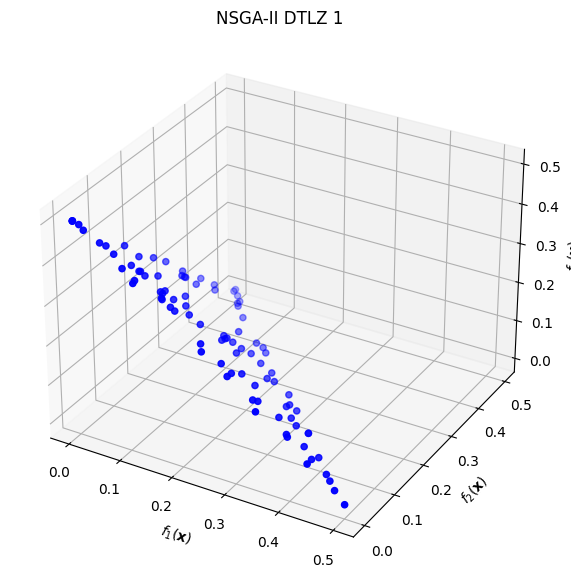

In [61]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-II DTLZ 1")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [24]:
NOBJ = 3
NDIM = 4
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 92

ref_points = tools.uniform_reference_points(NOBJ, P)

In [25]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz1) #Fitness Function
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_dtlz1_92_500_3_4-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_dtlz1_92_500_3_100-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0232947
2  	     	0.044049 
3  	     	0.0628538
4  	     	0.0893097
5  	     	0.105829 
6  	     	0.117478 
7  	     	0.130774 
8  	     	0.150883 
9  	     	0.161239 
10 	     	0.172929 
11 	     	0.179513 
12 	     	0.187085 
13 	     	0.194994 
14 	     	0.202334 
15 	     	0.215529 
16 	     	0.229952 
17 	     	0.243841 
18 	     	0.260922 
19 	     	0.275321 
20 	     	0.289875 
21 	     	0.302725 
22 	     	0.317344 
23 	     	0.330859 
24 	     	0.336865 
25 	     	0.351896 
26 	     	0.36504  
27 	     	0.382036 
28 	     	0.394619 
29 	     	0.403727 
30 	     	0.411863 
31 	     	0.422999 
32 	     	0.431487 
33 	     	0.441869 
34 	     	0.450547 
35 	     	0.457936 
36 	     	0.471904 
37 	     	0.481046 
38 	     	0.494318 
39 	     	0.507117 
40 	     	0.512206 
41 	     	0.522396 
42 	     	0.531447 
43 	     	0.539977 
44 	     	0.548248 
45 	     	0.551928 
46 	     	0.563065 
47 	     	0.571809 
48 	     	0.582729 
49 	    

413	     	3.97682  
414	     	3.98723  
415	     	3.99272  
416	     	4.0034   
417	     	4.01516  
418	     	4.02441  
419	     	4.0318   
420	     	4.04377  
421	     	4.05194  
422	     	4.05973  
423	     	4.06677  
424	     	4.07755  
425	     	4.08288  
426	     	4.09325  
427	     	4.10257  
428	     	4.11083  
429	     	4.11957  
430	     	4.12679  
431	     	4.13433  
432	     	4.14472  
433	     	4.15198  
434	     	4.16212  
435	     	4.17087  
436	     	4.17953  
437	     	4.18551  
438	     	4.19855  
439	     	4.20676  
440	     	4.214    
441	     	4.22544  
442	     	4.2326   
443	     	4.24482  
444	     	4.25207  
445	     	4.26077  
446	     	4.26681  
447	     	4.2796   
448	     	4.28688  
449	     	4.29319  
450	     	4.30401  
451	     	4.31185  
452	     	4.32287  
453	     	4.3339   
454	     	4.34268  
455	     	4.3507   
456	     	4.35776  
457	     	4.36687  
458	     	4.37679  
459	     	4.38258  
460	     	4.39271  
461	     	4.4018   
462	     	4.41216  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.0525141 
8  	     	0.0605469 
9  	     	0.0685294 
10 	     	0.0728657 
11 	     	0.0839951 
12 	     	0.0890384 
13 	     	0.0936031 
14 	     	0.103867  
15 	     	0.113096  
16 	     	0.118137  
17 	     	0.128328  
18 	     	0.136543  
19 	     	0.145178  
20 	     	0.152007  
21 	     	0.160562  
22 	     	0.167699  
23 	     	0.175864  
24 	     	0.183853  
25 	     	0.192128  
26 	     	0.19822   
27 	     	0.206937  
28 	     	0.212542  
29 	     	0.221829  
30 	     	0.227329  
31 	     	0.232982  
32 	     	0.244771  
33 	     	0.251655  
34 	     	0.259706  
35 	     	0.263848  
36 	     	0.277274  
37 	     	0.284647  
38 	     	0.292722  
39 	     	0.300974  
40 	     	0.308684  
41 	     	0.313707  
42 	     	0.326357  
43 	     	0.332693  
44 	     	0.341995  
45 	     	0.352014  
46 	     	0.360657  
47 	     	0.367696  
48 	     	0.379902  
49 	     	0.383828  
50 	     	0.39418   
51 	     	0.405732  
52 	     	0.412807  
53 	     	0.423848  
54 	     	0.4

414	     	3.7783    
415	     	3.78842   
416	     	3.80082   
417	     	3.81049   
418	     	3.81655   
419	     	3.82614   
420	     	3.83288   
421	     	3.84377   
422	     	3.8527    
423	     	3.86281   
424	     	3.86786   
425	     	3.87818   
426	     	3.88918   
427	     	3.89749   
428	     	3.90385   
429	     	3.91381   
430	     	3.922     
431	     	3.93062   
432	     	3.93678   
433	     	3.94731   
434	     	3.95343   
435	     	3.96402   
436	     	3.97264   
437	     	3.98368   
438	     	3.98773   
439	     	4.00197   
440	     	4.01345   
441	     	4.02189   
442	     	4.03181   
443	     	4.0428    
444	     	4.04884   
445	     	4.05822   
446	     	4.06291   
447	     	4.07385   
448	     	4.08313   
449	     	4.09349   
450	     	4.09853   
451	     	4.11048   
452	     	4.11592   
453	     	4.12706   
454	     	4.1335    
455	     	4.14555   
456	     	4.15316   
457	     	4.1617    
458	     	4.16771   
459	     	4.1782    
460	     	4.184     
461	     	4.1

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.0981963
5  	     	0.111037 
6  	     	0.116724 
7  	     	0.125751 
8  	     	0.129834 
9  	     	0.138477 
10 	     	0.145706 
11 	     	0.153868 
12 	     	0.159949 
13 	     	0.16593  
14 	     	0.175402 
15 	     	0.181448 
16 	     	0.188644 
17 	     	0.196626 
18 	     	0.208379 
19 	     	0.2198   
20 	     	0.227025 
21 	     	0.236627 
22 	     	0.246883 
23 	     	0.251974 
24 	     	0.260021 
25 	     	0.265566 
26 	     	0.276387 
27 	     	0.28148  
28 	     	0.288671 
29 	     	0.296581 
30 	     	0.305646 
31 	     	0.315875 
32 	     	0.323449 
33 	     	0.330694 
34 	     	0.339589 
35 	     	0.346562 
36 	     	0.355764 
37 	     	0.363411 
38 	     	0.370826 
39 	     	0.377478 
40 	     	0.387758 
41 	     	0.39675  
42 	     	0.405041 
43 	     	0.415429 
44 	     	0.42048  
45 	     	0.431924 
46 	     	0.436806 
47 	     	0.447766 
48 	     	0.459948 
49 	     	0.466595 
50 	     	0.477845 
51 	     	0.485909 
52 	     	0.496469 
53 	     	0.500518 


435	     	4.01755  
436	     	4.03091  
437	     	4.03696  
438	     	4.04618  
439	     	4.05659  
440	     	4.0658   
441	     	4.07596  
442	     	4.08445  
443	     	4.09376  
444	     	4.09991  
445	     	4.11081  
446	     	4.11692  
447	     	4.12683  
448	     	4.13679  
449	     	4.14571  
450	     	4.15464  
451	     	4.16027  
452	     	4.17062  
453	     	4.17803  
454	     	4.18732  
455	     	4.19616  
456	     	4.2102   
457	     	4.22037  
458	     	4.22962  
459	     	4.24479  
460	     	4.2588   
461	     	4.26581  
462	     	4.26986  
463	     	4.28198  
464	     	4.29108  
465	     	4.29665  
466	     	4.3058   
467	     	4.31685  
468	     	4.32552  
469	     	4.33359  
470	     	4.34117  
471	     	4.34665  
472	     	4.36016  
473	     	4.3658   
474	     	4.37599  
475	     	4.38472  
476	     	4.39187  
477	     	4.401    
478	     	4.40981  
479	     	4.41655  
480	     	4.42553  
481	     	4.43489  
482	     	4.44621  
483	     	4.45454  
484	     	4.46025  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0060761
2  	     	0.0174949
3  	     	0.0220909
4  	     	0.0333924
5  	     	0.0400486
6  	     	0.0458617
7  	     	0.0543861
8  	     	0.0611472
9  	     	0.067297 
10 	     	0.0732675
11 	     	0.0813186
12 	     	0.0874097
13 	     	0.0967572
14 	     	0.10174  
15 	     	0.106424 
16 	     	0.117514 
17 	     	0.12273  
18 	     	0.129951 
19 	     	0.136523 
20 	     	0.141268 
21 	     	0.145312 
22 	     	0.15561  
23 	     	0.162772 
24 	     	0.170889 
25 	     	0.176893 
26 	     	0.186182 
27 	     	0.193255 
28 	     	0.202356 
29 	     	0.207402 
30 	     	0.21848  
31 	     	0.223047 
32 	     	0.235907 
33 	     	0.244912 
34 	     	0.253671 
35 	     	0.2621   
36 	     	0.27228  
37 	     	0.278406 
38 	     	0.288197 
39 	     	0.296069 
40 	     	0.301745 
41 	     	0.311213 
42 	     	0.320541 
43 	     	0.327793 
44 	     	0.336442 
45 	     	0.342092 
46 	     	0.346138 
47 	     	0.358064 
48 	     	0.361893 
49 	     	0.371937 


433	     	3.94662  
434	     	3.95588  
435	     	3.96192  
436	     	3.97498  
437	     	3.97902  
438	     	3.98973  
439	     	4.00009  
440	     	4.00839  
441	     	4.01729  
442	     	4.02211  
443	     	4.03721  
444	     	4.04272  
445	     	4.05321  
446	     	4.0621   
447	     	4.07233  
448	     	4.08078  
449	     	4.08908  
450	     	4.09844  
451	     	4.10404  
452	     	4.11428  
453	     	4.12187  
454	     	4.1349   
455	     	4.14205  
456	     	4.15179  
457	     	4.15779  
458	     	4.17088  
459	     	4.17909  
460	     	4.18494  
461	     	4.1964   
462	     	4.20601  
463	     	4.21288  
464	     	4.22207  
465	     	4.23013  
466	     	4.24072  
467	     	4.24794  
468	     	4.25654  
469	     	4.26675  
470	     	4.27758  
471	     	4.2863   
472	     	4.29332  
473	     	4.30461  
474	     	4.31223  
475	     	4.32238  
476	     	4.32643  
477	     	4.33783  
478	     	4.34612  
479	     	4.35323  
480	     	4.36189  
481	     	4.37287  
482	     	4.37897  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.041995  
6  	     	0.0555913 
7  	     	0.0622191 
8  	     	0.0699484 
9  	     	0.0723329 
10 	     	0.0856845 
11 	     	0.0920024 
12 	     	0.0960474 
13 	     	0.1033    
14 	     	0.111392  
15 	     	0.119342  
16 	     	0.124927  
17 	     	0.133252  
18 	     	0.139029  
19 	     	0.149524  
20 	     	0.154116  
21 	     	0.1631    
22 	     	0.172021  
23 	     	0.18007   
24 	     	0.187094  
25 	     	0.192323  
26 	     	0.201628  
27 	     	0.211236  
28 	     	0.221184  
29 	     	0.230277  
30 	     	0.237011  
31 	     	0.246864  
32 	     	0.255058  
33 	     	0.263298  
34 	     	0.271316  
35 	     	0.277355  
36 	     	0.287368  
37 	     	0.293047  
38 	     	0.30327   
39 	     	0.307317  
40 	     	0.319419  
41 	     	0.325388  
42 	     	0.335     
43 	     	0.344596  
44 	     	0.353769  
45 	     	0.36105   
46 	     	0.369761  
47 	     	0.379249  
48 	     	0.387046  
49 	     	0.397367  
50 	     	0.401953  
51 	     	0.417332  
52 	     	0.4

402	     	3.74291   
403	     	3.75405   
404	     	3.76304   
405	     	3.77228   
406	     	3.78591   
407	     	3.79118   
408	     	3.80164   
409	     	3.81129   
410	     	3.81926   
411	     	3.8233    
412	     	3.83578   
413	     	3.843     
414	     	3.85346   
415	     	3.8624    
416	     	3.8712    
417	     	3.88028   
418	     	3.89001   
419	     	3.89317   
420	     	3.90339   
421	     	3.91223   
422	     	3.92301   
423	     	3.93231   
424	     	3.94132   
425	     	3.94331   
426	     	3.95396   
427	     	3.97004   
428	     	3.97698   
429	     	3.98988   
430	     	3.99182   
431	     	4.00314   
432	     	4.01722   
433	     	4.02333   
434	     	4.03664   
435	     	4.043     
436	     	4.05354   
437	     	4.06332   
438	     	4.07226   
439	     	4.08211   
440	     	4.08992   
441	     	4.09432   
442	     	4.10362   
443	     	4.1127    
444	     	4.12338   
445	     	4.13483   
446	     	4.14332   
447	     	4.15398   
448	     	4.16199   
449	     	4.1

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


13 	     	0.0982461 
14 	     	0.109237  
15 	     	0.117383  
16 	     	0.124611  
17 	     	0.128248  
18 	     	0.141116  
19 	     	0.147292  
20 	     	0.149287  
21 	     	0.158903  
22 	     	0.167853  
23 	     	0.177311  
24 	     	0.178308  
25 	     	0.190864  
26 	     	0.199447  
27 	     	0.208469  
28 	     	0.217333  
29 	     	0.225927  
30 	     	0.228183  
31 	     	0.242553  
32 	     	0.247991  
33 	     	0.259708  
34 	     	0.266291  
35 	     	0.278407  
36 	     	0.291013  
37 	     	0.299107  
38 	     	0.308076  
39 	     	0.318474  
40 	     	0.326291  
41 	     	0.328327  
42 	     	0.343687  
43 	     	0.349157  
44 	     	0.358723  
45 	     	0.367521  
46 	     	0.374294  
47 	     	0.378351  
48 	     	0.39086   
49 	     	0.398448  
50 	     	0.398448  
51 	     	0.409987  
52 	     	0.423271  
53 	     	0.428395  
54 	     	0.439878  
55 	     	0.448308  
56 	     	0.457613  
57 	     	0.459601  
58 	     	0.475283  
59 	     	0.478465  
60 	     	0.4

412	     	3.82542   
413	     	3.83359   
414	     	3.84275   
415	     	3.8487    
416	     	3.85851   
417	     	3.86832   
418	     	3.87912   
419	     	3.88698   
420	     	3.89617   
421	     	3.90545   
422	     	3.91354   
423	     	3.91954   
424	     	3.92812   
425	     	3.93911   
426	     	3.94907   
427	     	3.95872   
428	     	3.96378   
429	     	3.97312   
430	     	3.98114   
431	     	3.99271   
432	     	3.99947   
433	     	4.01046   
434	     	4.01817   
435	     	4.02726   
436	     	4.03335   
437	     	4.04277   
438	     	4.05339   
439	     	4.05944   
440	     	4.06838   
441	     	4.07842   
442	     	4.08795   
443	     	4.09623   
444	     	4.10833   
445	     	4.12409   
446	     	4.13197   
447	     	4.14826   
448	     	4.1597    
449	     	4.17712   
450	     	4.18542   
451	     	4.19421   
452	     	4.19943   
453	     	4.21073   
454	     	4.22024   
455	     	4.22828   
456	     	4.23228   
457	     	4.24297   
458	     	4.25202   
459	     	4.2

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.045923 
7  	     	0.0534663
8  	     	0.0585854
9  	     	0.0659587
10 	     	0.0737572
11 	     	0.0803888
12 	     	0.086292 
13 	     	0.0939565
14 	     	0.103351 
15 	     	0.108466 
16 	     	0.116552 
17 	     	0.123626 
18 	     	0.132313 
19 	     	0.135726 
20 	     	0.144301 
21 	     	0.151    
22 	     	0.155486 
23 	     	0.166093 
24 	     	0.175792 
25 	     	0.184402 
26 	     	0.198223 
27 	     	0.207385 
28 	     	0.215982 
29 	     	0.224271 
30 	     	0.233409 
31 	     	0.243567 
32 	     	0.248348 
33 	     	0.256854 
34 	     	0.269008 
35 	     	0.275385 
36 	     	0.285558 
37 	     	0.289566 
38 	     	0.303238 
39 	     	0.308287 
40 	     	0.31956  
41 	     	0.325671 
42 	     	0.335759 
43 	     	0.34381  
44 	     	0.353636 
45 	     	0.358714 
46 	     	0.369865 
47 	     	0.376934 
48 	     	0.38438  
49 	     	0.395932 
50 	     	0.404571 
51 	     	0.414578 
52 	     	0.419625 
53 	     	0.429332 
54 	     	0.4354   
55 	     	0.447953 


436	     	3.99517  
437	     	4.00474  
438	     	4.01398  
439	     	4.02299  
440	     	4.03371  
441	     	4.03872  
442	     	4.0509   
443	     	4.05578  
444	     	4.06603  
445	     	4.07601  
446	     	4.08355  
447	     	4.09158  
448	     	4.09903  
449	     	4.10907  
450	     	4.11613  
451	     	4.12456  
452	     	4.13951  
453	     	4.14817  
454	     	4.15541  
455	     	4.16501  
456	     	4.17372  
457	     	4.18322  
458	     	4.18829  
459	     	4.1991   
460	     	4.20555  
461	     	4.21616  
462	     	4.22437  
463	     	4.2344   
464	     	4.24356  
465	     	4.24819  
466	     	4.25972  
467	     	4.26817  
468	     	4.2754   
469	     	4.28474  
470	     	4.29393  
471	     	4.30323  
472	     	4.31239  
473	     	4.31965  
474	     	4.32566  
475	     	4.33572  
476	     	4.34713  
477	     	4.35614  
478	     	4.36603  
479	     	4.37379  
480	     	4.38333  
481	     	4.38842  
482	     	4.39948  
483	     	4.40456  
484	     	4.41586  
485	     	4.42429  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.0811532 
11 	     	0.0888879 
12 	     	0.0949342 
13 	     	0.102362  
14 	     	0.109162  
15 	     	0.115901  
16 	     	0.124701  
17 	     	0.131366  
18 	     	0.138109  
19 	     	0.145741  
20 	     	0.15476   
21 	     	0.161885  
22 	     	0.172442  
23 	     	0.180218  
24 	     	0.185265  
25 	     	0.191006  
26 	     	0.202249  
27 	     	0.209186  
28 	     	0.214302  
29 	     	0.224501  
30 	     	0.230441  
31 	     	0.240153  
32 	     	0.248001  
33 	     	0.25676   
34 	     	0.26129   
35 	     	0.271317  
36 	     	0.279126  
37 	     	0.284215  
38 	     	0.297015  
39 	     	0.306519  
40 	     	0.314394  
41 	     	0.321322  
42 	     	0.330007  
43 	     	0.339056  
44 	     	0.34509   
45 	     	0.351252  
46 	     	0.360874  
47 	     	0.371319  
48 	     	0.377767  
49 	     	0.3853    
50 	     	0.391081  
51 	     	0.401245  
52 	     	0.410146  
53 	     	0.420174  
54 	     	0.427398  
55 	     	0.433587  
56 	     	0.442117  
57 	     	0.4

423	     	3.84113   
424	     	3.85119   
425	     	3.86138   
426	     	3.87227   
427	     	3.88109   
428	     	3.8894    
429	     	3.89245   
430	     	3.90818   
431	     	3.91017   
432	     	3.92324   
433	     	3.93117   
434	     	3.94114   
435	     	3.94926   
436	     	3.96036   
437	     	3.97116   
438	     	3.98      
439	     	3.98791   
440	     	3.99228   
441	     	4.00126   
442	     	4.00977   
443	     	4.02219   
444	     	4.02917   
445	     	4.03017   
446	     	4.04189   
447	     	4.05454   
448	     	4.06      
449	     	4.07359   
450	     	4.0813    
451	     	4.09222   
452	     	4.10669   
453	     	4.11315   
454	     	4.12235   
455	     	4.13135   
456	     	4.14107   
457	     	4.15117   
458	     	4.16049   
459	     	4.16946   
460	     	4.17791   
461	     	4.181     
462	     	4.19162   
463	     	4.20134   
464	     	4.21009   
465	     	4.21915   
466	     	4.22828   
467	     	4.23017   
468	     	4.24115   
469	     	4.25793   
470	     	4.2

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.132615 
7  	     	0.140115 
8  	     	0.151572 
9  	     	0.166572 
10 	     	0.169572 
11 	     	0.187046 
12 	     	0.199466 
13 	     	0.211253 
14 	     	0.218825 
15 	     	0.231393 
16 	     	0.240434 
17 	     	0.259345 
18 	     	0.271423 
19 	     	0.285044 
20 	     	0.290591 
21 	     	0.30213  
22 	     	0.310244 
23 	     	0.319235 
24 	     	0.326285 
25 	     	0.331636 
26 	     	0.339034 
27 	     	0.350554 
28 	     	0.359198 
29 	     	0.370095 
30 	     	0.378773 
31 	     	0.387291 
32 	     	0.390523 
33 	     	0.402185 
34 	     	0.410634 
35 	     	0.419524 
36 	     	0.429418 
37 	     	0.43878  
38 	     	0.439797 
39 	     	0.450111 
40 	     	0.459491 
41 	     	0.470428 
42 	     	0.477566 
43 	     	0.490028 
44 	     	0.502031 
45 	     	0.510197 
46 	     	0.519336 
47 	     	0.530278 
48 	     	0.538376 
49 	     	0.548946 
50 	     	0.550938 
51 	     	0.56369  
52 	     	0.56921  
53 	     	0.583679 
54 	     	0.590541 
55 	     	0.59942  


423	     	4.05442  
424	     	4.05972  
425	     	4.06992  
426	     	4.08308  
427	     	4.09042  
428	     	4.09972  
429	     	4.11001  
430	     	4.12018  
431	     	4.12726  
432	     	4.13141  
433	     	4.13952  
434	     	4.15102  
435	     	4.15919  
436	     	4.17037  
437	     	4.17744  
438	     	4.18748  
439	     	4.19002  
440	     	4.204    
441	     	4.21025  
442	     	4.21979  
443	     	4.23015  
444	     	4.2392   
445	     	4.24899  
446	     	4.25722  
447	     	4.26455  
448	     	4.2723   
449	     	4.28415  
450	     	4.29038  
451	     	4.29974  
452	     	4.31005  
453	     	4.31918  
454	     	4.32839  
455	     	4.33748  
456	     	4.33952  
457	     	4.35012  
458	     	4.3591   
459	     	4.37037  
460	     	4.37743  
461	     	4.38411  
462	     	4.39001  
463	     	4.39936  
464	     	4.41035  
465	     	4.41952  
466	     	4.42904  
467	     	4.43806  
468	     	4.45062  
469	     	4.45952  
470	     	4.46989  
471	     	4.46989  
472	     	4.49022  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


20 	     	0.156397  
21 	     	0.165183  
22 	     	0.168967  
23 	     	0.17709   
24 	     	0.187076  
25 	     	0.192082  
26 	     	0.198381  
27 	     	0.207916  
28 	     	0.220343  
29 	     	0.228214  
30 	     	0.236349  
31 	     	0.241439  
32 	     	0.247852  
33 	     	0.2572    
34 	     	0.266203  
35 	     	0.271227  
36 	     	0.278388  
37 	     	0.288065  
38 	     	0.29714   
39 	     	0.308205  
40 	     	0.322022  
41 	     	0.327888  
42 	     	0.337162  
43 	     	0.34121   
44 	     	0.354244  
45 	     	0.361672  
46 	     	0.369272  
47 	     	0.374353  
48 	     	0.387099  
49 	     	0.395017  
50 	     	0.403699  
51 	     	0.411873  
52 	     	0.421402  
53 	     	0.428228  
54 	     	0.438373  
55 	     	0.44593   
56 	     	0.457015  
57 	     	0.462022  
58 	     	0.473002  
59 	     	0.477458  
60 	     	0.488119  
61 	     	0.497089  
62 	     	0.506143  
63 	     	0.515025  
64 	     	0.521111  
65 	     	0.531807  
66 	     	0.542564  
67 	     	0.5

423	     	3.92809   
424	     	3.93827   
425	     	3.95393   
426	     	3.95683   
427	     	3.96902   
428	     	3.97718   
429	     	3.98737   
430	     	3.99497   
431	     	4.00353   
432	     	4.00849   
433	     	4.02138   
434	     	4.02807   
435	     	4.03819   
436	     	4.04735   
437	     	4.05712   
438	     	4.06523   
439	     	4.06903   
440	     	4.07818   
441	     	4.08786   
442	     	4.10225   
443	     	4.10801   
444	     	4.11999   
445	     	4.12839   
446	     	4.137     
447	     	4.14803   
448	     	4.15737   
449	     	4.16499   
450	     	4.16939   
451	     	4.17685   
452	     	4.18765   
453	     	4.1972    
454	     	4.20838   
455	     	4.21961   
456	     	4.22804   
457	     	4.23718   
458	     	4.24523   
459	     	4.25726   
460	     	4.25726   
461	     	4.26903   
462	     	4.27722   
463	     	4.29022   
464	     	4.29687   
465	     	4.307     
466	     	4.31511   
467	     	4.32489   
468	     	4.32835   
469	     	4.337     
470	     	4.3

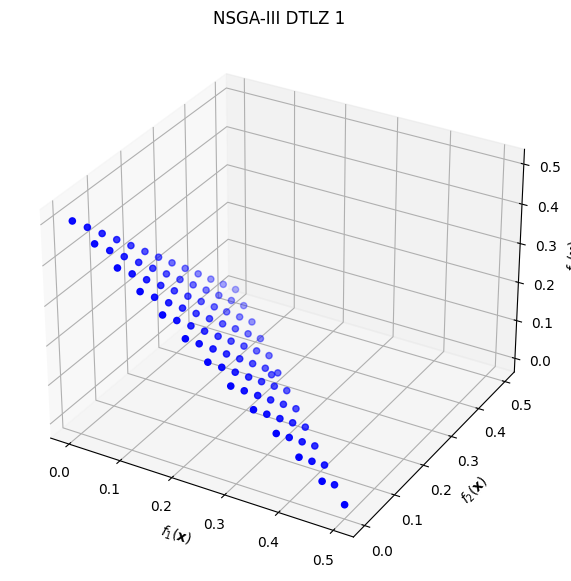

In [65]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-III DTLZ 1")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [26]:
NOBJ = 4
NDIM = 5
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 7
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 120

In [27]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz2) #Fitness Function

    #Chromosome representation Real Valued
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"

    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_dtlz2_120_500_4_5-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_dtlz2_120_500_4_5-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0649786
2  	     	0.16685  
3  	     	0.218307 
4  	     	0.277725 
5  	     	0.354763 
6  	     	0.404619 
7  	     	0.467412 
8  	     	0.507229 
9  	     	0.546891 
10 	     	0.593065 
11 	     	0.633702 
12 	     	0.677741 
13 	     	0.710474 
14 	     	0.746428 
15 	     	0.792965 
16 	     	0.859272 
17 	     	0.924842 
18 	     	0.994779 
19 	     	1.02909  
20 	     	1.07003  
21 	     	1.11685  
22 	     	1.15817  
23 	     	1.20716  
24 	     	1.24354  
25 	     	1.28658  
26 	     	1.32708  
27 	     	1.36655  
28 	     	1.43047  
29 	     	1.48811  
30 	     	1.52805  
31 	     	1.56661  
32 	     	1.60578  
33 	     	1.64436  
34 	     	1.69149  
35 	     	1.72691  
36 	     	1.76785  
37 	     	1.81714  
38 	     	1.86826  
39 	     	1.91774  
40 	     	1.95869  
41 	     	1.99743  
42 	     	2.03156  
43 	     	2.06757  
44 	     	2.10851  
45 	     	2.1506   
46 	     	2.19467  
47 	     	2.23248  
48 	     	2.27586  
49 	    

416	     	18.5973  
417	     	18.6288  
418	     	18.6751  
419	     	18.7165  
420	     	18.7547  
421	     	18.7965  
422	     	18.848   
423	     	18.8926  
424	     	18.9323  
425	     	18.9709  
426	     	19.0288  
427	     	19.0724  
428	     	19.1213  
429	     	19.1707  
430	     	19.2258  
431	     	19.2725  
432	     	19.3175  
433	     	19.3666  
434	     	19.4207  
435	     	19.4778  
436	     	19.5266  
437	     	19.5792  
438	     	19.6289  
439	     	19.6793  
440	     	19.7257  
441	     	19.7934  
442	     	19.8417  
443	     	19.8823  
444	     	19.9275  
445	     	19.9679  
446	     	20.0086  
447	     	20.0457  
448	     	20.0913  
449	     	20.1437  
450	     	20.2312  
451	     	20.3132  
452	     	20.4044  
453	     	20.4484  
454	     	20.4979  
455	     	20.5428  
456	     	20.5914  
457	     	20.6245  
458	     	20.6675  
459	     	20.7094  
460	     	20.7525  
461	     	20.7916  
462	     	20.8457  
463	     	20.8857  
464	     	20.9702  
465	     	21.0159  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.141113 
5  	     	0.181117 
6  	     	0.222117 
7  	     	0.277749 
8  	     	0.319863 
9  	     	0.352705 
10 	     	0.393052 
11 	     	0.432081 
12 	     	0.477789 
13 	     	0.513164 
14 	     	0.552816 
15 	     	0.600066 
16 	     	0.644123 
17 	     	0.682127 
18 	     	0.721254 
19 	     	0.781919 
20 	     	0.833691 
21 	     	0.885687 
22 	     	0.932617 
23 	     	1.0054   
24 	     	1.05462  
25 	     	1.11096  
26 	     	1.15576  
27 	     	1.20267  
28 	     	1.24513  
29 	     	1.29995  
30 	     	1.34974  
31 	     	1.40552  
32 	     	1.46356  
33 	     	1.5135   
34 	     	1.56     
35 	     	1.59975  
36 	     	1.64444  
37 	     	1.68161  
38 	     	1.72961  
39 	     	1.79351  
40 	     	1.82992  
41 	     	1.87124  
42 	     	1.91961  
43 	     	1.96161  
44 	     	2.00356  
45 	     	2.04449  
46 	     	2.08263  
47 	     	2.12767  
48 	     	2.17036  
49 	     	2.21552  
50 	     	2.266    
51 	     	2.31164  
52 	     	2.34961  
53 	     	2.39368  


421	     	18.8636  
422	     	18.9106  
423	     	18.9466  
424	     	18.9821  
425	     	19.0197  
426	     	19.0614  
427	     	19.1108  
428	     	19.1528  
429	     	19.201   
430	     	19.2419  
431	     	19.2829  
432	     	19.3129  
433	     	19.3612  
434	     	19.4019  
435	     	19.4414  
436	     	19.4748  
437	     	19.5119  
438	     	19.5531  
439	     	19.5961  
440	     	19.6326  
441	     	19.6787  
442	     	19.7229  
443	     	19.7607  
444	     	19.7927  
445	     	19.8274  
446	     	19.8631  
447	     	19.8996  
448	     	19.9339  
449	     	19.9754  
450	     	20.0143  
451	     	20.0435  
452	     	20.0818  
453	     	20.1117  
454	     	20.1596  
455	     	20.2007  
456	     	20.2327  
457	     	20.2748  
458	     	20.3087  
459	     	20.3478  
460	     	20.3821  
461	     	20.4326  
462	     	20.4705  
463	     	20.5131  
464	     	20.553   
465	     	20.5936  
466	     	20.6341  
467	     	20.6758  
468	     	20.7126  
469	     	20.7531  
470	     	20.7979  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 3
gen	evals	Tiempo   
1  	     	0.0216296
2  	     	0.0656455
3  	     	0.0930295
4  	     	0.123848 
5  	     	0.165654 
6  	     	0.203029 
7  	     	0.244466 
8  	     	0.29201  
9  	     	0.333309 
10 	     	0.371936 
11 	     	0.411419 
12 	     	0.452196 
13 	     	0.492925 
14 	     	0.53062  
15 	     	0.571678 
16 	     	0.61168  
17 	     	0.654609 
18 	     	0.692787 
19 	     	0.734461 
20 	     	0.772919 
21 	     	0.82292  
22 	     	0.867597 
23 	     	0.903061 
24 	     	0.944431 
25 	     	0.989443 
26 	     	1.02759  
27 	     	1.07304  
28 	     	1.11218  
29 	     	1.16371  
30 	     	1.20282  
31 	     	1.25367  
32 	     	1.29798  
33 	     	1.35535  
34 	     	1.40677  
35 	     	1.46507  
36 	     	1.50658  
37 	     	1.54741  
38 	     	1.58934  
39 	     	1.62823  
40 	     	1.68828  
41 	     	1.73443  
42 	     	1.77541  
43 	     	1.81753  
44 	     	1.84399  
45 	     	1.8871   
46 	     	1.9261   
47 	     	1.96557  
48 	     	2.00094  
49 	    

415	     	17.3771  
416	     	17.4205  
417	     	17.4686  
418	     	17.5091  
419	     	17.5507  
420	     	17.588   
421	     	17.6242  
422	     	17.6616  
423	     	17.6971  
424	     	17.7344  
425	     	17.7769  
426	     	17.817   
427	     	17.8528  
428	     	17.8925  
429	     	17.9364  
430	     	17.9775  
431	     	18.0284  
432	     	18.0727  
433	     	18.1127  
434	     	18.1517  
435	     	18.1906  
436	     	18.223   
437	     	18.2669  
438	     	18.3106  
439	     	18.3507  
440	     	18.3844  
441	     	18.4318  
442	     	18.4705  
443	     	18.5036  
444	     	18.5527  
445	     	18.5928  
446	     	18.6317  
447	     	18.6718  
448	     	18.7107  
449	     	18.7488  
450	     	18.7844  
451	     	18.8237  
452	     	18.8718  
453	     	18.9075  
454	     	18.9745  
455	     	19.0182  
456	     	19.0556  
457	     	19.1033  
458	     	19.1614  
459	     	19.1984  
460	     	19.2338  
461	     	19.273   
462	     	19.3131  
463	     	19.3675  
464	     	19.4041  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.230198 
7  	     	0.283436 
8  	     	0.330222 
9  	     	0.372337 
10 	     	0.414246 
11 	     	0.463142 
12 	     	0.507544 
13 	     	0.544695 
14 	     	0.589068 
15 	     	0.624526 
16 	     	0.665048 
17 	     	0.714162 
18 	     	0.758087 
19 	     	0.795335 
20 	     	0.838844 
21 	     	0.883446 
22 	     	0.926057 
23 	     	0.972952 
24 	     	1.0143   
25 	     	1.04365  
26 	     	1.08964  
27 	     	1.14374  
28 	     	1.19248  
29 	     	1.23447  
30 	     	1.33317  
31 	     	1.39431  
32 	     	1.45469  
33 	     	1.60145  
34 	     	1.69121  
35 	     	1.75955  
36 	     	1.80717  
37 	     	1.85865  
38 	     	1.91546  
39 	     	1.96566  
40 	     	2.03035  
41 	     	2.19023  
42 	     	2.26     
43 	     	2.30847  
44 	     	2.34354  
45 	     	2.39609  
46 	     	2.44365  
47 	     	2.48944  
48 	     	2.53375  
49 	     	2.57325  
50 	     	2.6074   
51 	     	2.6456   
52 	     	2.6891   
53 	     	2.72367  
54 	     	2.78407  
55 	     	2.88442  


422	     	18.1636  
423	     	18.207   
424	     	18.2452  
425	     	18.2814  
426	     	18.3263  
427	     	18.365   
428	     	18.4036  
429	     	18.4473  
430	     	18.4941  
431	     	18.5432  
432	     	18.5881  
433	     	18.6233  
434	     	18.6634  
435	     	18.6986  
436	     	18.7413  
437	     	18.7844  
438	     	18.8235  
439	     	18.8634  
440	     	18.8944  
441	     	18.9274  
442	     	18.9633  
443	     	19.0058  
444	     	19.0413  
445	     	19.0781  
446	     	19.1086  
447	     	19.1476  
448	     	19.1921  
449	     	19.2243  
450	     	19.2598  
451	     	19.3104  
452	     	19.3572  
453	     	19.3938  
454	     	19.4232  
455	     	19.4634  
456	     	19.5038  
457	     	19.5425  
458	     	19.5929  
459	     	19.6244  
460	     	19.6636  
461	     	19.7034  
462	     	19.7455  
463	     	19.7825  
464	     	19.831   
465	     	19.8634  
466	     	19.9048  
467	     	19.9437  
468	     	19.9833  
469	     	20.0233  
470	     	20.0564  
471	     	20.0941  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.189976 
6  	     	0.232729 
7  	     	0.27557  
8  	     	0.316394 
9  	     	0.36445  
10 	     	0.416563 
11 	     	0.460566 
12 	     	0.507859 
13 	     	0.557355 
14 	     	0.607288 
15 	     	0.657656 
16 	     	0.70787  
17 	     	0.757286 
18 	     	0.803854 
19 	     	0.857694 
20 	     	0.896892 
21 	     	0.931671 
22 	     	0.966741 
23 	     	1.00483  
24 	     	1.0516   
25 	     	1.09341  
26 	     	1.13158  
27 	     	1.17242  
28 	     	1.21151  
29 	     	1.24689  
30 	     	1.28842  
31 	     	1.3277   
32 	     	1.37036  
33 	     	1.40802  
34 	     	1.44217  
35 	     	1.47653  
36 	     	1.51207  
37 	     	1.54905  
38 	     	1.58601  
39 	     	1.62021  
40 	     	1.65556  
41 	     	1.69486  
42 	     	1.72794  
43 	     	1.76625  
44 	     	1.79804  
45 	     	1.83903  
46 	     	1.876    
47 	     	1.92096  
48 	     	1.9611   
49 	     	2.00549  
50 	     	2.04207  
51 	     	2.08749  
52 	     	2.13235  
53 	     	2.16786  
54 	     	2.21016  


416	     	17.674   
417	     	17.7201  
418	     	17.7583  
419	     	17.7908  
420	     	17.8371  
421	     	17.8705  
422	     	17.8987  
423	     	17.9381  
424	     	17.9794  
425	     	18.0199  
426	     	18.0493  
427	     	18.0708  
428	     	18.1108  
429	     	18.1537  
430	     	18.1906  
431	     	18.2239  
432	     	18.2645  
433	     	18.3051  
434	     	18.3324  
435	     	18.3731  
436	     	18.4066  
437	     	18.4555  
438	     	18.5157  
439	     	18.5485  
440	     	18.5769  
441	     	18.6099  
442	     	18.6543  
443	     	18.6914  
444	     	18.7316  
445	     	18.7597  
446	     	18.8036  
447	     	18.8334  
448	     	18.8591  
449	     	18.8939  
450	     	18.928   
451	     	18.9536  
452	     	18.9871  
453	     	19.0206  
454	     	19.0536  
455	     	19.0884  
456	     	19.1208  
457	     	19.1537  
458	     	19.1872  
459	     	19.2197  
460	     	19.2531  
461	     	19.2878  
462	     	19.3232  
463	     	19.3587  
464	     	19.3934  
465	     	19.4537  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.0945075
4  	     	0.127361 
5  	     	0.160677 
6  	     	0.194996 
7  	     	0.228318 
8  	     	0.276376 
9  	     	0.313359 
10 	     	0.344114 
11 	     	0.377411 
12 	     	0.427393 
13 	     	0.444036 
14 	     	0.488764 
15 	     	0.528371 
16 	     	0.560675 
17 	     	0.593991 
18 	     	0.628382 
19 	     	0.660743 
20 	     	0.694105 
21 	     	0.728368 
22 	     	0.761686 
23 	     	0.794087 
24 	     	0.827363 
25 	     	0.890223 
26 	     	0.927397 
27 	     	0.960712 
28 	     	1.01276  
29 	     	1.04406  
30 	     	1.09502  
31 	     	1.12733  
32 	     	1.1564   
33 	     	1.19499  
34 	     	1.22831  
35 	     	1.26164  
36 	     	1.29391  
37 	     	1.32839  
38 	     	1.36064  
39 	     	1.394    
40 	     	1.42726  
41 	     	1.46162  
42 	     	1.49705  
43 	     	1.52826  
44 	     	1.56381  
45 	     	1.59395  
46 	     	1.62741  
47 	     	1.66065  
48 	     	1.71363  
49 	     	1.74388  
50 	     	1.77825  
51 	     	1.827    
52 	     	1.86165  


416	     	14.863   
417	     	14.8959  
418	     	14.9276  
419	     	14.9768  
420	     	15.011   
421	     	15.0443  
422	     	15.0776  
423	     	15.1109  
424	     	15.1443  
425	     	15.1777  
426	     	15.211   
427	     	15.2443  
428	     	15.2777  
429	     	15.3099  
430	     	15.3434  
431	     	15.3797  
432	     	15.4109  
433	     	15.4443  
434	     	15.4766  
435	     	15.5099  
436	     	15.563   
437	     	15.5942  
438	     	15.6275  
439	     	15.6643  
440	     	15.7257  
441	     	15.7634  
442	     	15.7942  
443	     	15.8433  
444	     	15.8779  
445	     	15.9099  
446	     	15.9442  
447	     	15.9933  
448	     	16.0275  
449	     	16.0634  
450	     	16.0943  
451	     	16.1268  
452	     	16.1609  
453	     	16.1943  
454	     	16.2276  
455	     	16.2634  
456	     	16.2942  
457	     	16.3276  
458	     	16.3634  
459	     	16.3954  
460	     	16.4285  
461	     	16.4645  
462	     	16.4943  
463	     	16.5433  
464	     	16.5766  
465	     	16.6099  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.152076 
6  	     	0.184348 
7  	     	0.221699 
8  	     	0.268757 
9  	     	0.321791 
10 	     	0.352011 
11 	     	0.385375 
12 	     	0.418683 
13 	     	0.443966 
14 	     	0.484449 
15 	     	0.522796 
16 	     	0.553971 
17 	     	0.618083 
18 	     	0.654054 
19 	     	0.685262 
20 	     	0.71785  
21 	     	0.753066 
22 	     	0.784327 
23 	     	0.834505 
24 	     	0.868733 
25 	     	0.902113 
26 	     	0.945187 
27 	     	0.983315 
28 	     	1.01872  
29 	     	1.05406  
30 	     	1.08442  
31 	     	1.1587   
32 	     	1.21033  
33 	     	1.25096  
34 	     	1.28786  
35 	     	1.33062  
36 	     	1.36937  
37 	     	1.40195  
38 	     	1.43529  
39 	     	1.46865  
40 	     	1.52099  
41 	     	1.55393  
42 	     	1.5864   
43 	     	1.61867  
44 	     	1.65895  
45 	     	1.68957  
46 	     	1.72223  
47 	     	1.75398  
48 	     	1.78529  
49 	     	1.83431  
50 	     	1.86967  
51 	     	1.90257  
52 	     	1.93528  
53 	     	1.98431  
54 	     	2.0176   


416	     	17.0766  
417	     	17.1116  
418	     	17.1496  
419	     	17.1875  
420	     	17.2316  
421	     	17.2713  
422	     	17.3045  
423	     	17.3425  
424	     	17.3846  
425	     	17.4205  
426	     	17.4596  
427	     	17.4966  
428	     	17.5296  
429	     	17.5611  
430	     	17.601   
431	     	17.6375  
432	     	17.6718  
433	     	17.7012  
434	     	17.7386  
435	     	17.7802  
436	     	17.8207  
437	     	17.8561  
438	     	17.898   
439	     	17.9396  
440	     	17.9768  
441	     	18.0183  
442	     	18.0584  
443	     	18.0946  
444	     	18.1324  
445	     	18.1755  
446	     	18.2262  
447	     	18.2607  
448	     	18.2915  
449	     	18.3276  
450	     	18.3558  
451	     	18.4009  
452	     	18.4404  
453	     	18.4794  
454	     	18.5159  
455	     	18.5789  
456	     	18.6166  
457	     	18.6598  
458	     	18.6956  
459	     	18.7345  
460	     	18.779   
461	     	18.8157  
462	     	18.8508  
463	     	18.8875  
464	     	18.9302  
465	     	18.9667  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 8
gen	evals	Tiempo   
1  	     	0.0218527
2  	     	0.0598071
3  	     	0.0972667
4  	     	0.129839 
5  	     	0.161947 
6  	     	0.197659 
7  	     	0.232651 
8  	     	0.270132 
9  	     	0.304605 
10 	     	0.336999 
11 	     	0.379366 
12 	     	0.419982 
13 	     	0.454859 
14 	     	0.492081 
15 	     	0.546621 
16 	     	0.634239 
17 	     	0.685746 
18 	     	0.733918 
19 	     	0.811174 
20 	     	0.854544 
21 	     	0.904729 
22 	     	0.965844 
23 	     	1.01736  
24 	     	1.06993  
25 	     	1.12725  
26 	     	1.18219  
27 	     	1.23378  
28 	     	1.28184  
29 	     	1.33302  
30 	     	1.38216  
31 	     	1.42635  
32 	     	1.46228  
33 	     	1.49982  
34 	     	1.53697  
35 	     	1.57682  
36 	     	1.6132   
37 	     	1.64768  
38 	     	1.69102  
39 	     	1.73313  
40 	     	1.77392  
41 	     	1.80856  
42 	     	1.86326  
43 	     	1.93902  
44 	     	1.98215  
45 	     	2.03122  
46 	     	2.08185  
47 	     	2.12614  
48 	     	2.16277  
49 	    

412	     	17.9969  
413	     	18.0411  
414	     	18.0798  
415	     	18.1249  
416	     	18.16    
417	     	18.2472  
418	     	18.2927  
419	     	18.3418  
420	     	18.3939  
421	     	18.4431  
422	     	18.4927  
423	     	18.5373  
424	     	18.5773  
425	     	18.6121  
426	     	18.6458  
427	     	18.6862  
428	     	18.7228  
429	     	18.7629  
430	     	18.8096  
431	     	18.8931  
432	     	18.9741  
433	     	19.0542  
434	     	19.125   
435	     	19.1932  
436	     	19.237   
437	     	19.2729  
438	     	19.34    
439	     	19.4077  
440	     	19.4596  
441	     	19.517   
442	     	19.552   
443	     	19.5978  
444	     	19.637   
445	     	19.6995  
446	     	19.7931  
447	     	19.8545  
448	     	19.8871  
449	     	19.9301  
450	     	19.9672  
451	     	20.004   
452	     	20.0409  
453	     	20.0668  
454	     	20.1026  
455	     	20.1415  
456	     	20.1731  
457	     	20.2086  
458	     	20.2491  
459	     	20.2897  
460	     	20.3477  
461	     	20.3907  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.239636 
7  	     	0.275265 
8  	     	0.356691 
9  	     	0.444744 
10 	     	0.530749 
11 	     	0.611643 
12 	     	0.705385 
13 	     	0.810424 
14 	     	0.890032 
15 	     	0.935513 
16 	     	0.971809 
17 	     	1.00881  
18 	     	1.04981  
19 	     	1.085    
20 	     	1.1259   
21 	     	1.16587  
22 	     	1.20522  
23 	     	1.2448   
24 	     	1.27986  
25 	     	1.31589  
26 	     	1.3565   
27 	     	1.39495  
28 	     	1.43015  
29 	     	1.46479  
30 	     	1.4952   
31 	     	1.53667  
32 	     	1.57482  
33 	     	1.61592  
34 	     	1.65676  
35 	     	1.69292  
36 	     	1.7308   
37 	     	1.76562  
38 	     	1.80792  
39 	     	1.84399  
40 	     	1.87512  
41 	     	1.93789  
42 	     	1.97484  
43 	     	2.0113   
44 	     	2.04404  
45 	     	2.07988  
46 	     	2.11804  
47 	     	2.15557  
48 	     	2.19139  
49 	     	2.22514  
50 	     	2.30133  
51 	     	2.37886  
52 	     	2.45666  
53 	     	2.52993  
54 	     	2.60854  
55 	     	2.69761  


418	     	18.2239  
419	     	18.264   
420	     	18.3025  
421	     	18.3677  
422	     	18.4158  
423	     	18.4474  
424	     	18.4909  
425	     	18.5239  
426	     	18.565   
427	     	18.6039  
428	     	18.6426  
429	     	18.6769  
430	     	18.7157  
431	     	18.7537  
432	     	18.7846  
433	     	18.8152  
434	     	18.8927  
435	     	18.9435  
436	     	18.9847  
437	     	19.016   
438	     	19.1029  
439	     	19.2062  
440	     	19.277   
441	     	19.3258  
442	     	19.3659  
443	     	19.3974  
444	     	19.4239  
445	     	19.4648  
446	     	19.5125  
447	     	19.6457  
448	     	19.703   
449	     	19.7529  
450	     	19.796   
451	     	19.8317  
452	     	19.8615  
453	     	19.8957  
454	     	19.9398  
455	     	19.9757  
456	     	20.005   
457	     	20.0588  
458	     	20.0969  
459	     	20.1296  
460	     	20.1677  
461	     	20.2056  
462	     	20.2651  
463	     	20.3059  
464	     	20.3429  
465	     	20.3769  
466	     	20.4121  
467	     	20.4457  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 10
gen	evals	Tiempo   
1  	     	0.0280168
2  	     	0.0810509
3  	     	0.114324 
4  	     	0.146929 
5  	     	0.175162 
6  	     	0.202868 
7  	     	0.247037 
8  	     	0.282862 
9  	     	0.331994 
10 	     	0.374976 
11 	     	0.453328 
12 	     	0.54959  
13 	     	0.599862 
14 	     	0.64807  
15 	     	0.6904   
16 	     	0.726905 
17 	     	0.764995 
18 	     	0.797657 
19 	     	0.835545 
20 	     	0.874136 
21 	     	0.913194 
22 	     	0.963949 
23 	     	0.997814 
24 	     	1.03215  
25 	     	1.06889  
26 	     	1.10397  
27 	     	1.15366  
28 	     	1.19766  
29 	     	1.23497  
30 	     	1.27192  
31 	     	1.31396  
32 	     	1.35089  
33 	     	1.38321  
34 	     	1.43432  
35 	     	1.46329  
36 	     	1.51488  
37 	     	1.54684  
38 	     	1.5842   
39 	     	1.6248   
40 	     	1.66387  
41 	     	1.69683  
42 	     	1.78356  
43 	     	1.83397  
44 	     	1.86437  
45 	     	1.90639  
46 	     	1.95081  
47 	     	1.99902  
48 	     	2.03399  
49 	   

412	     	17.6839  
413	     	17.7179  
414	     	17.7661  
415	     	17.8709  
416	     	17.9333  
417	     	17.9833  
418	     	18.0262  
419	     	18.0718  
420	     	18.113   
421	     	18.146   
422	     	18.1998  
423	     	18.247   
424	     	18.2832  
425	     	18.3318  
426	     	18.3743  
427	     	18.4062  
428	     	18.4404  
429	     	18.5095  
430	     	18.5573  
431	     	18.6009  
432	     	18.631   
433	     	18.671   
434	     	18.703   
435	     	18.7421  
436	     	18.789   
437	     	18.8299  
438	     	18.8607  
439	     	18.8959  
440	     	18.9309  
441	     	18.9688  
442	     	19.0051  
443	     	19.038   
444	     	19.0799  
445	     	19.1119  
446	     	19.1461  
447	     	19.1918  
448	     	19.2186  
449	     	19.2543  
450	     	19.3152  
451	     	19.3783  
452	     	19.4168  
453	     	19.4641  
454	     	19.4978  
455	     	19.5381  
456	     	19.5826  
457	     	19.6294  
458	     	19.6753  
459	     	19.783   
460	     	19.8667  
461	     	19.9226  


In [70]:
df.columns = ['f1','f2','f3','f4']
sns.pairplot(df)
plt.show()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 4 elements

In [28]:
NOBJ = 4
NDIM = 5
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 7
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 120

ref_points = tools.uniform_reference_points(NOBJ, P)

In [29]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz2) #Fitness Function
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)

    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_dtlz2_120_500_4_5-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_dtlz2_120_500_4_5-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0683351
2  	     	0.106515 
3  	     	0.143806 
4  	     	0.199957 
5  	     	0.251994 
6  	     	0.28827  
7  	     	0.312981 
8  	     	0.337368 
9  	     	0.355776 
10 	     	0.381145 
11 	     	0.403659 
12 	     	0.420175 
13 	     	0.439846 
14 	     	0.463922 
15 	     	0.495971 
16 	     	0.5286   
17 	     	0.55495  
18 	     	0.57772  
19 	     	0.602012 
20 	     	0.621387 
21 	     	0.636268 
22 	     	0.664963 
23 	     	0.686371 
24 	     	0.70591  
25 	     	0.722039 
26 	     	0.747767 
27 	     	0.767276 
28 	     	0.786184 
29 	     	0.809341 
30 	     	0.833957 
31 	     	0.855733 
32 	     	0.87785  
33 	     	0.895884 
34 	     	0.921922 
35 	     	0.939824 
36 	     	0.962438 
37 	     	0.98007  
38 	     	0.99711  
39 	     	1.01592  
40 	     	1.03712  
41 	     	1.05602  
42 	     	1.07024  
43 	     	1.0873   
44 	     	1.10696  
45 	     	1.12544  
46 	     	1.13994  
47 	     	1.16261  
48 	     	1.18296  
49 	    

418	     	9.41695  
419	     	9.46002  
420	     	9.50834  
421	     	9.54738  
422	     	9.56709  
423	     	9.58678  
424	     	9.6061   
425	     	9.62131  
426	     	9.64168  
427	     	9.6618   
428	     	9.67844  
429	     	9.7021   
430	     	9.71999  
431	     	9.74148  
432	     	9.76076  
433	     	9.77876  
434	     	9.79602  
435	     	9.81627  
436	     	9.83255  
437	     	9.85051  
438	     	9.87092  
439	     	9.88699  
440	     	9.90687  
441	     	9.92923  
442	     	9.94637  
443	     	9.9661   
444	     	9.97968  
445	     	9.99686  
446	     	10.0163  
447	     	10.0381  
448	     	10.0579  
449	     	10.0772  
450	     	10.0961  
451	     	10.1168  
452	     	10.1362  
453	     	10.1567  
454	     	10.1761  
455	     	10.1932  
456	     	10.2123  
457	     	10.2319  
458	     	10.2521  
459	     	10.2713  
460	     	10.2904  
461	     	10.3073  
462	     	10.3274  
463	     	10.3462  
464	     	10.369   
465	     	10.3957  
466	     	10.4304  
467	     	10.4509  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.117459 
8  	     	0.136846 
9  	     	0.157464 
10 	     	0.175305 
11 	     	0.19671  
12 	     	0.218373 
13 	     	0.240206 
14 	     	0.261947 
15 	     	0.280008 
16 	     	0.301261 
17 	     	0.319069 
18 	     	0.33653  
19 	     	0.357892 
20 	     	0.37512  
21 	     	0.398366 
22 	     	0.414888 
23 	     	0.435409 
24 	     	0.453576 
25 	     	0.472012 
26 	     	0.512832 
27 	     	0.565733 
28 	     	0.605686 
29 	     	0.654542 
30 	     	0.687435 
31 	     	0.706132 
32 	     	0.726515 
33 	     	0.744112 
34 	     	0.76152  
35 	     	0.780196 
36 	     	0.800065 
37 	     	0.818599 
38 	     	0.83745  
39 	     	0.854426 
40 	     	0.873662 
41 	     	0.891551 
42 	     	0.906149 
43 	     	0.931202 
44 	     	0.951506 
45 	     	0.972255 
46 	     	0.991646 
47 	     	1.01263  
48 	     	1.03073  
49 	     	1.0532   
50 	     	1.07556  
51 	     	1.09287  
52 	     	1.12212  
53 	     	1.16123  
54 	     	1.19699  
55 	     	1.23908  
56 	     	1.2831   


426	     	9.62753  
427	     	9.65739  
428	     	9.69157  
429	     	9.71823  
430	     	9.74128  
431	     	9.75702  
432	     	9.7827   
433	     	9.81836  
434	     	9.84718  
435	     	9.87296  
436	     	9.89761  
437	     	9.9252   
438	     	9.95242  
439	     	9.97719  
440	     	9.99754  
441	     	10.0183  
442	     	10.0415  
443	     	10.065   
444	     	10.082   
445	     	10.1024  
446	     	10.1221  
447	     	10.1424  
448	     	10.1641  
449	     	10.1812  
450	     	10.2078  
451	     	10.2471  
452	     	10.2726  
453	     	10.2972  
454	     	10.3293  
455	     	10.3514  
456	     	10.3681  
457	     	10.3902  
458	     	10.4111  
459	     	10.4264  
460	     	10.4425  
461	     	10.4631  
462	     	10.4824  
463	     	10.5002  
464	     	10.5331  
465	     	10.5522  
466	     	10.571   
467	     	10.587   
468	     	10.6131  
469	     	10.6312  
470	     	10.6529  
471	     	10.67    
472	     	10.6876  
473	     	10.7021  
474	     	10.7262  
475	     	10.7478  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.0805473
6  	     	0.0989165
7  	     	0.111707 
8  	     	0.130672 
9  	     	0.149878 
10 	     	0.188408 
11 	     	0.208866 
12 	     	0.229921 
13 	     	0.244811 
14 	     	0.262796 
15 	     	0.280528 
16 	     	0.306937 
17 	     	0.325348 
18 	     	0.344787 
19 	     	0.361889 
20 	     	0.37892  
21 	     	0.395072 
22 	     	0.411728 
23 	     	0.429926 
24 	     	0.449782 
25 	     	0.470012 
26 	     	0.488179 
27 	     	0.505013 
28 	     	0.522793 
29 	     	0.545052 
30 	     	0.563653 
31 	     	0.585046 
32 	     	0.605168 
33 	     	0.625976 
34 	     	0.646232 
35 	     	0.667494 
36 	     	0.68459  
37 	     	0.712738 
38 	     	0.754166 
39 	     	0.780194 
40 	     	0.807043 
41 	     	0.837537 
42 	     	0.874676 
43 	     	0.895159 
44 	     	0.919988 
45 	     	0.944948 
46 	     	0.96576  
47 	     	0.985392 
48 	     	1.00696  
49 	     	1.03099  
50 	     	1.05181  
51 	     	1.06902  
52 	     	1.08868  
53 	     	1.10492  
54 	     	1.12889  


425	     	9.16     
426	     	9.18071  
427	     	9.201    
428	     	9.22171  
429	     	9.24105  
430	     	9.26306  
431	     	9.28105  
432	     	9.2999   
433	     	9.32101  
434	     	9.34049  
435	     	9.35899  
436	     	9.37373  
437	     	9.39486  
438	     	9.41649  
439	     	9.43603  
440	     	9.45069  
441	     	9.46728  
442	     	9.48443  
443	     	9.50496  
444	     	9.52402  
445	     	9.54571  
446	     	9.56126  
447	     	9.58079  
448	     	9.60187  
449	     	9.62574  
450	     	9.6489   
451	     	9.66601  
452	     	9.68869  
453	     	9.7114   
454	     	9.72786  
455	     	9.74898  
456	     	9.76579  
457	     	9.78652  
458	     	9.80458  
459	     	9.81996  
460	     	9.84019  
461	     	9.85882  
462	     	9.8769   
463	     	9.89786  
464	     	9.91658  
465	     	9.93584  
466	     	9.95552  
467	     	9.97275  
468	     	9.99435  
469	     	10.0116  
470	     	10.0309  
471	     	10.0495  
472	     	10.0717  
473	     	10.0897  
474	     	10.1058  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.129555 
8  	     	0.150753 
9  	     	0.166804 
10 	     	0.184896 
11 	     	0.205559 
12 	     	0.224883 
13 	     	0.243793 
14 	     	0.263896 
15 	     	0.282997 
16 	     	0.297895 
17 	     	0.319165 
18 	     	0.340115 
19 	     	0.355764 
20 	     	0.381192 
21 	     	0.400202 
22 	     	0.420803 
23 	     	0.440061 
24 	     	0.459047 
25 	     	0.476078 
26 	     	0.494756 
27 	     	0.513427 
28 	     	0.529666 
29 	     	0.546126 
30 	     	0.565252 
31 	     	0.586778 
32 	     	0.606766 
33 	     	0.629771 
34 	     	0.659958 
35 	     	0.676358 
36 	     	0.693633 
37 	     	0.709121 
38 	     	0.724907 
39 	     	0.744791 
40 	     	0.770736 
41 	     	0.788034 
42 	     	0.811836 
43 	     	0.834012 
44 	     	0.856403 
45 	     	0.877178 
46 	     	0.897161 
47 	     	0.916362 
48 	     	0.937148 
49 	     	0.960004 
50 	     	0.980121 
51 	     	0.999436 
52 	     	1.01937  
53 	     	1.03591  
54 	     	1.05506  
55 	     	1.08005  
56 	     	1.09874  


426	     	9.83585  
427	     	9.85551  
428	     	9.87485  
429	     	9.88911  
430	     	9.9089   
431	     	9.92806  
432	     	9.94567  
433	     	9.96513  
434	     	9.98854  
435	     	10.0052  
436	     	10.0237  
437	     	10.04    
438	     	10.0673  
439	     	10.0908  
440	     	10.1063  
441	     	10.1288  
442	     	10.1459  
443	     	10.1661  
444	     	10.1888  
445	     	10.2258  
446	     	10.2466  
447	     	10.274   
448	     	10.295   
449	     	10.3162  
450	     	10.335   
451	     	10.3529  
452	     	10.3713  
453	     	10.3901  
454	     	10.4049  
455	     	10.4262  
456	     	10.4446  
457	     	10.4642  
458	     	10.4868  
459	     	10.5059  
460	     	10.5247  
461	     	10.5409  
462	     	10.5578  
463	     	10.578   
464	     	10.5966  
465	     	10.6161  
466	     	10.6357  
467	     	10.6498  
468	     	10.6702  
469	     	10.6917  
470	     	10.7102  
471	     	10.729   
472	     	10.7452  
473	     	10.7649  
474	     	10.7826  
475	     	10.8016  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.15706  
10 	     	0.177084 
11 	     	0.197951 
12 	     	0.217137 
13 	     	0.231683 
14 	     	0.249378 
15 	     	0.266433 
16 	     	0.286154 
17 	     	0.30248  
18 	     	0.320924 
19 	     	0.343814 
20 	     	0.361638 
21 	     	0.379132 
22 	     	0.396801 
23 	     	0.41727  
24 	     	0.434977 
25 	     	0.450399 
26 	     	0.472625 
27 	     	0.491224 
28 	     	0.510284 
29 	     	0.528102 
30 	     	0.546052 
31 	     	0.565815 
32 	     	0.580892 
33 	     	0.600506 
34 	     	0.620265 
35 	     	0.636437 
36 	     	0.656554 
37 	     	0.676352 
38 	     	0.691167 
39 	     	0.71023  
40 	     	0.725953 
41 	     	0.746248 
42 	     	0.765925 
43 	     	0.786294 
44 	     	0.805944 
45 	     	0.827185 
46 	     	0.845268 
47 	     	0.86622  
48 	     	0.884941 
49 	     	0.903217 
50 	     	0.92129  
51 	     	0.946148 
52 	     	0.978093 
53 	     	0.997435 
54 	     	1.0162   
55 	     	1.03717  
56 	     	1.05481  
57 	     	1.07712  
58 	     	1.09741  


428	     	8.91626  
429	     	8.93745  
430	     	8.96252  
431	     	8.97997  
432	     	8.99862  
433	     	9.01998  
434	     	9.03523  
435	     	9.06051  
436	     	9.07607  
437	     	9.09737  
438	     	9.11628  
439	     	9.12641  
440	     	9.14694  
441	     	9.16726  
442	     	9.18629  
443	     	9.20524  
444	     	9.2174   
445	     	9.24034  
446	     	9.25961  
447	     	9.2764   
448	     	9.30108  
449	     	9.31709  
450	     	9.33741  
451	     	9.37791  
452	     	9.42709  
453	     	9.46425  
454	     	9.48623  
455	     	9.49591  
456	     	9.51927  
457	     	9.5369   
458	     	9.56014  
459	     	9.5769   
460	     	9.59626  
461	     	9.61695  
462	     	9.63734  
463	     	9.65889  
464	     	9.684    
465	     	9.71127  
466	     	9.73689  
467	     	9.76777  
468	     	9.79605  
469	     	9.81593  
470	     	9.83726  
471	     	9.86412  
472	     	9.90078  
473	     	9.92953  
474	     	9.95412  
475	     	9.97691  
476	     	9.99812  
477	     	10.017   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 6
gen	evals	Tiempo   
1  	     	0.0205646
2  	     	0.0410142
3  	     	0.0595765
4  	     	0.079067 
5  	     	0.0969813
6  	     	0.111186 
7  	     	0.133691 
8  	     	0.14968  
9  	     	0.170044 
10 	     	0.18994  
11 	     	0.199892 
12 	     	0.220156 
13 	     	0.240129 
14 	     	0.274448 
15 	     	0.299509 
16 	     	0.323574 
17 	     	0.342994 
18 	     	0.366122 
19 	     	0.413404 
20 	     	0.439002 
21 	     	0.46731  
22 	     	0.487396 
23 	     	0.507082 
24 	     	0.522309 
25 	     	0.539251 
26 	     	0.568062 
27 	     	0.591426 
28 	     	0.617527 
29 	     	0.637244 
30 	     	0.654102 
31 	     	0.738887 
32 	     	0.800594 
33 	     	0.836927 
34 	     	0.85913  
35 	     	0.877968 
36 	     	0.899353 
37 	     	0.917061 
38 	     	0.932553 
39 	     	0.950073 
40 	     	0.970267 
41 	     	0.995846 
42 	     	1.01774  
43 	     	1.04005  
44 	     	1.05932  
45 	     	1.08106  
46 	     	1.09931  
47 	     	1.11717  
48 	     	1.13515  
49 	    

419	     	9.49326  
420	     	9.51037  
421	     	9.53301  
422	     	9.5535   
423	     	9.57398  
424	     	9.59683  
425	     	9.61461  
426	     	9.6323   
427	     	9.65009  
428	     	9.67064  
429	     	9.68999  
430	     	9.70748  
431	     	9.73213  
432	     	9.75031  
433	     	9.76926  
434	     	9.79563  
435	     	9.83627  
436	     	9.87817  
437	     	9.91938  
438	     	9.96082  
439	     	9.99931  
440	     	10.0395  
441	     	10.0793  
442	     	10.1203  
443	     	10.1506  
444	     	10.1779  
445	     	10.2033  
446	     	10.2292  
447	     	10.2711  
448	     	10.2957  
449	     	10.3232  
450	     	10.3492  
451	     	10.3703  
452	     	10.3957  
453	     	10.4208  
454	     	10.4479  
455	     	10.4701  
456	     	10.4981  
457	     	10.5191  
458	     	10.5414  
459	     	10.5712  
460	     	10.5888  
461	     	10.6053  
462	     	10.6214  
463	     	10.6391  
464	     	10.6603  
465	     	10.6823  
466	     	10.7044  
467	     	10.7291  
468	     	10.7508  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.0862038
6  	     	0.106629 
7  	     	0.124298 
8  	     	0.143435 
9  	     	0.156228 
10 	     	0.179737 
11 	     	0.19611  
12 	     	0.215476 
13 	     	0.233108 
14 	     	0.246269 
15 	     	0.266744 
16 	     	0.285315 
17 	     	0.305643 
18 	     	0.325312 
19 	     	0.345215 
20 	     	0.361947 
21 	     	0.378611 
22 	     	0.406176 
23 	     	0.432622 
24 	     	0.44654  
25 	     	0.466738 
26 	     	0.486315 
27 	     	0.503165 
28 	     	0.515277 
29 	     	0.53637  
30 	     	0.555165 
31 	     	0.574468 
32 	     	0.586637 
33 	     	0.6063   
34 	     	0.629647 
35 	     	0.646222 
36 	     	0.66729  
37 	     	0.68582  
38 	     	0.706352 
39 	     	0.72854  
40 	     	0.754139 
41 	     	0.775462 
42 	     	0.793414 
43 	     	0.813166 
44 	     	0.828729 
45 	     	0.845938 
46 	     	0.866602 
47 	     	0.878521 
48 	     	0.903412 
49 	     	0.925177 
50 	     	0.945637 
51 	     	0.955174 
52 	     	0.979535 
53 	     	0.996117 
54 	     	1.0157   


425	     	9.01146  
426	     	9.02811  
427	     	9.04665  
428	     	9.06527  
429	     	9.08218  
430	     	9.1057   
431	     	9.13689  
432	     	9.17557  
433	     	9.19752  
434	     	9.21889  
435	     	9.24151  
436	     	9.26116  
437	     	9.27887  
438	     	9.30205  
439	     	9.31977  
440	     	9.34532  
441	     	9.36764  
442	     	9.38511  
443	     	9.39966  
444	     	9.43558  
445	     	9.47038  
446	     	9.51281  
447	     	9.53835  
448	     	9.56095  
449	     	9.57887  
450	     	9.60337  
451	     	9.62904  
452	     	9.65055  
453	     	9.66545  
454	     	9.69326  
455	     	9.71987  
456	     	9.75134  
457	     	9.77705  
458	     	9.79344  
459	     	9.81013  
460	     	9.82803  
461	     	9.84589  
462	     	9.86627  
463	     	9.8846   
464	     	9.89898  
465	     	9.91965  
466	     	9.94061  
467	     	9.96144  
468	     	9.98215  
469	     	10.0085  
470	     	10.0289  
471	     	10.049   
472	     	10.0676  
473	     	10.0894  
474	     	10.1097  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 8
gen	evals	Tiempo   
1  	     	0.0138464
2  	     	0.0326905
3  	     	0.0458503
4  	     	0.0639606
5  	     	0.0866435
6  	     	0.11237  
7  	     	0.126716 
8  	     	0.14528  
9  	     	0.163417 
10 	     	0.182017 
11 	     	0.199457 
12 	     	0.213666 
13 	     	0.236886 
14 	     	0.253748 
15 	     	0.272395 
16 	     	0.294271 
17 	     	0.313283 
18 	     	0.331764 
19 	     	0.351525 
20 	     	0.367167 
21 	     	0.388104 
22 	     	0.404541 
23 	     	0.421688 
24 	     	0.438139 
25 	     	0.452742 
26 	     	0.473925 
27 	     	0.49649  
28 	     	0.516929 
29 	     	0.53682  
30 	     	0.559241 
31 	     	0.576855 
32 	     	0.595257 
33 	     	0.617068 
34 	     	0.633841 
35 	     	0.65359  
36 	     	0.67388  
37 	     	0.695589 
38 	     	0.71898  
39 	     	0.736772 
40 	     	0.75279  
41 	     	0.780717 
42 	     	0.816868 
43 	     	0.854896 
44 	     	0.895513 
45 	     	0.93938  
46 	     	0.981492 
47 	     	1.01722  
48 	     	1.06143  
49 	    

413	     	9.5565   
414	     	9.57833  
415	     	9.59556  
416	     	9.6128   
417	     	9.63234  
418	     	9.65182  
419	     	9.66916  
420	     	9.68478  
421	     	9.70407  
422	     	9.71775  
423	     	9.73372  
424	     	9.75273  
425	     	9.77105  
426	     	9.78716  
427	     	9.80749  
428	     	9.83394  
429	     	9.87346  
430	     	9.91247  
431	     	9.94721  
432	     	9.96358  
433	     	9.98389  
434	     	10.0037  
435	     	10.024   
436	     	10.0406  
437	     	10.0573  
438	     	10.0762  
439	     	10.0989  
440	     	10.1163  
441	     	10.1337  
442	     	10.1525  
443	     	10.1738  
444	     	10.1991  
445	     	10.2369  
446	     	10.2818  
447	     	10.3059  
448	     	10.3357  
449	     	10.3645  
450	     	10.3839  
451	     	10.4167  
452	     	10.4569  
453	     	10.4949  
454	     	10.5376  
455	     	10.5736  
456	     	10.6128  
457	     	10.6528  
458	     	10.6916  
459	     	10.7316  
460	     	10.7736  
461	     	10.8137  
462	     	10.8518  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.117399 
6  	     	0.134744 
7  	     	0.150788 
8  	     	0.171097 
9  	     	0.189584 
10 	     	0.204702 
11 	     	0.224855 
12 	     	0.24786  
13 	     	0.268791 
14 	     	0.284862 
15 	     	0.300443 
16 	     	0.3199   
17 	     	0.339531 
18 	     	0.358897 
19 	     	0.374986 
20 	     	0.395193 
21 	     	0.412516 
22 	     	0.430607 
23 	     	0.445078 
24 	     	0.469773 
25 	     	0.492088 
26 	     	0.513475 
27 	     	0.533075 
28 	     	0.555911 
29 	     	0.570608 
30 	     	0.595079 
31 	     	0.611716 
32 	     	0.630781 
33 	     	0.661956 
34 	     	0.709031 
35 	     	0.740745 
36 	     	0.791109 
37 	     	0.82065  
38 	     	0.840954 
39 	     	0.872863 
40 	     	0.91997  
41 	     	0.939623 
42 	     	0.958912 
43 	     	0.978704 
44 	     	0.995414 
45 	     	1.0118   
46 	     	1.0301   
47 	     	1.04987  
48 	     	1.07004  
49 	     	1.08067  
50 	     	1.10096  
51 	     	1.11961  
52 	     	1.14093  
53 	     	1.16071  
54 	     	1.18004  


423	     	9.43741  
424	     	9.45834  
425	     	9.4776   
426	     	9.49781  
427	     	9.51142  
428	     	9.53595  
429	     	9.55066  
430	     	9.57365  
431	     	9.59941  
432	     	9.61867  
433	     	9.63513  
434	     	9.65873  
435	     	9.68063  
436	     	9.70039  
437	     	9.72043  
438	     	9.73984  
439	     	9.76314  
440	     	9.78226  
441	     	9.79957  
442	     	9.82053  
443	     	9.83305  
444	     	9.85166  
445	     	9.87946  
446	     	9.89978  
447	     	9.9216   
448	     	9.94445  
449	     	9.9618   
450	     	9.98173  
451	     	9.99946  
452	     	10.0247  
453	     	10.0447  
454	     	10.0695  
455	     	10.0913  
456	     	10.1124  
457	     	10.1346  
458	     	10.1559  
459	     	10.1708  
460	     	10.1961  
461	     	10.2208  
462	     	10.2888  
463	     	10.3116  
464	     	10.3419  
465	     	10.3721  
466	     	10.3996  
467	     	10.4189  
468	     	10.4397  
469	     	10.4573  
470	     	10.4797  
471	     	10.4946  
472	     	10.5196  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.177251 
11 	     	0.200789 
12 	     	0.218342 
13 	     	0.234278 
14 	     	0.254395 
15 	     	0.274968 
16 	     	0.295636 
17 	     	0.313683 
18 	     	0.331612 
19 	     	0.345386 
20 	     	0.367052 
21 	     	0.383365 
22 	     	0.403029 
23 	     	0.423369 
24 	     	0.44227  
25 	     	0.4637   
26 	     	0.483165 
27 	     	0.504685 
28 	     	0.521215 
29 	     	0.55434  
30 	     	0.595344 
31 	     	0.641515 
32 	     	0.673069 
33 	     	0.701434 
34 	     	0.72325  
35 	     	0.746744 
36 	     	0.769408 
37 	     	0.80516  
38 	     	0.831313 
39 	     	0.852438 
40 	     	0.869752 
41 	     	0.889409 
42 	     	0.907868 
43 	     	0.928752 
44 	     	0.948199 
45 	     	0.970529 
46 	     	0.991178 
47 	     	1.00934  
48 	     	1.02894  
49 	     	1.05031  
50 	     	1.06941  
51 	     	1.09346  
52 	     	1.11445  
53 	     	1.13335  
54 	     	1.15108  
55 	     	1.17019  
56 	     	1.18452  
57 	     	1.20382  
58 	     	1.22543  
59 	     	1.24557  


421	     	9.71577  
422	     	9.73424  
423	     	9.754    
424	     	9.77331  
425	     	9.78361  
426	     	9.80483  
427	     	9.82778  
428	     	9.85333  
429	     	9.8704   
430	     	9.88416  
431	     	9.90449  
432	     	9.93134  
433	     	9.95333  
434	     	9.96336  
435	     	9.99097  
436	     	10.0034  
437	     	10.0278  
438	     	10.0445  
439	     	10.0631  
440	     	10.1236  
441	     	10.1585  
442	     	10.1867  
443	     	10.2166  
444	     	10.2384  
445	     	10.2633  
446	     	10.2898  
447	     	10.3144  
448	     	10.3377  
449	     	10.3635  
450	     	10.3833  
451	     	10.411   
452	     	10.4343  
453	     	10.4631  
454	     	10.4853  
455	     	10.5133  
456	     	10.5345  
457	     	10.5677  
458	     	10.6119  
459	     	10.6312  
460	     	10.6485  
461	     	10.6731  
462	     	10.6945  
463	     	10.7141  
464	     	10.7344  
465	     	10.7567  
466	     	10.7777  
467	     	10.7951  
468	     	10.8166  
469	     	10.8342  
470	     	10.8705  


In [30]:
NOBJ = 6
NDIM = 6
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 7
# H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 252

In [31]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz3) #Fitness Function

    #Chromosome representation Real Valued
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_dtlz3_252_500_6_6-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_dtlz3_252_500_6_6-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo 
1  	     	0.26393
2  	     	0.560352
3  	     	0.729253
4  	     	0.929362
5  	     	1.07831 
6  	     	1.21832 
7  	     	1.34669 
8  	     	1.46269 
9  	     	1.67621 
10 	     	1.91602 
11 	     	2.207   
12 	     	2.47521 
13 	     	2.63695 
14 	     	2.79628 
15 	     	3.02299 
16 	     	3.19598 
17 	     	3.51417 
18 	     	3.69527 
19 	     	3.85706 
20 	     	4.02418 
21 	     	4.17918 
22 	     	4.33995 
23 	     	4.68591 
24 	     	4.88687 
25 	     	5.07991 
26 	     	5.30129 
27 	     	5.48094 
28 	     	5.63892 
29 	     	5.79606 
30 	     	6.03524 
31 	     	6.22134 
32 	     	6.43879 
33 	     	6.60584 
34 	     	6.77797 
35 	     	6.97912 
36 	     	7.23463 
37 	     	7.41585 
38 	     	7.56933 
39 	     	7.72482 
40 	     	7.88487 
41 	     	8.06514 
42 	     	8.23579 
43 	     	8.4409  
44 	     	8.60315 
45 	     	8.76123 
46 	     	8.9169  
47 	     	9.073   
48 	     	9.31122 
49 	     	9.52884 
50 	     	9.697   
51 	     	9.86704 
52

432	     	83.811  
433	     	84.0365 
434	     	84.2088 
435	     	84.3799 
436	     	84.5214 
437	     	84.6789 
438	     	84.9395 
439	     	85.1116 
440	     	85.2639 
441	     	85.4307 
442	     	85.5647 
443	     	85.7606 
444	     	85.9088 
445	     	86.064  
446	     	86.2746 
447	     	86.4475 
448	     	86.5768 
449	     	86.73   
450	     	86.9763 
451	     	87.2266 
452	     	87.4645 
453	     	87.6535 
454	     	87.8164 
455	     	88.0655 
456	     	88.2737 
457	     	88.4655 
458	     	88.6179 
459	     	88.7808 
460	     	88.9523 
461	     	89.1044 
462	     	89.3154 
463	     	89.4618 
464	     	89.6305 
465	     	89.7877 
466	     	89.9728 
467	     	90.1596 
468	     	90.3186 
469	     	90.4674 
470	     	90.6175 
471	     	90.8005 
472	     	91.0016 
473	     	91.1455 
474	     	91.3844 
475	     	91.5237 
476	     	91.666  
477	     	91.9527 
478	     	92.1085 
479	     	92.2884 
480	     	92.4374 
481	     	92.5804 
482	     	92.7247 
483	     	92.9268 
484	     	93

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 2
gen	evals	Tiempo  
1  	     	0.113996
2  	     	0.329112
3  	     	0.475642
4  	     	0.62229 
5  	     	0.772187
6  	     	0.898054
7  	     	1.03017 
8  	     	1.17202 
9  	     	1.33804 
10 	     	1.58629 
11 	     	1.72915 
12 	     	1.90843 
13 	     	2.06139 
14 	     	2.23878 
15 	     	2.49015 
16 	     	2.64208 
17 	     	2.80326 
18 	     	2.99036 
19 	     	3.17615 
20 	     	3.33929 
21 	     	3.62304 
22 	     	3.79114 
23 	     	4.03713 
24 	     	4.29263 
25 	     	4.4862  
26 	     	4.66435 
27 	     	4.86124 
28 	     	5.01674 
29 	     	5.17213 
30 	     	5.38425 
31 	     	5.55629 
32 	     	5.6989  
33 	     	5.8653  
34 	     	6.02173 
35 	     	6.18194 
36 	     	6.33663 
37 	     	6.52258 
38 	     	6.70529 
39 	     	6.86886 
40 	     	7.02033 
41 	     	7.24227 
42 	     	7.45131 
43 	     	7.65298 
44 	     	7.84032 
45 	     	8.00374 
46 	     	8.18239 
47 	     	8.36663 
48 	     	8.54063 
49 	     	8.71526 
50 	     	8.94222 
51 	     	9.10624 


431	     	80.02   
432	     	80.2924 
433	     	80.4753 
434	     	80.6523 
435	     	80.787  
436	     	81.0457 
437	     	81.2558 
438	     	81.4236 
439	     	81.6133 
440	     	81.8023 
441	     	81.9576 
442	     	82.1033 
443	     	82.2402 
444	     	82.4402 
445	     	82.6564 
446	     	82.8166 
447	     	82.9814 
448	     	83.1523 
449	     	83.3202 
450	     	83.5038 
451	     	83.6779 
452	     	83.8424 
453	     	84.046  
454	     	84.2141 
455	     	84.3461 
456	     	84.4835 
457	     	84.6651 
458	     	84.8171 
459	     	84.9722 
460	     	85.1309 
461	     	85.275  
462	     	85.451  
463	     	85.6422 
464	     	85.7989 
465	     	85.9861 
466	     	86.172  
467	     	86.3234 
468	     	86.5749 
469	     	86.7466 
470	     	86.8912 
471	     	87.0345 
472	     	87.1733 
473	     	87.3571 
474	     	87.5085 
475	     	87.656  
476	     	87.8962 
477	     	88.0514 
478	     	88.1947 
479	     	88.3446 
480	     	88.5061 
481	     	88.6588 
482	     	88.8035 
483	     	88

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0935321
2  	     	0.397537 
3  	     	0.623096 
4  	     	0.801174 
5  	     	0.96049  
6  	     	1.09546  
7  	     	1.23212  
8  	     	1.40181  
9  	     	1.56558  
10 	     	1.81037  
11 	     	2.11175  
12 	     	2.32212  
13 	     	2.49493  
14 	     	2.89118  
15 	     	3.17092  
16 	     	3.34114  
17 	     	3.5001   
18 	     	3.67221  
19 	     	3.87013  
20 	     	4.03719  
21 	     	4.21041  
22 	     	4.39596  
23 	     	4.57624  
24 	     	4.7663   
25 	     	4.92613  
26 	     	5.08517  
27 	     	5.23295  
28 	     	5.41302  
29 	     	5.59407  
30 	     	5.89519  
31 	     	6.07624  
32 	     	6.24535  
33 	     	6.5111   
34 	     	6.84055  
35 	     	7.02253  
36 	     	7.36595  
37 	     	7.61855  
38 	     	7.7897   
39 	     	7.95701  
40 	     	8.11911  
41 	     	8.28531  
42 	     	8.44224  
43 	     	8.63814  
44 	     	8.81317  
45 	     	8.98106  
46 	     	9.13087  
47 	     	9.33456  
48 	     	9.54698  
49 	     	9.71216  


410	     	79.2643  
411	     	79.5987  
412	     	79.7496  
413	     	79.9071  
414	     	80.1328  
415	     	80.3589  
416	     	80.7085  
417	     	80.8722  
418	     	81.0349  
419	     	81.1987  
420	     	81.3935  
421	     	81.5913  
422	     	81.8782  
423	     	82.0307  
424	     	82.2192  
425	     	82.4367  
426	     	82.7308  
427	     	82.8712  
428	     	83.0142  
429	     	83.1658  
430	     	83.3329  
431	     	83.491   
432	     	83.6696  
433	     	83.8598  
434	     	84.022   
435	     	84.171   
436	     	84.4504  
437	     	84.6021  
438	     	84.8008  
439	     	85.0074  
440	     	85.2006  
441	     	85.381   
442	     	85.5501  
443	     	85.7218  
444	     	85.8898  
445	     	86.0306  
446	     	86.23    
447	     	86.3986  
448	     	86.5711  
449	     	86.7416  
450	     	86.8919  
451	     	87.0615  
452	     	87.2019  
453	     	87.3507  
454	     	87.532   
455	     	87.7209  
456	     	87.8706  
457	     	88.035   
458	     	88.272   
459	     	88.4508  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 4
gen	evals	Tiempo  
1  	     	0.211841
2  	     	0.561694
3  	     	0.721781
4  	     	0.866533
5  	     	1.00536 
6  	     	1.20821 
7  	     	1.49041 
8  	     	1.66128 
9  	     	1.83365 
10 	     	1.98157 
11 	     	2.28116 
12 	     	2.56175 
13 	     	2.88148 
14 	     	3.08147 
15 	     	3.23432 
16 	     	3.45216 
17 	     	3.78551 
18 	     	4.00222 
19 	     	4.28119 
20 	     	4.44962 
21 	     	4.60138 
22 	     	4.75538 
23 	     	4.93448 
24 	     	5.09945 
25 	     	5.24934 
26 	     	5.50147 
27 	     	5.6851  
28 	     	5.91136 
29 	     	6.0745  
30 	     	6.41171 
31 	     	6.63452 
32 	     	6.86362 
33 	     	7.0516  
34 	     	7.21073 
35 	     	7.36816 
36 	     	7.56567 
37 	     	7.78567 
38 	     	7.99943 
39 	     	8.23255 
40 	     	8.45632 
41 	     	8.62967 
42 	     	8.81117 
43 	     	8.97018 
44 	     	9.12012 
45 	     	9.28852 
46 	     	9.44857 
47 	     	9.6116  
48 	     	9.76836 
49 	     	9.94143 
50 	     	10.1014 
51 	     	10.2503 


431	     	82.9591 
432	     	83.1417 
433	     	83.3242 
434	     	83.5143 
435	     	83.7356 
436	     	83.9152 
437	     	84.1259 
438	     	84.3861 
439	     	84.6435 
440	     	84.8441 
441	     	85.0514 
442	     	85.2054 
443	     	85.3465 
444	     	85.5811 
445	     	85.7489 
446	     	85.9294 
447	     	86.0946 
448	     	86.2504 
449	     	86.4794 
450	     	86.7502 
451	     	86.9414 
452	     	87.0864 
453	     	87.2299 
454	     	87.3891 
455	     	87.5841 
456	     	87.7705 
457	     	87.9352 
458	     	88.0831 
459	     	88.2316 
460	     	88.394  
461	     	88.5418 
462	     	88.7354 
463	     	88.9953 
464	     	89.135  
465	     	89.2913 
466	     	89.4499 
467	     	89.5932 
468	     	89.7523 
469	     	89.9013 
470	     	90.0553 
471	     	90.2289 
472	     	90.3611 
473	     	90.5001 
474	     	90.6712 
475	     	90.8294 
476	     	90.9914 
477	     	91.16   
478	     	91.3289 
479	     	91.5299 
480	     	91.6748 
481	     	91.8131 
482	     	91.9853 
483	     	92

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 5
gen	evals	Tiempo  
1  	     	0.135551
2  	     	0.373011
3  	     	0.551941
4  	     	0.722481
5  	     	0.862001
6  	     	1.07539 
7  	     	1.21092 
8  	     	1.32981 
9  	     	1.50098 
10 	     	1.66797 
11 	     	1.82865 
12 	     	1.99791 
13 	     	2.22632 
14 	     	2.41403 
15 	     	2.58156 
16 	     	2.82637 
17 	     	3.01547 
18 	     	3.2385  
19 	     	3.42577 
20 	     	3.59825 
21 	     	3.85323 
22 	     	4.12104 
23 	     	4.33932 
24 	     	4.51616 
25 	     	4.6709  
26 	     	4.86103 
27 	     	5.07193 
28 	     	5.34585 
29 	     	5.51614 
30 	     	5.84126 
31 	     	6.0863  
32 	     	6.26925 
33 	     	6.44307 
34 	     	6.60368 
35 	     	6.77298 
36 	     	7.0046  
37 	     	7.29879 
38 	     	7.47191 
39 	     	7.79381 
40 	     	7.96875 
41 	     	8.18216 
42 	     	8.34775 
43 	     	8.52593 
44 	     	8.68099 
45 	     	8.88618 
46 	     	9.06163 
47 	     	9.22101 
48 	     	9.48382 
49 	     	9.77779 
50 	     	10.006  
51 	     	10.1722 


432	     	82.5366 
433	     	82.6693 
434	     	82.8362 
435	     	82.9914 
436	     	83.1565 
437	     	83.3217 
438	     	83.4841 
439	     	83.6857 
440	     	83.8548 
441	     	84.0229 
442	     	84.1834 
443	     	84.4375 
444	     	84.7124 
445	     	84.8635 
446	     	85.031  
447	     	85.2485 
448	     	85.4038 
449	     	85.6904 
450	     	85.8257 
451	     	86.0284 
452	     	86.2316 
453	     	86.385  
454	     	86.5466 
455	     	86.687  
456	     	86.8377 
457	     	87.0009 
458	     	87.1617 
459	     	87.3085 
460	     	87.4806 
461	     	87.6284 
462	     	87.7871 
463	     	87.9684 
464	     	88.1474 
465	     	88.3044 
466	     	88.4825 
467	     	88.6526 
468	     	88.7799 
469	     	88.9415 
470	     	89.1625 
471	     	89.3375 
472	     	89.4905 
473	     	89.7172 
474	     	89.8684 
475	     	90.0011 
476	     	90.1517 
477	     	90.3497 
478	     	90.5604 
479	     	90.7364 
480	     	90.9025 
481	     	91.0517 
482	     	91.2848 
483	     	91.5544 
484	     	91

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 6
gen	evals	Tiempo  
1  	     	0.105744
2  	     	0.458716
3  	     	0.63061 
4  	     	0.796781
5  	     	1.04085 
6  	     	1.25779 
7  	     	1.40279 
8  	     	1.71554 
9  	     	1.87479 
10 	     	2.09429 
11 	     	2.32612 
12 	     	2.53199 
13 	     	2.8076  
14 	     	3.09464 
15 	     	3.29389 
16 	     	3.46505 
17 	     	3.62546 
18 	     	3.86502 
19 	     	4.14668 
20 	     	4.44497 
21 	     	4.62511 
22 	     	4.81413 
23 	     	4.98194 
24 	     	5.22393 
25 	     	5.41918 
26 	     	5.75309 
27 	     	5.90887 
28 	     	6.09851 
29 	     	6.31785 
30 	     	6.50585 
31 	     	6.68524 
32 	     	6.96522 
33 	     	7.12595 
34 	     	7.27972 
35 	     	7.44443 
36 	     	7.62485 
37 	     	7.79123 
38 	     	7.95704 
39 	     	8.29044 
40 	     	8.44708 
41 	     	8.61017 
42 	     	8.85307 
43 	     	9.02494 
44 	     	9.24939 
45 	     	9.56224 
46 	     	9.78795 
47 	     	9.9598  
48 	     	10.1984 
49 	     	10.3838 
50 	     	10.56   
51 	     	10.825  


432	     	84.2536 
433	     	84.4051 
434	     	84.5539 
435	     	84.702  
436	     	84.925  
437	     	85.1037 
438	     	85.3049 
439	     	85.5249 
440	     	85.6645 
441	     	85.8248 
442	     	86.0618 
443	     	86.2849 
444	     	86.468  
445	     	86.644  
446	     	86.8134 
447	     	86.9537 
448	     	87.1051 
449	     	87.2539 
450	     	87.4237 
451	     	87.6051 
452	     	87.7416 
453	     	87.9086 
454	     	88.124  
455	     	88.2679 
456	     	88.4188 
457	     	88.6022 
458	     	88.7528 
459	     	88.8935 
460	     	89.043  
461	     	89.204  
462	     	89.3783 
463	     	89.5473 
464	     	89.8351 
465	     	89.9857 
466	     	90.1301 
467	     	90.2819 
468	     	90.4289 
469	     	90.705  
470	     	90.8538 
471	     	91.0049 
472	     	91.1577 
473	     	91.2977 
474	     	91.4942 
475	     	91.7867 
476	     	92.0259 
477	     	92.1745 
478	     	92.3653 
479	     	92.599  
480	     	92.7535 
481	     	92.9176 
482	     	93.0558 
483	     	93.2086 
484	     	93

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 7
gen	evals	Tiempo   
1  	     	0.0907469
2  	     	0.307611 
3  	     	0.518828 
4  	     	0.891809 
5  	     	1.02402  
6  	     	1.13406  
7  	     	1.32886  
8  	     	1.57095  
9  	     	1.76788  
10 	     	1.90542  
11 	     	2.06179  
12 	     	2.22772  
13 	     	2.38241  
14 	     	2.55879  
15 	     	2.71775  
16 	     	2.89284  
17 	     	3.14245  
18 	     	3.29767  
19 	     	3.48789  
20 	     	3.63571  
21 	     	3.78799  
22 	     	4.05682  
23 	     	4.21673  
24 	     	4.46698  
25 	     	4.70753  
26 	     	4.90766  
27 	     	5.18397  
28 	     	5.44909  
29 	     	5.69199  
30 	     	5.88103  
31 	     	6.06552  
32 	     	6.23192  
33 	     	6.39393  
34 	     	6.60377  
35 	     	6.79235  
36 	     	6.96288  
37 	     	7.18787  
38 	     	7.40877  
39 	     	7.68663  
40 	     	8.05294  
41 	     	8.3483   
42 	     	8.56805  
43 	     	8.71687  
44 	     	8.88842  
45 	     	9.05969  
46 	     	9.32309  
47 	     	9.55306  
48 	     	9.75811  
49 	    

411	     	80.7529  
412	     	80.9089  
413	     	81.0837  
414	     	81.2387  
415	     	81.3939  
416	     	81.5547  
417	     	81.708   
418	     	81.8696  
419	     	82.0197  
420	     	82.1678  
421	     	82.3217  
422	     	82.4883  
423	     	82.6267  
424	     	82.7746  
425	     	82.9117  
426	     	83.0928  
427	     	83.2479  
428	     	83.4198  
429	     	83.5859  
430	     	83.7269  
431	     	84.0389  
432	     	84.3326  
433	     	84.6802  
434	     	84.9977  
435	     	85.5307  
436	     	85.8399  
437	     	86.1889  
438	     	86.563   
439	     	86.95    
440	     	87.2026  
441	     	87.4298  
442	     	87.7028  
443	     	87.9181  
444	     	88.1349  
445	     	88.373   
446	     	88.6116  
447	     	88.8589  
448	     	89.1361  
449	     	89.3985  
450	     	89.6857  
451	     	89.9218  
452	     	90.1542  
453	     	90.3809  
454	     	90.6278  
455	     	90.8669  
456	     	91.1508  
457	     	91.4166  
458	     	91.652   
459	     	91.8726  
460	     	92.1032  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 8
gen	evals	Tiempo  
1  	     	0.100464
2  	     	0.359589
3  	     	0.529579
4  	     	0.69608 
5  	     	0.841854
6  	     	0.98253 
7  	     	1.13337 
8  	     	1.32024 
9  	     	1.49184 
10 	     	1.66039 
11 	     	1.91613 
12 	     	2.08761 
13 	     	2.31271 
14 	     	2.47815 
15 	     	2.6521  
16 	     	2.81221 
17 	     	2.97545 
18 	     	3.14953 
19 	     	3.32787 
20 	     	3.59977 
21 	     	3.86188 
22 	     	4.02612 
23 	     	4.18824 
24 	     	4.35851 
25 	     	4.51948 
26 	     	4.69939 
27 	     	4.93462 
28 	     	5.10233 
29 	     	5.27666 
30 	     	5.44153 
31 	     	5.60356 
32 	     	5.87745 
33 	     	6.04951 
34 	     	6.21309 
35 	     	6.38084 
36 	     	6.70286 
37 	     	6.89836 
38 	     	7.05856 
39 	     	7.20837 
40 	     	7.39067 
41 	     	7.57832 
42 	     	7.75269 
43 	     	8.00924 
44 	     	8.21861 
45 	     	8.47631 
46 	     	8.74327 
47 	     	8.9944  
48 	     	9.2565  
49 	     	9.53752 
50 	     	9.7524  
51 	     	9.94725 


431	     	80.0689 
432	     	80.312  
433	     	80.496  
434	     	80.6536 
435	     	80.8026 
436	     	80.9899 
437	     	81.2398 
438	     	81.4332 
439	     	81.6861 
440	     	81.8429 
441	     	82.0216 
442	     	82.3042 
443	     	82.4783 
444	     	82.6163 
445	     	82.7381 
446	     	82.8905 
447	     	83.0621 
448	     	83.2201 
449	     	83.3683 
450	     	83.5203 
451	     	83.6786 
452	     	83.8288 
453	     	83.9794 
454	     	84.1662 
455	     	84.3427 
456	     	84.479  
457	     	84.638  
458	     	84.8061 
459	     	84.9989 
460	     	85.1583 
461	     	85.3045 
462	     	85.4478 
463	     	85.5981 
464	     	85.7401 
465	     	85.8982 
466	     	86.0581 
467	     	86.2236 
468	     	86.3719 
469	     	86.525  
470	     	86.6762 
471	     	86.8284 
472	     	86.9782 
473	     	87.1398 
474	     	87.2879 
475	     	87.4521 
476	     	87.5949 
477	     	87.7928 
478	     	87.9771 
479	     	88.1883 
480	     	88.3483 
481	     	88.509  
482	     	88.6789 
483	     	88

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 9
gen	evals	Tiempo   
1  	     	0.0971072
2  	     	0.346523 
3  	     	0.53059  
4  	     	0.683241 
5  	     	0.820191 
6  	     	0.965025 
7  	     	1.08886  
8  	     	1.27706  
9  	     	1.53868  
10 	     	1.76497  
11 	     	1.91976  
12 	     	2.0934   
13 	     	2.25074  
14 	     	2.46001  
15 	     	2.61875  
16 	     	2.78673  
17 	     	3.00912  
18 	     	3.1783   
19 	     	3.34987  
20 	     	3.51911  
21 	     	3.76913  
22 	     	3.91988  
23 	     	4.07005  
24 	     	4.23903  
25 	     	4.40869  
26 	     	4.58007  
27 	     	4.7599   
28 	     	4.92005  
29 	     	5.14461  
30 	     	5.37397  
31 	     	5.55575  
32 	     	5.71905  
33 	     	5.90796  
34 	     	6.25985  
35 	     	6.41893  
36 	     	6.58807  
37 	     	6.75515  
38 	     	6.93174  
39 	     	7.08944  
40 	     	7.28162  
41 	     	7.46089  
42 	     	7.68895  
43 	     	7.89991  
44 	     	8.06877  
45 	     	8.2139   
46 	     	8.50965  
47 	     	8.70252  
48 	     	8.89869  
49 	    

410	     	78.3558  
411	     	78.5924  
412	     	78.7687  
413	     	78.9463  
414	     	79.1087  
415	     	79.2729  
416	     	79.4481  
417	     	79.6187  
418	     	79.7985  
419	     	79.9805  
420	     	80.158   
421	     	80.33    
422	     	80.4886  
423	     	80.6487  
424	     	80.8189  
425	     	80.9962  
426	     	81.1813  
427	     	81.3539  
428	     	81.5299  
429	     	81.6989  
430	     	81.8799  
431	     	82.0485  
432	     	82.219   
433	     	82.4092  
434	     	82.5734  
435	     	82.7615  
436	     	82.9296  
437	     	83.0964  
438	     	83.2497  
439	     	83.4386  
440	     	83.6132  
441	     	83.7846  
442	     	83.962   
443	     	84.1807  
444	     	84.3909  
445	     	84.5477  
446	     	84.6904  
447	     	84.8626  
448	     	85.0393  
449	     	85.3023  
450	     	85.4703  
451	     	85.6477  
452	     	85.8077  
453	     	85.9538  
454	     	86.1237  
455	     	86.323   
456	     	86.5108  
457	     	86.6658  
458	     	86.9798  
459	     	87.2665  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 10
gen	evals	Tiempo 
1  	     	0.10703
2  	     	0.336898
3  	     	0.510051
4  	     	0.666859
5  	     	0.86834 
6  	     	1.00693 
7  	     	1.131   
8  	     	1.2726  
9  	     	1.42703 
10 	     	1.55058 
11 	     	1.67521 
12 	     	1.8023  
13 	     	2.13738 
14 	     	2.52424 
15 	     	2.79037 
16 	     	2.95162 
17 	     	3.13634 
18 	     	3.3074  
19 	     	3.48722 
20 	     	3.6406  
21 	     	3.92505 
22 	     	4.10254 
23 	     	4.26718 
24 	     	4.43082 
25 	     	4.59839 
26 	     	4.76858 
27 	     	4.9474  
28 	     	5.09246 
29 	     	5.25637 
30 	     	5.41636 
31 	     	5.56703 
32 	     	5.74455 
33 	     	5.93089 
34 	     	6.11949 
35 	     	6.30248 
36 	     	6.47047 
37 	     	6.64185 
38 	     	6.8203  
39 	     	6.9799  
40 	     	7.16724 
41 	     	7.3394  
42 	     	7.56038 
43 	     	7.73124 
44 	     	7.89147 
45 	     	8.06601 
46 	     	8.26605 
47 	     	8.4364  
48 	     	8.70209 
49 	     	8.90625 
50 	     	9.0761  
51 	     	9.27012 
5

431	     	82.968  
432	     	83.2368 
433	     	83.4337 
434	     	83.5939 
435	     	83.822  
436	     	84.116  
437	     	84.2767 
438	     	84.418  
439	     	84.5502 
440	     	84.7559 
441	     	84.9597 
442	     	85.0853 
443	     	85.2382 
444	     	85.3848 
445	     	85.5926 
446	     	85.7399 
447	     	85.9196 
448	     	86.1855 
449	     	86.3647 
450	     	86.5107 
451	     	86.7187 
452	     	86.8657 
453	     	87.0046 
454	     	87.2325 
455	     	87.4297 
456	     	87.5712 
457	     	87.856  
458	     	88.1608 
459	     	88.4136 
460	     	88.5494 
461	     	88.6877 
462	     	88.8669 
463	     	89.1385 
464	     	89.3558 
465	     	89.5169 
466	     	89.7164 
467	     	89.896  
468	     	90.1757 
469	     	90.357  
470	     	90.5561 
471	     	90.7102 
472	     	90.866  
473	     	91.0226 
474	     	91.1978 
475	     	91.3612 
476	     	91.5301 
477	     	91.6869 
478	     	91.8471 
479	     	91.9811 
480	     	92.1925 
481	     	92.3369 
482	     	92.5572 
483	     	92

In [ ]:
df.columns = ['f1','f2','f3','f4','f5','f6']
sns.pairplot(df)
plt.show()

In [32]:
NOBJ = 6
NDIM = 6
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 5
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = 252

In [33]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz3) #Fitness Function
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    # toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_dtlz3_252_500_6_6-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_dtlz3_252_500_6_6-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo 
1  	     	0.10711
2  	     	0.198249
3  	     	0.308497
4  	     	0.396913
5  	     	0.476059
6  	     	0.537251
7  	     	0.597319
8  	     	0.648035
9  	     	0.708797
10 	     	0.76845 
11 	     	0.864413
12 	     	0.948098
13 	     	1.02811 
14 	     	1.11521 
15 	     	1.19742 
16 	     	1.29189 
17 	     	1.39016 
18 	     	1.49482 
19 	     	1.5927  
20 	     	1.68208 
21 	     	1.76708 
22 	     	1.85607 
23 	     	1.95694 
24 	     	2.05613 
25 	     	2.15691 
26 	     	2.2485  
27 	     	2.34099 
28 	     	2.43408 
29 	     	2.53219 
30 	     	2.61798 
31 	     	2.7086  
32 	     	2.79953 
33 	     	2.89743 
34 	     	3.09378 
35 	     	3.27817 
36 	     	3.39795 
37 	     	3.53388 
38 	     	3.63991 
39 	     	3.73664 
40 	     	3.82709 
41 	     	3.91541 
42 	     	3.99968 
43 	     	4.09501 
44 	     	4.27225 
45 	     	4.37179 
46 	     	4.46365 
47 	     	4.5675  
48 	     	4.64993 
49 	     	4.73308 
50 	     	4.819   
51 	     	4.93791 
52

432	     	46.7833 
433	     	46.9212 
434	     	47.0221 
435	     	47.1163 
436	     	47.2564 
437	     	47.3722 
438	     	47.4781 
439	     	47.5781 
440	     	47.7282 
441	     	47.9268 
442	     	48.055  
443	     	48.1719 
444	     	48.257  
445	     	48.3582 
446	     	48.5071 
447	     	48.6283 
448	     	48.8122 
449	     	48.9386 
450	     	49.0613 
451	     	49.1482 
452	     	49.2619 
453	     	49.3669 
454	     	49.4722 
455	     	49.5678 
456	     	49.657  
457	     	49.7468 
458	     	49.836  
459	     	49.928  
460	     	50.022  
461	     	50.1169 
462	     	50.2121 
463	     	50.3079 
464	     	50.4093 
465	     	50.5442 
466	     	50.6319 
467	     	50.7222 
468	     	50.8164 
469	     	50.9067 
470	     	51.0313 
471	     	51.1665 
472	     	51.2682 
473	     	51.3976 
474	     	51.5258 
475	     	51.6118 
476	     	51.7607 
477	     	51.8523 
478	     	51.9512 
479	     	52.1404 
480	     	52.263  
481	     	52.378  
482	     	52.4925 
483	     	52.5873 
484	     	52

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 2
gen	evals	Tiempo   
1  	     	0.0855217
2  	     	0.320104 
3  	     	0.431321 
4  	     	0.508886 
5  	     	0.577133 
6  	     	0.64198  
7  	     	0.696409 
8  	     	0.75653  
9  	     	0.817179 
10 	     	0.880384 
11 	     	0.948229 
12 	     	1.07737  
13 	     	1.24888  
14 	     	1.33759  
15 	     	1.41723  
16 	     	1.49975  
17 	     	1.57624  
18 	     	1.69375  
19 	     	1.79277  
20 	     	1.97722  
21 	     	2.14166  
22 	     	2.24091  
23 	     	2.37855  
24 	     	2.53726  
25 	     	2.65163  
26 	     	2.74946  
27 	     	2.83717  
28 	     	2.92527  
29 	     	3.02976  
30 	     	3.18862  
31 	     	3.32262  
32 	     	3.50775  
33 	     	3.68906  
34 	     	3.76797  
35 	     	3.85844  
36 	     	3.94274  
37 	     	4.04866  
38 	     	4.14119  
39 	     	4.23119  
40 	     	4.35469  
41 	     	4.46365  
42 	     	4.55601  
43 	     	4.65188  
44 	     	4.75844  
45 	     	4.8415   
46 	     	4.94148  
47 	     	5.05069  
48 	     	5.16516  
49 	    

411	     	43.7369  
412	     	43.8426  
413	     	43.9473  
414	     	44.0567  
415	     	44.1513  
416	     	44.2398  
417	     	44.3398  
418	     	44.4372  
419	     	44.5275  
420	     	44.6352  
421	     	44.7231  
422	     	44.8285  
423	     	45.0351  
424	     	45.1972  
425	     	45.2869  
426	     	45.377   
427	     	45.477   
428	     	45.5771  
429	     	45.7583  
430	     	45.996   
431	     	46.2111  
432	     	46.3261  
433	     	46.452   
434	     	46.5473  
435	     	46.6387  
436	     	46.7271  
437	     	46.8235  
438	     	46.928   
439	     	47.0273  
440	     	47.1212  
441	     	47.2072  
442	     	47.2973  
443	     	47.398   
444	     	47.485   
445	     	47.602   
446	     	47.7202  
447	     	47.8125  
448	     	47.96    
449	     	48.0573  
450	     	48.1509  
451	     	48.2396  
452	     	48.3272  
453	     	48.4224  
454	     	48.5097  
455	     	48.6118  
456	     	48.7028  
457	     	48.795   
458	     	48.9295  
459	     	49.028   
460	     	49.1387  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.170613 
3  	     	0.263358 
4  	     	0.339871 
5  	     	0.418812 
6  	     	0.484683 
7  	     	0.52775  
8  	     	0.579318 
9  	     	0.671277 
10 	     	0.745519 
11 	     	0.838639 
12 	     	0.923881 
13 	     	1.01237  
14 	     	1.10249  
15 	     	1.18466  
16 	     	1.26377  
17 	     	1.35284  
18 	     	1.44658  
19 	     	1.53152  
20 	     	1.61469  
21 	     	1.73585  
22 	     	1.87929  
23 	     	2.00453  
24 	     	2.09806  
25 	     	2.19876  
26 	     	2.29455  
27 	     	2.37771  
28 	     	2.48133  
29 	     	2.56349  
30 	     	2.65753  
31 	     	2.74352  
32 	     	2.82698  
33 	     	2.94803  
34 	     	3.05418  
35 	     	3.16576  
36 	     	3.26457  
37 	     	3.35902  
38 	     	3.46356  
39 	     	3.55147  
40 	     	3.67398  
41 	     	3.83606  
42 	     	3.93606  
43 	     	4.02948  
44 	     	4.12771  
45 	     	4.21381  
46 	     	4.31437  
47 	     	4.41366  
48 	     	4.50398  
49 	     	4.59337  
50 	     	4.69002  
51 	     	4.78371  


414	     	47.1075  
415	     	47.1982  
416	     	47.2955  
417	     	47.3914  
418	     	47.5321  
419	     	47.6334  
420	     	47.7269  
421	     	47.8209  
422	     	47.9074  
423	     	47.9984  
424	     	48.0954  
425	     	48.1885  
426	     	48.2825  
427	     	48.4189  
428	     	48.5165  
429	     	48.5985  
430	     	48.7221  
431	     	48.8185  
432	     	48.9196  
433	     	49.0185  
434	     	49.1143  
435	     	49.2213  
436	     	49.3225  
437	     	49.432   
438	     	49.5279  
439	     	49.6401  
440	     	49.7278  
441	     	49.8646  
442	     	49.9975  
443	     	50.1052  
444	     	50.1902  
445	     	50.3374  
446	     	50.4366  
447	     	50.5465  
448	     	50.6334  
449	     	50.7175  
450	     	50.8067  
451	     	50.8892  
452	     	50.9977  
453	     	51.0872  
454	     	51.1724  
455	     	51.267   
456	     	51.3809  
457	     	51.4832  
458	     	51.5713  
459	     	51.7354  
460	     	51.8852  
461	     	52.0094  
462	     	52.1173  
463	     	52.2108  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 4
gen	evals	Tiempo   
1  	     	0.0634251
2  	     	0.217689 
3  	     	0.310158 
4  	     	0.404545 
5  	     	0.476315 
6  	     	0.559615 
7  	     	0.673591 
8  	     	0.751977 
9  	     	0.876341 
10 	     	1.04853  
11 	     	1.18198  
12 	     	1.28275  
13 	     	1.35664  
14 	     	1.43584  
15 	     	1.53201  
16 	     	1.61647  
17 	     	1.70168  
18 	     	1.79683  
19 	     	1.89163  
20 	     	1.98554  
21 	     	2.06606  
22 	     	2.15661  
23 	     	2.24683  
24 	     	2.33116  
25 	     	2.43705  
26 	     	2.52602  
27 	     	2.62002  
28 	     	2.72658  
29 	     	2.81674  
30 	     	2.90997  
31 	     	2.99679  
32 	     	3.08018  
33 	     	3.16805  
34 	     	3.25478  
35 	     	3.33675  
36 	     	3.42585  
37 	     	3.51554  
38 	     	3.60463  
39 	     	3.68595  
40 	     	3.79248  
41 	     	3.92784  
42 	     	4.09763  
43 	     	4.18599  
44 	     	4.28369  
45 	     	4.37759  
46 	     	4.46587  
47 	     	4.55935  
48 	     	4.66609  
49 	    

412	     	43.0044  
413	     	43.0856  
414	     	43.1832  
415	     	43.2758  
416	     	43.3654  
417	     	43.4665  
418	     	43.5654  
419	     	43.6567  
420	     	43.7367  
421	     	43.8255  
422	     	43.9164  
423	     	43.9991  
424	     	44.0865  
425	     	44.1781  
426	     	44.2657  
427	     	44.363   
428	     	44.4365  
429	     	44.5248  
430	     	44.6133  
431	     	44.766   
432	     	44.8654  
433	     	44.9655  
434	     	45.0547  
435	     	45.1367  
436	     	45.2354  
437	     	45.3634  
438	     	45.4652  
439	     	45.5564  
440	     	45.6368  
441	     	45.7346  
442	     	45.8865  
443	     	46.0032  
444	     	46.1365  
445	     	46.3054  
446	     	46.3966  
447	     	46.5446  
448	     	46.6353  
449	     	46.7258  
450	     	46.8167  
451	     	46.93    
452	     	47.0566  
453	     	47.1567  
454	     	47.2366  
455	     	47.3286  
456	     	47.4165  
457	     	47.5273  
458	     	47.6247  
459	     	47.7063  
460	     	47.8057  
461	     	47.9054  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 5
gen	evals	Tiempo  
1  	     	0.061172
2  	     	0.160015
3  	     	0.294485
4  	     	0.373216
5  	     	0.450781
6  	     	0.510006
7  	     	0.634624
8  	     	0.738935
9  	     	0.834024
10 	     	0.926636
11 	     	0.983066
12 	     	1.04796 
13 	     	1.11076 
14 	     	1.24111 
15 	     	1.33474 
16 	     	1.41118 
17 	     	1.60342 
18 	     	1.73744 
19 	     	1.85958 
20 	     	2.01816 
21 	     	2.11659 
22 	     	2.20075 
23 	     	2.2786  
24 	     	2.46523 
25 	     	2.6892  
26 	     	2.85971 
27 	     	2.9657  
28 	     	3.06459 
29 	     	3.15284 
30 	     	3.23166 
31 	     	3.31865 
32 	     	3.39957 
33 	     	3.48014 
34 	     	3.58388 
35 	     	3.70178 
36 	     	3.78947 
37 	     	3.89642 
38 	     	4.01809 
39 	     	4.09588 
40 	     	4.17571 
41 	     	4.28642 
42 	     	4.38112 
43 	     	4.48857 
44 	     	4.58374 
45 	     	4.67949 
46 	     	4.76231 
47 	     	4.87629 
48 	     	4.96183 
49 	     	5.03821 
50 	     	5.14208 
51 	     	5.24789 


431	     	46.0397 
432	     	46.1487 
433	     	46.2401 
434	     	46.3552 
435	     	46.4856 
436	     	46.6734 
437	     	46.7677 
438	     	46.8573 
439	     	46.9795 
440	     	47.1624 
441	     	47.296  
442	     	47.4078 
443	     	47.5124 
444	     	47.6127 
445	     	47.7081 
446	     	47.7937 
447	     	47.8888 
448	     	48.0084 
449	     	48.14   
450	     	48.2858 
451	     	48.3924 
452	     	48.4933 
453	     	48.5923 
454	     	48.6897 
455	     	48.7688 
456	     	48.8985 
457	     	48.9837 
458	     	49.1297 
459	     	49.2483 
460	     	49.4234 
461	     	49.5287 
462	     	49.6936 
463	     	49.8128 
464	     	49.9027 
465	     	50.0399 
466	     	50.194  
467	     	50.3666 
468	     	50.4709 
469	     	50.5657 
470	     	50.6598 
471	     	50.7484 
472	     	50.8337 
473	     	50.9386 
474	     	51.0219 
475	     	51.1195 
476	     	51.2076 
477	     	51.2892 
478	     	51.4245 
479	     	51.5199 
480	     	51.5999 
481	     	51.755  
482	     	51.8783 
483	     	51

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.159038 
3  	     	0.249732 
4  	     	0.344399 
5  	     	0.406877 
6  	     	0.478632 
7  	     	0.529715 
8  	     	0.583366 
9  	     	0.628999 
10 	     	0.674822 
11 	     	0.7345   
12 	     	0.792624 
13 	     	0.896416 
14 	     	0.989859 
15 	     	1.06461  
16 	     	1.14148  
17 	     	1.21699  
18 	     	1.30349  
19 	     	1.40772  
20 	     	1.50853  
21 	     	1.59583  
22 	     	1.70412  
23 	     	1.7955   
24 	     	1.89579  
25 	     	2.02015  
26 	     	2.11763  
27 	     	2.19691  
28 	     	2.28875  
29 	     	2.36659  
30 	     	2.45723  
31 	     	2.56455  
32 	     	2.65876  
33 	     	2.74564  
34 	     	2.83386  
35 	     	2.97112  
36 	     	3.15803  
37 	     	3.26147  
38 	     	3.34977  
39 	     	3.50251  
40 	     	3.676    
41 	     	3.77888  
42 	     	3.86972  
43 	     	3.96582  
44 	     	4.04367  
45 	     	4.13551  
46 	     	4.21568  
47 	     	4.34496  
48 	     	4.5288   
49 	     	4.69713  
50 	     	4.79931  
51 	     	4.89775  


413	     	43.5633  
414	     	43.6471  
415	     	43.7366  
416	     	43.8262  
417	     	43.9182  
418	     	44.0019  
419	     	44.1923  
420	     	44.3834  
421	     	44.5084  
422	     	44.6337  
423	     	44.7446  
424	     	44.8284  
425	     	44.9245  
426	     	45.0101  
427	     	45.1382  
428	     	45.3186  
429	     	45.5036  
430	     	45.6648  
431	     	45.7557  
432	     	45.9347  
433	     	46.0552  
434	     	46.2893  
435	     	46.3894  
436	     	46.4787  
437	     	46.5649  
438	     	46.6596  
439	     	46.7572  
440	     	46.8558  
441	     	46.9509  
442	     	47.0379  
443	     	47.1459  
444	     	47.3388  
445	     	47.5084  
446	     	47.6185  
447	     	47.7605  
448	     	47.8562  
449	     	47.9555  
450	     	48.1204  
451	     	48.2249  
452	     	48.3185  
453	     	48.4123  
454	     	48.5145  
455	     	48.6216  
456	     	48.7966  
457	     	48.9368  
458	     	49.0358  
459	     	49.2863  
460	     	49.3964  
461	     	49.5068  
462	     	49.6441  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.226168 
3  	     	0.351969 
4  	     	0.459127 
5  	     	0.550118 
6  	     	0.639027 
7  	     	0.739947 
8  	     	0.830119 
9  	     	0.905258 
10 	     	0.996225 
11 	     	1.08625  
12 	     	1.18326  
13 	     	1.29895  
14 	     	1.40614  
15 	     	1.51398  
16 	     	1.61519  
17 	     	1.73039  
18 	     	1.83393  
19 	     	1.95132  
20 	     	2.05198  
21 	     	2.14104  
22 	     	2.2288   
23 	     	2.3296   
24 	     	2.42636  
25 	     	2.52023  
26 	     	2.62911  
27 	     	2.73909  
28 	     	2.84012  
29 	     	2.94295  
30 	     	3.04891  
31 	     	3.13601  
32 	     	3.22129  
33 	     	3.31227  
34 	     	3.40589  
35 	     	3.57135  
36 	     	3.66079  
37 	     	3.75198  
38 	     	3.83591  
39 	     	3.93736  
40 	     	4.02774  
41 	     	4.12113  
42 	     	4.20904  
43 	     	4.2995   
44 	     	4.39393  
45 	     	4.48749  
46 	     	4.572    
47 	     	4.75706  
48 	     	4.8813   
49 	     	4.99096  
50 	     	5.14077  
51 	     	5.28495  


413	     	40.9813  
414	     	41.0727  
415	     	41.1562  
416	     	41.2411  
417	     	41.3322  
418	     	41.4229  
419	     	41.5738  
420	     	41.6819  
421	     	41.7911  
422	     	41.8808  
423	     	41.969   
424	     	42.0741  
425	     	42.1612  
426	     	42.2608  
427	     	42.3617  
428	     	42.4611  
429	     	42.5789  
430	     	42.6703  
431	     	42.7608  
432	     	42.8501  
433	     	42.9443  
434	     	43.0317  
435	     	43.1231  
436	     	43.2236  
437	     	43.3068  
438	     	43.3813  
439	     	43.4822  
440	     	43.5802  
441	     	43.662   
442	     	43.7752  
443	     	43.8703  
444	     	43.9749  
445	     	44.0613  
446	     	44.1518  
447	     	44.241   
448	     	44.3402  
449	     	44.4289  
450	     	44.5241  
451	     	44.6116  
452	     	44.7019  
453	     	44.7922  
454	     	44.8798  
455	     	44.961   
456	     	45.0728  
457	     	45.1936  
458	     	45.2918  
459	     	45.3927  
460	     	45.542   
461	     	45.6928  
462	     	45.7888  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0692856
2  	     	0.169989 
3  	     	0.261517 
4  	     	0.343908 
5  	     	0.420327 
6  	     	0.49697  
7  	     	0.569287 
8  	     	0.630319 
9  	     	0.693892 
10 	     	0.748983 
11 	     	0.800316 
12 	     	0.879418 
13 	     	0.950194 
14 	     	1.03121  
15 	     	1.11444  
16 	     	1.19943  
17 	     	1.28036  
18 	     	1.36929  
19 	     	1.45014  
20 	     	1.54382  
21 	     	1.6299   
22 	     	1.7191   
23 	     	1.81003  
24 	     	1.90014  
25 	     	1.99892  
26 	     	2.08903  
27 	     	2.1701   
28 	     	2.26048  
29 	     	2.36678  
30 	     	2.46144  
31 	     	2.56015  
32 	     	2.64825  
33 	     	2.73942  
34 	     	2.8488   
35 	     	2.9689   
36 	     	3.08979  
37 	     	3.19828  
38 	     	3.28925  
39 	     	3.37929  
40 	     	3.48711  
41 	     	3.58675  
42 	     	3.67795  
43 	     	3.77015  
44 	     	3.86701  
45 	     	3.96891  
46 	     	4.08029  
47 	     	4.16896  
48 	     	4.26086  
49 	     	4.36295  


412	     	39.8299  
413	     	39.9292  
414	     	40.0201  
415	     	40.119   
416	     	40.2106  
417	     	40.2997  
418	     	40.4467  
419	     	40.5927  
420	     	40.6788  
421	     	40.7689  
422	     	40.8619  
423	     	40.9592  
424	     	41.0499  
425	     	41.1483  
426	     	41.2409  
427	     	41.3304  
428	     	41.4189  
429	     	41.5105  
430	     	41.5992  
431	     	41.698   
432	     	41.7924  
433	     	41.8787  
434	     	41.98    
435	     	42.0788  
436	     	42.1691  
437	     	42.3118  
438	     	42.4804  
439	     	42.6201  
440	     	42.7188  
441	     	42.8129  
442	     	42.8992  
443	     	42.9978  
444	     	43.0979  
445	     	43.1867  
446	     	43.2799  
447	     	43.3761  
448	     	43.4585  
449	     	43.5526  
450	     	43.6502  
451	     	43.7498  
452	     	43.8789  
453	     	43.97    
454	     	44.0789  
455	     	44.1892  
456	     	44.2912  
457	     	44.3791  
458	     	44.4794  
459	     	44.6     
460	     	44.72    
461	     	44.8192  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0631754
2  	     	0.168287 
3  	     	0.332895 
4  	     	0.437205 
5  	     	0.515165 
6  	     	0.583414 
7  	     	0.648721 
8  	     	0.708039 
9  	     	0.769205 
10 	     	0.836998 
11 	     	0.898674 
12 	     	0.980453 
13 	     	1.0585   
14 	     	1.13933  
15 	     	1.21815  
16 	     	1.30077  
17 	     	1.38915  
18 	     	1.47849  
19 	     	1.5723   
20 	     	1.66819  
21 	     	1.75854  
22 	     	1.84953  
23 	     	1.9681   
24 	     	2.07231  
25 	     	2.20515  
26 	     	2.30147  
27 	     	2.41732  
28 	     	2.53049  
29 	     	2.63899  
30 	     	2.7307   
31 	     	2.81849  
32 	     	2.90937  
33 	     	3.00621  
34 	     	3.16512  
35 	     	3.36875  
36 	     	3.54999  
37 	     	3.63836  
38 	     	3.73854  
39 	     	3.8342   
40 	     	3.91831  
41 	     	4.01848  
42 	     	4.10949  
43 	     	4.19854  
44 	     	4.28887  
45 	     	4.38933  
46 	     	4.4806   
47 	     	4.58899  
48 	     	4.68831  
49 	     	4.7826   


411	     	41.7182  
412	     	41.8376  
413	     	41.9693  
414	     	42.1445  
415	     	42.3291  
416	     	42.4532  
417	     	42.5693  
418	     	42.7754  
419	     	42.9842  
420	     	43.177   
421	     	43.3841  
422	     	43.5693  
423	     	43.6621  
424	     	43.7581  
425	     	43.8495  
426	     	43.9418  
427	     	44.0345  
428	     	44.1341  
429	     	44.2892  
430	     	44.4121  
431	     	44.5085  
432	     	44.6032  
433	     	44.6982  
434	     	44.7889  
435	     	44.8822  
436	     	44.9871  
437	     	45.0895  
438	     	45.1901  
439	     	45.2852  
440	     	45.3796  
441	     	45.4683  
442	     	45.5689  
443	     	45.6692  
444	     	45.7694  
445	     	45.8691  
446	     	45.9686  
447	     	46.0788  
448	     	46.1855  
449	     	46.2802  
450	     	46.3811  
451	     	46.5002  
452	     	46.6137  
453	     	46.7384  
454	     	46.8295  
455	     	46.9279  
456	     	47.0255  
457	     	47.1289  
458	     	47.2215  
459	     	47.3258  
460	     	47.4311  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 10
gen	evals	Tiempo   
1  	     	0.0589597
2  	     	0.159547 
3  	     	0.259828 
4  	     	0.339945 
5  	     	0.409697 
6  	     	0.488532 
7  	     	0.558623 
8  	     	0.629368 
9  	     	0.693326 
10 	     	0.758624 
11 	     	0.828998 
12 	     	0.910888 
13 	     	0.9845   
14 	     	1.06343  
15 	     	1.14255  
16 	     	1.22865  
17 	     	1.3108   
18 	     	1.42832  
19 	     	1.57954  
20 	     	1.66297  
21 	     	1.74643  
22 	     	1.82675  
23 	     	1.97622  
24 	     	2.10934  
25 	     	2.22207  
26 	     	2.34872  
27 	     	2.47206  
28 	     	2.5902   
29 	     	2.67612  
30 	     	2.76055  
31 	     	2.84007  
32 	     	2.92852  
33 	     	3.01745  
34 	     	3.09865  
35 	     	3.19106  
36 	     	3.27901  
37 	     	3.3731   
38 	     	3.46266  
39 	     	3.54984  
40 	     	3.63855  
41 	     	3.72844  
42 	     	3.82201  
43 	     	3.93285  
44 	     	4.03301  
45 	     	4.1337   
46 	     	4.22645  
47 	     	4.30938  
48 	     	4.3998   
49 	   

411	     	39.4101  
412	     	39.5087  
413	     	39.6135  
414	     	39.7208  
415	     	39.8366  
416	     	39.9296  
417	     	40.0289  
418	     	40.1202  
419	     	40.2093  
420	     	40.2973  
421	     	40.3885  
422	     	40.4748  
423	     	40.5783  
424	     	40.6633  
425	     	40.7594  
426	     	40.8567  
427	     	40.9456  
428	     	41.0387  
429	     	41.1294  
430	     	41.2577  
431	     	41.4579  
432	     	41.5863  
433	     	41.6745  
434	     	41.7625  
435	     	41.8539  
436	     	41.9412  
437	     	42.0362  
438	     	42.1294  
439	     	42.2256  
440	     	42.3179  
441	     	42.4145  
442	     	42.5195  
443	     	42.6252  
444	     	42.7136  
445	     	42.8034  
446	     	42.9024  
447	     	42.9933  
448	     	43.0862  
449	     	43.1795  
450	     	43.2787  
451	     	43.3685  
452	     	43.4586  
453	     	43.5528  
454	     	43.6433  
455	     	43.7296  
456	     	43.8219  
457	     	43.9163  
458	     	44.0064  
459	     	44.1033  
460	     	44.1973  


In [34]:
NOBJ = 3
NDIM = 10
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = 92

In [35]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz7) #Fitness Function

    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_dtlz7_92_500_3_10-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_dtlz7_92_500_3_10-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0447764
2  	     	0.0762217
3  	     	0.0970573
4  	     	0.118029 
5  	     	0.135894 
6  	     	0.154963 
7  	     	0.17627  
8  	     	0.19296  
9  	     	0.205076 
10 	     	0.225075 
11 	     	0.2449   
12 	     	0.265081 
13 	     	0.286139 
14 	     	0.305328 
15 	     	0.329097 
16 	     	0.353833 
17 	     	0.37605  
18 	     	0.395997 
19 	     	0.42298  
20 	     	0.440837 
21 	     	0.456059 
22 	     	0.475677 
23 	     	0.490229 
24 	     	0.510176 
25 	     	0.533125 
26 	     	0.551869 
27 	     	0.57059  
28 	     	0.58729  
29 	     	0.607079 
30 	     	0.625391 
31 	     	0.64505  
32 	     	0.665857 
33 	     	0.689399 
34 	     	0.708932 
35 	     	0.729084 
36 	     	0.751885 
37 	     	0.771065 
38 	     	0.788113 
39 	     	0.805997 
40 	     	0.825307 
41 	     	0.850101 
42 	     	0.868501 
43 	     	0.888499 
44 	     	0.904744 
45 	     	0.925035 
46 	     	0.944902 
47 	     	0.965063 
48 	     	0.980304 
49 	    

411	     	11.0293  
412	     	11.0602  
413	     	11.0859  
414	     	11.1204  
415	     	11.1453  
416	     	11.1717  
417	     	11.202   
418	     	11.225   
419	     	11.2543  
420	     	11.2809  
421	     	11.3116  
422	     	11.3364  
423	     	11.3631  
424	     	11.3895  
425	     	11.4231  
426	     	11.4491  
427	     	11.4759  
428	     	11.5032  
429	     	11.5293  
430	     	11.5601  
431	     	11.5857  
432	     	11.6162  
433	     	11.646   
434	     	11.6738  
435	     	11.7052  
436	     	11.7371  
437	     	11.768   
438	     	11.7961  
439	     	11.8294  
440	     	11.8542  
441	     	11.873   
442	     	11.8962  
443	     	11.92    
444	     	11.9442  
445	     	11.965   
446	     	11.9874  
447	     	12.011   
448	     	12.0293  
449	     	12.0512  
450	     	12.073   
451	     	12.0945  
452	     	12.1198  
453	     	12.1494  
454	     	12.1812  
455	     	12.2039  
456	     	12.2294  
457	     	12.2491  
458	     	12.2738  
459	     	12.29    
460	     	12.3148  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


11 	     	0.228565 
12 	     	0.24701  
13 	     	0.261067 
14 	     	0.277395 
15 	     	0.293128 
16 	     	0.311944 
17 	     	0.326437 
18 	     	0.348403 
19 	     	0.366126 
20 	     	0.409518 
21 	     	0.450443 
22 	     	0.49329  
23 	     	0.512059 
24 	     	0.52722  
25 	     	0.548358 
26 	     	0.566926 
27 	     	0.589544 
28 	     	0.605095 
29 	     	0.623472 
30 	     	0.639441 
31 	     	0.662557 
32 	     	0.673524 
33 	     	0.693081 
34 	     	0.71255  
35 	     	0.73109  
36 	     	0.752391 
37 	     	0.766867 
38 	     	0.789418 
39 	     	0.807104 
40 	     	0.829968 
41 	     	0.846042 
42 	     	0.867122 
43 	     	0.891088 
44 	     	0.912564 
45 	     	0.927709 
46 	     	0.94724  
47 	     	0.967094 
48 	     	0.983293 
49 	     	1.00124  
50 	     	1.02312  
51 	     	1.04143  
52 	     	1.05711  
53 	     	1.08011  
54 	     	1.10036  
55 	     	1.12232  
56 	     	1.1423   
57 	     	1.1642   
58 	     	1.18325  
59 	     	1.21017  
60 	     	1.22728  


428	     	10.5056  
429	     	10.5226  
430	     	10.5436  
431	     	10.562   
432	     	10.5824  
433	     	10.6109  
434	     	10.6325  
435	     	10.6584  
436	     	10.6735  
437	     	10.7013  
438	     	10.7265  
439	     	10.7434  
440	     	10.763   
441	     	10.7934  
442	     	10.8122  
443	     	10.843   
444	     	10.8635  
445	     	10.8822  
446	     	10.9079  
447	     	10.9266  
448	     	10.9434  
449	     	10.9724  
450	     	10.9939  
451	     	11.0123  
452	     	11.0319  
453	     	11.0634  
454	     	11.0922  
455	     	11.1128  
456	     	11.1434  
457	     	11.1623  
458	     	11.192   
459	     	11.2124  
460	     	11.2319  
461	     	11.2614  
462	     	11.293   
463	     	11.312   
464	     	11.3323  
465	     	11.3556  
466	     	11.376   
467	     	11.3923  
468	     	11.4122  
469	     	11.4389  
470	     	11.4596  
471	     	11.4815  
472	     	11.4931  
473	     	11.5222  
474	     	11.5626  
475	     	11.5922  
476	     	11.6128  
477	     	11.6324  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 3
gen	evals	Tiempo   
1  	     	0.0143881
2  	     	0.0425646
3  	     	0.060163 
4  	     	0.080215 
5  	     	0.0988915
6  	     	0.119245 
7  	     	0.143522 
8  	     	0.16331  
9  	     	0.178189 
10 	     	0.197865 
11 	     	0.210012 
12 	     	0.229426 
13 	     	0.249087 
14 	     	0.280341 
15 	     	0.299323 
16 	     	0.319783 
17 	     	0.344342 
18 	     	0.36318  
19 	     	0.379184 
20 	     	0.392568 
21 	     	0.414882 
22 	     	0.436974 
23 	     	0.450756 
24 	     	0.479006 
25 	     	0.50011  
26 	     	0.517859 
27 	     	0.530702 
28 	     	0.549518 
29 	     	0.569113 
30 	     	0.607057 
31 	     	0.642566 
32 	     	0.670075 
33 	     	0.692336 
34 	     	0.710347 
35 	     	0.728236 
36 	     	0.744176 
37 	     	0.759309 
38 	     	0.780753 
39 	     	0.79833  
40 	     	0.81009  
41 	     	0.830605 
42 	     	0.850521 
43 	     	0.86992  
44 	     	0.892473 
45 	     	0.915381 
46 	     	0.930233 
47 	     	0.949943 
48 	     	0.976834 
49 	    

415	     	10.7776  
416	     	10.7992  
417	     	10.8279  
418	     	10.8432  
419	     	10.867   
420	     	10.8833  
421	     	10.903   
422	     	10.9305  
423	     	10.9555  
424	     	10.9769  
425	     	11.001   
426	     	11.0254  
427	     	11.044   
428	     	11.0669  
429	     	11.1     
430	     	11.1635  
431	     	11.1834  
432	     	11.2094  
433	     	11.2299  
434	     	11.2502  
435	     	11.269   
436	     	11.296   
437	     	11.3209  
438	     	11.3422  
439	     	11.3626  
440	     	11.3889  
441	     	11.4127  
442	     	11.4304  
443	     	11.4598  
444	     	11.479   
445	     	11.5044  
446	     	11.5191  
447	     	11.542   
448	     	11.5648  
449	     	11.5813  
450	     	11.6039  
451	     	11.6282  
452	     	11.6499  
453	     	11.6793  
454	     	11.6999  
455	     	11.7193  
456	     	11.7463  
457	     	11.767   
458	     	11.7921  
459	     	11.8172  
460	     	11.8419  
461	     	11.8632  
462	     	11.8876  
463	     	11.9029  
464	     	11.9337  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 4
gen	evals	Tiempo   
1  	     	0.0170617
2  	     	0.039767 
3  	     	0.0591402
4  	     	0.0752518
5  	     	0.0936761
6  	     	0.110819 
7  	     	0.125872 
8  	     	0.146178 
9  	     	0.165858 
10 	     	0.181175 
11 	     	0.20439  
12 	     	0.216689 
13 	     	0.239086 
14 	     	0.255397 
15 	     	0.273811 
16 	     	0.289762 
17 	     	0.301116 
18 	     	0.324014 
19 	     	0.34118  
20 	     	0.357471 
21 	     	0.376088 
22 	     	0.396975 
23 	     	0.416306 
24 	     	0.439905 
25 	     	0.457441 
26 	     	0.486192 
27 	     	0.515923 
28 	     	0.534234 
29 	     	0.557009 
30 	     	0.574975 
31 	     	0.596874 
32 	     	0.616087 
33 	     	0.637105 
34 	     	0.65637  
35 	     	0.677029 
36 	     	0.693887 
37 	     	0.71071  
38 	     	0.726137 
39 	     	0.746433 
40 	     	0.778608 
41 	     	0.79693  
42 	     	0.824854 
43 	     	0.842465 
44 	     	0.860641 
45 	     	0.879879 
46 	     	0.897256 
47 	     	0.921081 
48 	     	0.94269  
49 	    

413	     	10.2819  
414	     	10.3292  
415	     	10.3663  
416	     	10.3991  
417	     	10.4339  
418	     	10.4612  
419	     	10.4968  
420	     	10.5288  
421	     	10.5647  
422	     	10.6108  
423	     	10.65    
424	     	10.6961  
425	     	10.7329  
426	     	10.7777  
427	     	10.8095  
428	     	10.8445  
429	     	10.8896  
430	     	10.9406  
431	     	10.9936  
432	     	11.0321  
433	     	11.0814  
434	     	11.1098  
435	     	11.1551  
436	     	11.186   
437	     	11.2229  
438	     	11.2648  
439	     	11.2968  
440	     	11.3327  
441	     	11.3566  
442	     	11.4103  
443	     	11.4352  
444	     	11.4611  
445	     	11.512   
446	     	11.5469  
447	     	11.6017  
448	     	11.6506  
449	     	11.6825  
450	     	11.713   
451	     	11.748   
452	     	11.7935  
453	     	11.8339  
454	     	11.8709  
455	     	11.9062  
456	     	11.9241  
457	     	11.9635  
458	     	11.9992  
459	     	12.0249  
460	     	12.0647  
461	     	12.1009  
462	     	12.1427  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.222879 
9  	     	0.246434 
10 	     	0.269907 
11 	     	0.302215 
12 	     	0.33482  
13 	     	0.364065 
14 	     	0.388001 
15 	     	0.433478 
16 	     	0.453228 
17 	     	0.480181 
18 	     	0.512013 
19 	     	0.563874 
20 	     	0.612887 
21 	     	0.645726 
22 	     	0.678623 
23 	     	0.720699 
24 	     	0.759587 
25 	     	0.784629 
26 	     	0.821124 
27 	     	0.869756 
28 	     	0.904269 
29 	     	0.936043 
30 	     	0.961874 
31 	     	0.986477 
32 	     	1.01286  
33 	     	1.03481  
34 	     	1.06898  
35 	     	1.09942  
36 	     	1.12321  
37 	     	1.15003  
38 	     	1.17201  
39 	     	1.20106  
40 	     	1.22582  
41 	     	1.2532   
42 	     	1.27721  
43 	     	1.30615  
44 	     	1.34591  
45 	     	1.37497  
46 	     	1.40202  
47 	     	1.42396  
48 	     	1.45307  
49 	     	1.48118  
50 	     	1.50588  
51 	     	1.54679  
52 	     	1.57104  
53 	     	1.60185  
54 	     	1.63595  
55 	     	1.66643  
56 	     	1.69594  
57 	     	1.72514  


427	     	10.8788  
428	     	10.9059  
429	     	10.9273  
430	     	10.9481  
431	     	10.967   
432	     	10.9938  
433	     	11.0162  
434	     	11.0375  
435	     	11.0571  
436	     	11.0809  
437	     	11.098   
438	     	11.1226  
439	     	11.1462  
440	     	11.1712  
441	     	11.195   
442	     	11.2165  
443	     	11.245   
444	     	11.2662  
445	     	11.2837  
446	     	11.3054  
447	     	11.3261  
448	     	11.3477  
449	     	11.3674  
450	     	11.3881  
451	     	11.4106  
452	     	11.4283  
453	     	11.456   
454	     	11.4809  
455	     	11.5024  
456	     	11.5285  
457	     	11.5574  
458	     	11.5826  
459	     	11.6012  
460	     	11.6244  
461	     	11.6481  
462	     	11.6682  
463	     	11.6927  
464	     	11.7182  
465	     	11.7411  
466	     	11.7639  
467	     	11.7852  
468	     	11.8022  
469	     	11.8273  
470	     	11.8483  
471	     	11.8702  
472	     	11.8939  
473	     	11.9181  
474	     	11.9474  
475	     	11.9699  
476	     	11.9949  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 6
gen	evals	Tiempo   
1  	     	0.0204394
2  	     	0.0670297
3  	     	0.0981655
4  	     	0.117796 
5  	     	0.137778 
6  	     	0.153787 
7  	     	0.177534 
8  	     	0.206152 
9  	     	0.229288 
10 	     	0.245622 
11 	     	0.26433  
12 	     	0.282344 
13 	     	0.299475 
14 	     	0.313349 
15 	     	0.338435 
16 	     	0.355878 
17 	     	0.383689 
18 	     	0.414662 
19 	     	0.446035 
20 	     	0.46602  
21 	     	0.489551 
22 	     	0.505679 
23 	     	0.515452 
24 	     	0.536621 
25 	     	0.554573 
26 	     	0.574664 
27 	     	0.596606 
28 	     	0.619133 
29 	     	0.638474 
30 	     	0.653372 
31 	     	0.67111  
32 	     	0.68473  
33 	     	0.709925 
34 	     	0.736304 
35 	     	0.755151 
36 	     	0.776314 
37 	     	0.79255  
38 	     	0.818089 
39 	     	0.838688 
40 	     	0.85332  
41 	     	0.882331 
42 	     	0.914189 
43 	     	0.939046 
44 	     	0.957663 
45 	     	0.983044 
46 	     	1.02385  
47 	     	1.04698  
48 	     	1.06666  
49 	    

412	     	9.54886  
413	     	9.57068  
414	     	9.59199  
415	     	9.6124   
416	     	9.63437  
417	     	9.65572  
418	     	9.67954  
419	     	9.69568  
420	     	9.72269  
421	     	9.74122  
422	     	9.76669  
423	     	9.78786  
424	     	9.8161   
425	     	9.83346  
426	     	9.85371  
427	     	9.87345  
428	     	9.89718  
429	     	9.92368  
430	     	9.94255  
431	     	9.96333  
432	     	9.9842   
433	     	10.0057  
434	     	10.0247  
435	     	10.0485  
436	     	10.0709  
437	     	10.0896  
438	     	10.1114  
439	     	10.1335  
440	     	10.1542  
441	     	10.1815  
442	     	10.1993  
443	     	10.2238  
444	     	10.2497  
445	     	10.2688  
446	     	10.2885  
447	     	10.3153  
448	     	10.3387  
449	     	10.3634  
450	     	10.3825  
451	     	10.4012  
452	     	10.4238  
453	     	10.4525  
454	     	10.4678  
455	     	10.4926  
456	     	10.5108  
457	     	10.5334  
458	     	10.5547  
459	     	10.5746  
460	     	10.5951  
461	     	10.6212  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


12 	     	0.215972 
13 	     	0.236605 
14 	     	0.255851 
15 	     	0.282462 
16 	     	0.30109  
17 	     	0.318155 
18 	     	0.336921 
19 	     	0.355308 
20 	     	0.371973 
21 	     	0.39017  
22 	     	0.406473 
23 	     	0.427123 
24 	     	0.443934 
25 	     	0.45832  
26 	     	0.477159 
27 	     	0.490572 
28 	     	0.516095 
29 	     	0.53637  
30 	     	0.551835 
31 	     	0.576476 
32 	     	0.59198  
33 	     	0.608167 
34 	     	0.622527 
35 	     	0.63918  
36 	     	0.657136 
37 	     	0.676119 
38 	     	0.690239 
39 	     	0.705959 
40 	     	0.725239 
41 	     	0.747799 
42 	     	0.766907 
43 	     	0.784828 
44 	     	0.807195 
45 	     	0.821346 
46 	     	0.843809 
47 	     	0.856428 
48 	     	0.880094 
49 	     	0.901153 
50 	     	0.925241 
51 	     	0.944899 
52 	     	0.963433 
53 	     	0.9839   
54 	     	1.00029  
55 	     	1.02091  
56 	     	1.04125  
57 	     	1.05693  
58 	     	1.08007  
59 	     	1.10105  
60 	     	1.11714  
61 	     	1.13614  


424	     	9.26753  
425	     	9.28645  
426	     	9.30612  
427	     	9.33591  
428	     	9.35512  
429	     	9.38806  
430	     	9.41398  
431	     	9.43512  
432	     	9.44837  
433	     	9.47597  
434	     	9.49528  
435	     	9.51705  
436	     	9.53756  
437	     	9.56829  
438	     	9.58713  
439	     	9.61729  
440	     	9.63619  
441	     	9.66574  
442	     	9.68619  
443	     	9.70644  
444	     	9.72966  
445	     	9.75392  
446	     	9.7763   
447	     	9.79976  
448	     	9.8249   
449	     	9.84709  
450	     	9.87669  
451	     	9.90072  
452	     	9.92401  
453	     	9.94728  
454	     	9.96825  
455	     	9.98601  
456	     	10.013   
457	     	10.0372  
458	     	10.057   
459	     	10.083   
460	     	10.1178  
461	     	10.1696  
462	     	10.2173  
463	     	10.2817  
464	     	10.3061  
465	     	10.335   
466	     	10.357   
467	     	10.3806  
468	     	10.4008  
469	     	10.4171  
470	     	10.437   
471	     	10.4672  
472	     	10.487   
473	     	10.5057  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.162118 
9  	     	0.18173  
10 	     	0.200145 
11 	     	0.21432  
12 	     	0.233737 
13 	     	0.250825 
14 	     	0.267054 
15 	     	0.28737  
16 	     	0.305088 
17 	     	0.326669 
18 	     	0.341069 
19 	     	0.358177 
20 	     	0.370909 
21 	     	0.390822 
22 	     	0.404806 
23 	     	0.421777 
24 	     	0.446435 
25 	     	0.46638  
26 	     	0.487827 
27 	     	0.505125 
28 	     	0.520808 
29 	     	0.535869 
30 	     	0.555231 
31 	     	0.572049 
32 	     	0.592305 
33 	     	0.614751 
34 	     	0.632149 
35 	     	0.65179  
36 	     	0.666108 
37 	     	0.684871 
38 	     	0.705159 
39 	     	0.725914 
40 	     	0.741088 
41 	     	0.763112 
42 	     	0.786939 
43 	     	0.805262 
44 	     	0.828714 
45 	     	0.846441 
46 	     	0.865389 
47 	     	0.885204 
48 	     	0.912147 
49 	     	0.931901 
50 	     	0.953993 
51 	     	0.975866 
52 	     	0.994381 
53 	     	1.0127   
54 	     	1.03648  
55 	     	1.05989  
56 	     	1.08213  
57 	     	1.10099  


418	     	9.16517  
419	     	9.18998  
420	     	9.21306  
421	     	9.2329   
422	     	9.25096  
423	     	9.27731  
424	     	9.29811  
425	     	9.31979  
426	     	9.33296  
427	     	9.35158  
428	     	9.37832  
429	     	9.3977   
430	     	9.41301  
431	     	9.43276  
432	     	9.45121  
433	     	9.48133  
434	     	9.50372  
435	     	9.52093  
436	     	9.5462   
437	     	9.56453  
438	     	9.58116  
439	     	9.60395  
440	     	9.6321   
441	     	9.65197  
442	     	9.68116  
443	     	9.70369  
444	     	9.72094  
445	     	9.74623  
446	     	9.76546  
447	     	9.79558  
448	     	9.81345  
449	     	9.84093  
450	     	9.86371  
451	     	9.88096  
452	     	9.90421  
453	     	9.9319   
454	     	9.95184  
455	     	9.97123  
456	     	9.99749  
457	     	10.0125  
458	     	10.039   
459	     	10.0711  
460	     	10.1008  
461	     	10.1209  
462	     	10.1407  
463	     	10.1738  
464	     	10.2046  
465	     	10.2292  
466	     	10.2512  
467	     	10.272   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.140652 
7  	     	0.164861 
8  	     	0.179437 
9  	     	0.189222 
10 	     	0.218965 
11 	     	0.23996  
12 	     	0.259666 
13 	     	0.277971 
14 	     	0.289291 
15 	     	0.308802 
16 	     	0.328244 
17 	     	0.340098 
18 	     	0.359994 
19 	     	0.369271 
20 	     	0.388816 
21 	     	0.399979 
22 	     	0.41983  
23 	     	0.433037 
24 	     	0.449296 
25 	     	0.467295 
26 	     	0.480953 
27 	     	0.495291 
28 	     	0.512856 
29 	     	0.530906 
30 	     	0.549814 
31 	     	0.569358 
32 	     	0.595533 
33 	     	0.613761 
34 	     	0.633594 
35 	     	0.649135 
36 	     	0.669408 
37 	     	0.680169 
38 	     	0.700763 
39 	     	0.719235 
40 	     	0.73964  
41 	     	0.74915  
42 	     	0.76945  
43 	     	0.786664 
44 	     	0.80906  
45 	     	0.819988 
46 	     	0.83883  
47 	     	0.862201 
48 	     	0.880297 
49 	     	0.888951 
50 	     	0.914773 
51 	     	0.931628 
52 	     	0.947014 
53 	     	0.969387 
54 	     	0.987727 
55 	     	1.00896  


417	     	9.96773  
418	     	9.98908  
419	     	10.0148  
420	     	10.0338  
421	     	10.0599  
422	     	10.0868  
423	     	10.1033  
424	     	10.1285  
425	     	10.1469  
426	     	10.1638  
427	     	10.1881  
428	     	10.209   
429	     	10.2393  
430	     	10.263   
431	     	10.2831  
432	     	10.2999  
433	     	10.3249  
434	     	10.3498  
435	     	10.3854  
436	     	10.4058  
437	     	10.4319  
438	     	10.4539  
439	     	10.4776  
440	     	10.502   
441	     	10.5238  
442	     	10.5581  
443	     	10.5825  
444	     	10.6018  
445	     	10.64    
446	     	10.6676  
447	     	10.6891  
448	     	10.7114  
449	     	10.7318  
450	     	10.7518  
451	     	10.7749  
452	     	10.7988  
453	     	10.8218  
454	     	10.8488  
455	     	10.8717  
456	     	10.8956  
457	     	10.9179  
458	     	10.9344  
459	     	10.9587  
460	     	10.9828  
461	     	11       
462	     	11.028   
463	     	11.0499  
464	     	11.0693  
465	     	11.0889  
466	     	11.1268  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.157991 
9  	     	0.174325 
10 	     	0.188913 
11 	     	0.211153 
12 	     	0.226336 
13 	     	0.24446  
14 	     	0.261165 
15 	     	0.273443 
16 	     	0.294484 
17 	     	0.313299 
18 	     	0.328297 
19 	     	0.342459 
20 	     	0.362816 
21 	     	0.374579 
22 	     	0.393257 
23 	     	0.413498 
24 	     	0.434276 
25 	     	0.458082 
26 	     	0.473809 
27 	     	0.49403  
28 	     	0.506599 
29 	     	0.52701  
30 	     	0.543221 
31 	     	0.563453 
32 	     	0.583951 
33 	     	0.613518 
34 	     	0.632263 
35 	     	0.644621 
36 	     	0.663548 
37 	     	0.676183 
38 	     	0.694037 
39 	     	0.707712 
40 	     	0.71329  
41 	     	0.733637 
42 	     	0.75861  
43 	     	0.773816 
44 	     	0.793311 
45 	     	0.806625 
46 	     	0.825705 
47 	     	0.841016 
48 	     	0.853035 
49 	     	0.873316 
50 	     	0.89326  
51 	     	0.914297 
52 	     	0.93396  
53 	     	0.953434 
54 	     	0.974621 
55 	     	1.00352  
56 	     	1.01312  
57 	     	1.04409  


424	     	10.2523  
425	     	10.2803  
426	     	10.3013  
427	     	10.3344  
428	     	10.3551  
429	     	10.3896  
430	     	10.4395  
431	     	10.4758  
432	     	10.4971  
433	     	10.5175  
434	     	10.5443  
435	     	10.5712  
436	     	10.5971  
437	     	10.6238  
438	     	10.6491  
439	     	10.6772  
440	     	10.6961  
441	     	10.7232  
442	     	10.7454  
443	     	10.7764  
444	     	10.7991  
445	     	10.8242  
446	     	10.8496  
447	     	10.8778  
448	     	10.9026  
449	     	10.9246  
450	     	10.952   
451	     	10.9808  
452	     	11.0023  
453	     	11.0243  
454	     	11.051   
455	     	11.0731  
456	     	11.0943  
457	     	11.1183  
458	     	11.1404  
459	     	11.1576  
460	     	11.1834  
461	     	11.2054  
462	     	11.2261  
463	     	11.2523  
464	     	11.2767  
465	     	11.3001  
466	     	11.3261  
467	     	11.345   
468	     	11.3642  
469	     	11.3926  
470	     	11.4136  
471	     	11.4457  
472	     	11.4773  
473	     	11.5006  


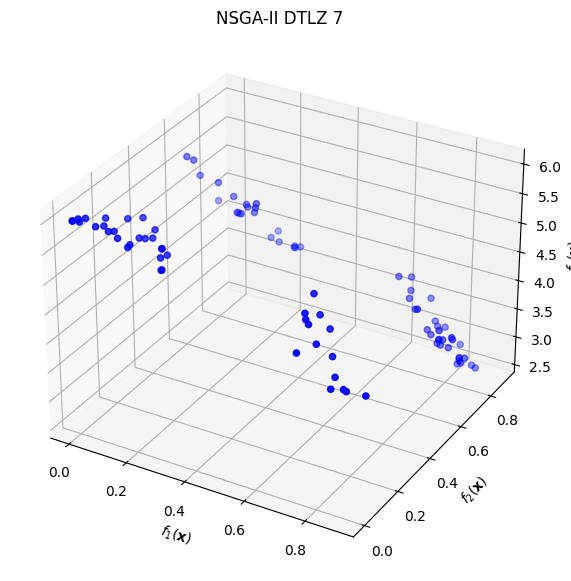

In [22]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-II DTLZ 7")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [36]:
NOBJ = 3
NDIM = 10
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = 92

In [37]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", dtlz7) #Fitness Function
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    # toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_dtlz7_92_500_3_10-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_dtlz7_92_500_3_10-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


Iteration 1
gen	evals	Tiempo   
1  	     	0.0333998
2  	     	0.0479176


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.0921624
4  	     	0.105805 
5  	     	0.121754 
6  	     	0.136348 
7  	     	0.14634  
8  	     	0.166875 
9  	     	0.186563 
10 	     	0.198579 
11 	     	0.213413 
12 	     	0.239849 
13 	     	0.262648 
14 	     	0.28101  
15 	     	0.293686 
16 	     	0.307007 
17 	     	0.315673 
18 	     	0.32479  
19 	     	0.336364 
20 	     	0.346043 
21 	     	0.355655 
22 	     	0.365786 
23 	     	0.376667 
24 	     	0.386489 
25 	     	0.401666 
26 	     	0.414996 
27 	     	0.430187 
28 	     	0.448867 
29 	     	0.47022  
30 	     	0.493419 
31 	     	0.529747 
32 	     	0.560585 
33 	     	0.595773 
34 	     	0.617426 
35 	     	0.634734 
36 	     	0.653635 
37 	     	0.665512 
38 	     	0.683414 
39 	     	0.691969 
40 	     	0.704561 
41 	     	0.71555  
42 	     	0.725134 
43 	     	0.733512 
44 	     	0.744434 
45 	     	0.75373  
46 	     	0.766169 
47 	     	0.780561 
48 	     	0.789585 
49 	     	0.796812 
50 	     	0.812075 
51 	     	0.818897 
52 	     	0.828295 


422	     	6.09211  
423	     	6.10085  
424	     	6.11133  
425	     	6.11991  
426	     	6.12689  
427	     	6.13683  
428	     	6.14696  
429	     	6.156    
430	     	6.16536  
431	     	6.17708  
432	     	6.18666  
433	     	6.21287  
434	     	6.22031  
435	     	6.23912  
436	     	6.26349  
437	     	6.27072  
438	     	6.28734  
439	     	6.29863  
440	     	6.3111   
441	     	6.32592  
442	     	6.33554  
443	     	6.34587  
444	     	6.35494  
445	     	6.36432  
446	     	6.37988  
447	     	6.39252  
448	     	6.40303  
449	     	6.41911  
450	     	6.44298  
451	     	6.45557  
452	     	6.4699   
453	     	6.49489  
454	     	6.51162  
455	     	6.52763  
456	     	6.58388  
457	     	6.60211  
458	     	6.63442  
459	     	6.65548  
460	     	6.67639  
461	     	6.6955   
462	     	6.71737  
463	     	6.72979  
464	     	6.74738  
465	     	6.75706  
466	     	6.76847  
467	     	6.77954  
468	     	6.78656  
469	     	6.79584  
470	     	6.81134  
471	     	6.81965  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


15 	     	0.122869  
16 	     	0.137012  
17 	     	0.144643  
18 	     	0.154743  
19 	     	0.163778  
20 	     	0.178411  
21 	     	0.186794  
22 	     	0.198584  
23 	     	0.205953  
24 	     	0.21471   
25 	     	0.221565  
26 	     	0.230968  
27 	     	0.23902   
28 	     	0.245047  
29 	     	0.251792  
30 	     	0.265049  
31 	     	0.272779  
32 	     	0.280559  
33 	     	0.289628  
34 	     	0.29876   
35 	     	0.306203  
36 	     	0.313577  
37 	     	0.320798  
38 	     	0.331563  
39 	     	0.346029  
40 	     	0.357238  
41 	     	0.365856  
42 	     	0.376825  
43 	     	0.384737  
44 	     	0.394674  
45 	     	0.405015  
46 	     	0.414564  
47 	     	0.421546  
48 	     	0.433475  
49 	     	0.440398  
50 	     	0.451861  
51 	     	0.46208   
52 	     	0.467165  
53 	     	0.478458  
54 	     	0.483504  
55 	     	0.496698  
56 	     	0.505961  
57 	     	0.512563  
58 	     	0.520526  
59 	     	0.533524  
60 	     	0.550853  
61 	     	0.564184  
62 	     	0.5

425	     	5.09193   
426	     	5.09962   
427	     	5.11067   
428	     	5.12077   
429	     	5.1321    
430	     	5.14056   
431	     	5.15077   
432	     	5.16185   
433	     	5.17089   
434	     	5.17951   
435	     	5.18459   
436	     	5.19649   
437	     	5.20602   
438	     	5.21889   
439	     	5.22968   
440	     	5.23865   
441	     	5.24398   
442	     	5.25606   
443	     	5.26818   
444	     	5.27732   
445	     	5.28494   
446	     	5.29767   
447	     	5.30951   
448	     	5.31876   
449	     	5.32946   
450	     	5.33965   
451	     	5.34887   
452	     	5.36539   
453	     	5.37632   
454	     	5.38278   
455	     	5.39286   
456	     	5.4019    
457	     	5.41111   
458	     	5.41771   
459	     	5.43091   
460	     	5.43595   
461	     	5.44754   
462	     	5.46147   
463	     	5.47088   
464	     	5.48096   
465	     	5.48501   
466	     	5.4985    
467	     	5.50845   
468	     	5.51497   
469	     	5.52639   
470	     	5.53562   
471	     	5.54283   
472	     	5.5

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


20 	     	0.166589  
21 	     	0.177183  
22 	     	0.184448  
23 	     	0.192553  
24 	     	0.2014    
25 	     	0.217452  
26 	     	0.236296  
27 	     	0.255623  
28 	     	0.267806  
29 	     	0.285383  
30 	     	0.299347  
31 	     	0.307861  
32 	     	0.317118  
33 	     	0.329889  
34 	     	0.337733  
35 	     	0.349902  
36 	     	0.36061   
37 	     	0.371663  
38 	     	0.384663  
39 	     	0.394766  
40 	     	0.400847  
41 	     	0.417315  
42 	     	0.427702  
43 	     	0.432789  
44 	     	0.445341  
45 	     	0.451422  
46 	     	0.458913  
47 	     	0.466987  
48 	     	0.481744  
49 	     	0.492631  
50 	     	0.497834  
51 	     	0.510979  
52 	     	0.516561  
53 	     	0.530646  
54 	     	0.537716  
55 	     	0.547864  
56 	     	0.558787  
57 	     	0.566536  
58 	     	0.578047  
59 	     	0.585853  
60 	     	0.595572  
61 	     	0.601658  
62 	     	0.616758  
63 	     	0.628314  
64 	     	0.636453  
65 	     	0.645519  
66 	     	0.65786   
67 	     	0.6

427	     	4.61108   
428	     	4.61994   
429	     	4.62917   
430	     	4.63754   
431	     	4.64732   
432	     	4.65568   
433	     	4.66421   
434	     	4.67104   
435	     	4.68246   
436	     	4.68871   
437	     	4.69988   
438	     	4.70933   
439	     	4.71733   
440	     	4.7266    
441	     	4.73464   
442	     	4.74714   
443	     	4.75722   
444	     	4.76562   
445	     	4.78039   
446	     	4.78901   
447	     	4.80146   
448	     	4.81096   
449	     	4.81967   
450	     	4.8291    
451	     	4.83734   
452	     	4.84892   
453	     	4.85857   
454	     	4.867     
455	     	4.87747   
456	     	4.88561   
457	     	4.89443   
458	     	4.90189   
459	     	4.91219   
460	     	4.91958   
461	     	4.92883   
462	     	4.93702   
463	     	4.94682   
464	     	4.95286   
465	     	4.96357   
466	     	4.97303   
467	     	4.98608   
468	     	4.99571   
469	     	5.00409   
470	     	5.01567   
471	     	5.02493   
472	     	5.03215   
473	     	5.04502   
474	     	5.0

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


14 	     	0.126729  
15 	     	0.137019  
16 	     	0.146327  
17 	     	0.158498  
18 	     	0.173201  
19 	     	0.19211   
20 	     	0.205856  
21 	     	0.213391  
22 	     	0.220378  
23 	     	0.233974  
24 	     	0.241585  
25 	     	0.250188  
26 	     	0.258532  
27 	     	0.266802  
28 	     	0.274668  
29 	     	0.28159   
30 	     	0.290265  
31 	     	0.297757  
32 	     	0.305031  
33 	     	0.312286  
34 	     	0.318403  
35 	     	0.325908  
36 	     	0.335757  
37 	     	0.344352  
38 	     	0.35244   
39 	     	0.358485  
40 	     	0.36781   
41 	     	0.37442   
42 	     	0.382473  
43 	     	0.38855   
44 	     	0.399268  
45 	     	0.406628  
46 	     	0.414823  
47 	     	0.4266    
48 	     	0.437324  
49 	     	0.443777  
50 	     	0.454083  
51 	     	0.464864  
52 	     	0.47362   
53 	     	0.481611  
54 	     	0.491235  
55 	     	0.500865  
56 	     	0.508944  
57 	     	0.516339  
58 	     	0.52562   
59 	     	0.536743  
60 	     	0.545439  
61 	     	0.5

414	     	4.30023   
415	     	4.31718   
416	     	4.34021   
417	     	4.35406   
418	     	4.36704   
419	     	4.37703   
420	     	4.38742   
421	     	4.40029   
422	     	4.41326   
423	     	4.42227   
424	     	4.43608   
425	     	4.447     
426	     	4.45656   
427	     	4.46903   
428	     	4.47901   
429	     	4.48802   
430	     	4.50008   
431	     	4.51101   
432	     	4.52204   
433	     	4.53326   
434	     	4.54227   
435	     	4.55126   
436	     	4.55924   
437	     	4.57104   
438	     	4.58041   
439	     	4.58938   
440	     	4.60235   
441	     	4.61136   
442	     	4.62136   
443	     	4.63232   
444	     	4.6413    
445	     	4.65123   
446	     	4.65945   
447	     	4.67105   
448	     	4.68035   
449	     	4.68833   
450	     	4.6995    
451	     	4.7095    
452	     	4.72047   
453	     	4.73171   
454	     	4.74231   
455	     	4.75383   
456	     	4.76438   
457	     	4.77443   
458	     	4.78327   
459	     	4.7934    
460	     	4.80539   
461	     	4.8

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.0979121
8  	     	0.107886 
9  	     	0.118753 
10 	     	0.126733 
11 	     	0.136705 
12 	     	0.150761 
13 	     	0.160987 
14 	     	0.167043 
15 	     	0.181407 
16 	     	0.196742 
17 	     	0.204748 
18 	     	0.212749 
19 	     	0.222742 
20 	     	0.230722 
21 	     	0.237739 
22 	     	0.248709 
23 	     	0.255765 
24 	     	0.262774 
25 	     	0.27167  
26 	     	0.282722 
27 	     	0.291822 
28 	     	0.299857 
29 	     	0.308878 
30 	     	0.31782  
31 	     	0.325734 
32 	     	0.334744 
33 	     	0.346268 
34 	     	0.35562  
35 	     	0.365731 
36 	     	0.374744 
37 	     	0.383722 
38 	     	0.39469  
39 	     	0.402668 
40 	     	0.410895 
41 	     	0.42378  
42 	     	0.432757 
43 	     	0.441733 
44 	     	0.45274  
45 	     	0.461739 
46 	     	0.470979 
47 	     	0.482683 
48 	     	0.490668 
49 	     	0.500872 
50 	     	0.512834 
51 	     	0.523724 
52 	     	0.535727 
53 	     	0.55488  
54 	     	0.574062 
55 	     	0.597762 
56 	     	0.618647 


417	     	5.07463  
418	     	5.0866   
419	     	5.09658  
420	     	5.10755  
421	     	5.11853  
422	     	5.12805  
423	     	5.13854  
424	     	5.14851  
425	     	5.15649  
426	     	5.16572  
427	     	5.17588  
428	     	5.18658  
429	     	5.19671  
430	     	5.20569  
431	     	5.21565  
432	     	5.22662  
433	     	5.23659  
434	     	5.24756  
435	     	5.25953  
436	     	5.2695   
437	     	5.27949  
438	     	5.28947  
439	     	5.30044  
440	     	5.31147  
441	     	5.32343  
442	     	5.33511  
443	     	5.34608  
444	     	5.35605  
445	     	5.36583  
446	     	5.37674  
447	     	5.38771  
448	     	5.39569  
449	     	5.40469  
450	     	5.41575  
451	     	5.42359  
452	     	5.43456  
453	     	5.4457   
454	     	5.45658  
455	     	5.46669  
456	     	5.48026  
457	     	5.49007  
458	     	5.50363  
459	     	5.51456  
460	     	5.52689  
461	     	5.54287  
462	     	5.55774  
463	     	5.57347  
464	     	5.59043  
465	     	5.60901  
466	     	5.6235   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.0705075
6  	     	0.0781341
7  	     	0.0861125
8  	     	0.0930939
9  	     	0.102344 
10 	     	0.112339 
11 	     	0.122836 
12 	     	0.133946 
13 	     	0.142515 
14 	     	0.152466 
15 	     	0.16144  
16 	     	0.169729 
17 	     	0.186992 
18 	     	0.201952 
19 	     	0.217911 
20 	     	0.254143 
21 	     	0.320463 
22 	     	0.340489 
23 	     	0.361454 
24 	     	0.385731 
25 	     	0.413543 
26 	     	0.43623  
27 	     	0.456539 
28 	     	0.473562 
29 	     	0.487366 
30 	     	0.501357 
31 	     	0.513323 
32 	     	0.530255 
33 	     	0.541301 
34 	     	0.552271 
35 	     	0.560251 
36 	     	0.588131 
37 	     	0.604161 
38 	     	0.620119 
39 	     	0.638138 
40 	     	0.66008  
41 	     	0.675038 
42 	     	0.691905 
43 	     	0.711265 
44 	     	0.730441 
45 	     	0.745995 
46 	     	0.763049 
47 	     	0.773488 
48 	     	0.787494 
49 	     	0.795243 
50 	     	0.807257 
51 	     	0.81974  
52 	     	0.82973  
53 	     	0.842346 
54 	     	0.855149 


418	     	5.51723  
419	     	5.5275   
420	     	5.53648  
421	     	5.54656  
422	     	5.55472  
423	     	5.5656   
424	     	5.57458  
425	     	5.58352  
426	     	5.5963   
427	     	5.62315  
428	     	5.63628  
429	     	5.65195  
430	     	5.6739   
431	     	5.70557  
432	     	5.72662  
433	     	5.75106  
434	     	5.77623  
435	     	5.808    
436	     	5.8297   
437	     	5.84522  
438	     	5.8546   
439	     	5.86816  
440	     	5.88368  
441	     	5.8923   
442	     	5.90228  
443	     	5.91126  
444	     	5.92028  
445	     	5.93022  
446	     	5.93954  
447	     	5.94964  
448	     	5.95719  
449	     	5.96817  
450	     	5.97715  
451	     	5.98521  
452	     	5.99518  
453	     	6.00412  
454	     	6.01214  
455	     	6.0231   
456	     	6.03105  
457	     	6.04157  
458	     	6.05158  
459	     	6.05955  
460	     	6.06913  
461	     	6.0811   
462	     	6.08928  
463	     	6.1001   
464	     	6.10812  
465	     	6.11706  
466	     	6.12527  
467	     	6.13528  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


13 	     	0.154781 
14 	     	0.163756 
15 	     	0.194633 
16 	     	0.21183  
17 	     	0.219808 
18 	     	0.231834 
19 	     	0.241862 
20 	     	0.250859 
21 	     	0.260832 
22 	     	0.268811 
23 	     	0.278785 
24 	     	0.290753 
25 	     	0.29873  
26 	     	0.307709 
27 	     	0.318679 
28 	     	0.329688 
29 	     	0.338743 
30 	     	0.348757 
31 	     	0.358286 
32 	     	0.368745 
33 	     	0.377717 
34 	     	0.388716 
35 	     	0.401684 
36 	     	0.412003 
37 	     	0.422044 
38 	     	0.432016 
39 	     	0.441989 
40 	     	0.451002 
41 	     	0.458503 
42 	     	0.471769 
43 	     	0.495652 
44 	     	0.512605 
45 	     	0.531255 
46 	     	0.562646 
47 	     	0.587065 
48 	     	0.605366 
49 	     	0.637842 
50 	     	0.658775 
51 	     	0.677751 
52 	     	0.707668 
53 	     	0.725882 
54 	     	0.741698 
55 	     	0.750672 
56 	     	0.761642 
57 	     	0.770619 
58 	     	0.778597 
59 	     	0.787931 
60 	     	0.797903 
61 	     	0.808896 
62 	     	0.817872 


429	     	5.04759  
430	     	5.05755  
431	     	5.06486  
432	     	5.07479  
433	     	5.08377  
434	     	5.09285  
435	     	5.10178  
436	     	5.10982  
437	     	5.11896  
438	     	5.1288   
439	     	5.14077  
440	     	5.15879  
441	     	5.17781  
442	     	5.19484  
443	     	5.21383  
444	     	5.23048  
445	     	5.24048  
446	     	5.25143  
447	     	5.26181  
448	     	5.27108  
449	     	5.28202  
450	     	5.29103  
451	     	5.29901  
452	     	5.30798  
453	     	5.31623  
454	     	5.32494  
455	     	5.33499  
456	     	5.344    
457	     	5.35475  
458	     	5.36276  
459	     	5.3707   
460	     	5.37868  
461	     	5.38771  
462	     	5.39469  
463	     	5.40566  
464	     	5.41464  
465	     	5.42461  
466	     	5.43462  
467	     	5.44385  
468	     	5.45571  
469	     	5.46474  
470	     	5.47272  
471	     	5.48173  
472	     	5.49097  
473	     	5.50082  
474	     	5.51079  
475	     	5.52076  
476	     	5.52974  
477	     	5.53975  
478	     	5.54973  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


18 	     	0.14665   
19 	     	0.159613  
20 	     	0.174283  
21 	     	0.188123  
22 	     	0.203106  
23 	     	0.21301   
24 	     	0.224481  
25 	     	0.232955  
26 	     	0.240536  
27 	     	0.248548  
28 	     	0.257495  
29 	     	0.265299  
30 	     	0.273319  
31 	     	0.281852  
32 	     	0.290233  
33 	     	0.299246  
34 	     	0.306232  
35 	     	0.316164  
36 	     	0.328132  
37 	     	0.339102  
38 	     	0.349074  
39 	     	0.358201  
40 	     	0.367027  
41 	     	0.377     
42 	     	0.385977  
43 	     	0.395007  
44 	     	0.402985  
45 	     	0.412003  
46 	     	0.422039  
47 	     	0.431976  
48 	     	0.440989  
49 	     	0.449968  
50 	     	0.459257  
51 	     	0.468126  
52 	     	0.476104  
53 	     	0.485081  
54 	     	0.493062  
55 	     	0.502036  
56 	     	0.510018  
57 	     	0.518952  
58 	     	0.526931  
59 	     	0.537004  
60 	     	0.544982  
61 	     	0.551962  
62 	     	0.560942  
63 	     	0.575502  
64 	     	0.595069  
65 	     	0.6

410	     	4.37927   
411	     	4.39966   
412	     	4.42412   
413	     	4.44447   
414	     	4.46411   
415	     	4.4863    
416	     	4.49979   
417	     	4.50907   
418	     	4.52015   
419	     	4.53645   
420	     	4.54995   
421	     	4.5616    
422	     	4.57041   
423	     	4.58416   
424	     	4.60645   
425	     	4.62599   
426	     	4.64549   
427	     	4.65958   
428	     	4.67013   
429	     	4.67927   
430	     	4.68842   
431	     	4.69551   
432	     	4.70501   
433	     	4.71532   
434	     	4.71933   
435	     	4.73271   
436	     	4.74046   
437	     	4.74907   
438	     	4.75617   
439	     	4.76526   
440	     	4.77641   
441	     	4.78497   
442	     	4.79522   
443	     	4.80327   
444	     	4.81025   
445	     	4.81987   
446	     	4.82492   
447	     	4.83702   
448	     	4.84535   
449	     	4.85553   
450	     	4.86054   
451	     	4.87006   
452	     	4.87517   
453	     	4.88575   
454	     	4.89647   
455	     	4.9044    
456	     	4.91323   
457	     	4.9

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


16 	     	0.137861  
17 	     	0.145585  
18 	     	0.155604  
19 	     	0.159762  
20 	     	0.17082   
21 	     	0.176315  
22 	     	0.18556   
23 	     	0.194059  
24 	     	0.200634  
25 	     	0.215378  
26 	     	0.226657  
27 	     	0.235746  
28 	     	0.246882  
29 	     	0.256392  
30 	     	0.265568  
31 	     	0.273452  
32 	     	0.280305  
33 	     	0.286902  
34 	     	0.297318  
35 	     	0.306411  
36 	     	0.316507  
37 	     	0.339466  
38 	     	0.370781  
39 	     	0.395423  
40 	     	0.419146  
41 	     	0.449388  
42 	     	0.466985  
43 	     	0.481055  
44 	     	0.494483  
45 	     	0.509669  
46 	     	0.525427  
47 	     	0.535476  
48 	     	0.539527  
49 	     	0.55026   
50 	     	0.561993  
51 	     	0.570416  
52 	     	0.576681  
53 	     	0.586555  
54 	     	0.596561  
55 	     	0.606554  
56 	     	0.615381  
57 	     	0.629325  
58 	     	0.647952  
59 	     	0.666541  
60 	     	0.677207  
61 	     	0.685363  
62 	     	0.694373  
63 	     	0.6

408	     	4.13327   
409	     	4.14234   
410	     	4.14957   
411	     	4.15584   
412	     	4.16666   
413	     	4.17654   
414	     	4.18467   
415	     	4.19484   
416	     	4.20451   
417	     	4.21439   
418	     	4.22457   
419	     	4.23734   
420	     	4.24548   
421	     	4.25572   
422	     	4.26559   
423	     	4.27488   
424	     	4.28431   
425	     	4.2934    
426	     	4.30455   
427	     	4.31449   
428	     	4.32284   
429	     	4.33173   
430	     	4.34129   
431	     	4.34992   
432	     	4.35996   
433	     	4.36672   
434	     	4.37576   
435	     	4.38565   
436	     	4.39438   
437	     	4.40246   
438	     	4.4102    
439	     	4.41979   
440	     	4.43225   
441	     	4.45483   
442	     	4.47762   
443	     	4.49501   
444	     	4.51567   
445	     	4.53337   
446	     	4.55645   
447	     	4.57691   
448	     	4.59566   
449	     	4.61298   
450	     	4.63672   
451	     	4.64982   
452	     	4.65957   
453	     	4.67324   
454	     	4.68472   
455	     	4.6

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo  
1  	     	0.011276
2  	     	0.0197871
3  	     	0.0285583
4  	     	0.0375981
5  	     	0.0447619
6  	     	0.0519152
7  	     	0.0588591
8  	     	0.0648983
9  	     	0.0738652
10 	     	0.080668 
11 	     	0.0884354
12 	     	0.0985911
13 	     	0.104639 
14 	     	0.112046 
15 	     	0.121003 
16 	     	0.127538 
17 	     	0.135741 
18 	     	0.143747 
19 	     	0.151865 
20 	     	0.158947 
21 	     	0.171351 
22 	     	0.189415 
23 	     	0.20274  
24 	     	0.211507 
25 	     	0.221782 
26 	     	0.227808 
27 	     	0.238045 
28 	     	0.245209 
29 	     	0.253567 
30 	     	0.258791 
31 	     	0.26787  
32 	     	0.273877 
33 	     	0.283998 
34 	     	0.294662 
35 	     	0.300723 
36 	     	0.308717 
37 	     	0.320162 
38 	     	0.330589 
39 	     	0.337576 
40 	     	0.34363  
41 	     	0.357962 
42 	     	0.368555 
43 	     	0.380697 
44 	     	0.390379 
45 	     	0.398927 
46 	     	0.408675 
47 	     	0.417711 
48 	     	0.425403 
49 	     	0.436867 
50

426	     	4.41541  
427	     	4.42638  
428	     	4.43565  
429	     	4.45238  
430	     	4.46189  
431	     	4.47555  
432	     	4.4839   
433	     	4.49187  
434	     	4.50177  
435	     	4.51043  
436	     	4.51799  
437	     	4.52819  
438	     	4.53853  
439	     	4.54777  
440	     	4.56104  
441	     	4.5682   
442	     	4.57772  
443	     	4.58811  
444	     	4.59755  
445	     	4.60764  
446	     	4.61688  
447	     	4.62855  
448	     	4.63872  
449	     	4.64809  
450	     	4.65793  
451	     	4.66703  
452	     	4.67654  
453	     	4.6848   
454	     	4.69269  
455	     	4.70055  
456	     	4.7089   
457	     	4.71893  
458	     	4.72878  
459	     	4.73885  
460	     	4.74706  
461	     	4.75314  
462	     	4.76061  
463	     	4.7678   
464	     	4.77794  
465	     	4.78802  
466	     	4.79771  
467	     	4.8087   
468	     	4.81753  
469	     	4.82562  
470	     	4.8365   
471	     	4.84272  
472	     	4.85579  
473	     	4.86551  
474	     	4.87623  
475	     	4.88232  
